# <center> CM4603 – Coursework 1 (Group) </center>

**Group: D**

Name 1: Mishaal Rifath |
IIT ID: 20210822 |
RGU ID: 2118518

Name 2: Tharani Dissanayake |
IIT ID: 20210157 |
RGU ID: 2118955

Name 3: Lisara Gajaweera |
IIT ID: 20211029 |
RGU ID: 2118813

***

## Introduction

Imports and Settings

In [ ]:
# Standard Library Imports
import gc
import random
import warnings

# Collections and Type Hints
from collections import Counter
from typing import Tuple

# Data Manipulation
import numpy as np
import pandas as pd
import scipy.stats
from scipy.sparse import load_npz, save_npz

# Machine Learning Frameworks
import torch
import torch.nn as nn
import torch.optim as optim
import xgboost as xgb
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BertModel,
    BertTokenizer,
    pipeline
)

# Scikit-learn Imports
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import LatentDirichletAllocation, PCA, TSNE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (
    adjusted_rand_score,
    auc,
    classification_report,
    confusion_matrix,
    jaccard_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, normalize, StandardScaler
from sklearn.svm import SVC

# Natural Language Processing
import gensim
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

import nltk
from nltk import WordNetLemmatizer, ngrams, word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer, WordPunctTokenizer
from nltk.util import ngrams

import spacy

from flair.data import Sentence
from flair.nn import Classifier

# Text Processing and Analysis
import contractions
import emoji
import hdbscan
import inflect
import langdetect
import sentencepiece as spm
from textblob import TextBlob
from tokenizers import Tokenizer
from tokenizers.models import BPE, WordPiece
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer, WordPieceTrainer
from wordcloud import WordCloud

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
warnings.filterwarnings('ignore')

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [8]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

***

## <center> Task 1: Data Collection, Cleaning & EDA </center>

### Data Collection Methodology
In this initial task, we focused on assembling a comprehensive and representitive dataset of TripAdvisor hotel reviews for hotels in Sri Lanka. In order to ensure this, a stratified sampling strategy was created, with the following criteria:
- Reviews taken from 6 regions
- 40 hotels would be taken from each region
- For each hotel, 50 reviews would be taken
- The 50 reviews would be distributed among the different star ratings (10 reviews per rating)


Due to restrictions from TripAdvisor's end traditional web scraping libraries (BeautifulSoup, Scrapy, Selenium, etc.) could not be employed. Hence, a third party API [Apify](https://apify.com/) was used.

Limitations in usage led to batch data scraping which resulted in 7 different datasets for each region.

In [ ]:
# reading the raw individual scaped datasets
colombo = pd.read_csv('data/raw/dataset_colombo_raw.csv')
east = pd.read_csv('data/raw/dataset_east_raw.csv')
ella = pd.read_csv('data/raw/dataset_ella_raw.csv')
galle = pd.read_csv('data/raw/dataset_galle_raw.csv')
kandy = pd.read_csv('data/raw/dataset_kandy_raw_1.csv')
nuwaraeliya = pd.read_csv('data/raw/dataset_nuwaraeliya_raw.csv')

C:\Users\misha\AppData\Local\Temp\ipykernel_912\285257961.py:2: DtypeWarning: Columns (473,531,589,621,623,626,629,632,635,638,641,644,647,650,652,655,658,661,664,667,670,673,676,679,681,684,687,690,693,696,699,702,705,708,710,713,716,719,722,725,728,731,734,737,739,742,745,748,751,754,757,760,763,766,768,771,774,777,780,783,786,789,792,795,797,800,803,806,809,812,815,818,821,824,826,829,832,835,838,841,844,847,850,853,855,858,861,864,867,870,873,876,879,881,884,887,890,893,896,899,902,905,907,910,913,916,919,922,925,928) have mixed types. Specify dtype option on import or set low_memory=False.
  colombo = pd.read_csv('data/raw/dataset_colombo_raw.csv')
C:\Users\misha\AppData\Local\Temp\ipykernel_912\285257961.py:4: DtypeWarning: Columns (357,389,391,394,397,400,403,406,409,412,415,418,420,423,426,429,432,435,438,441,444,447,449,452,455,458,461,464,467,470,473,476,478,481,484,487,490,493,496,499,502,505,507,510,513,516,519,522,525,528,531,534,536,539,542,545,548,551,554,557,560,563,565

In [ ]:
# print the shape of the datasets
colombo.shape, east.shape, ella.shape, galle.shape, kandy.shape, nuwaraeliya.shape

((2000, 1012), (1846, 91), (1951, 870), (2100, 1992), (2000, 90), (1932, 1011))

Since the third party API scraped a lot of metadata, a manual filteration of the relevant columns must be performed before merging the data together

In [ ]:
kandy.columns.tolist()

['helpfulVotes',
 'id',
 'lang',
 'locationId',
 'ownerResponse',
 'ownerResponse/connectionToSubject',
 'ownerResponse/id',
 'ownerResponse/lang',
 'ownerResponse/publishedDate',
 'ownerResponse/responder',
 'ownerResponse/text',
 'placeInfo/address',
 'placeInfo/addressObj/city',
 'placeInfo/addressObj/country',
 'placeInfo/addressObj/postalcode',
 'placeInfo/addressObj/state',
 'placeInfo/addressObj/street1',
 'placeInfo/addressObj/street2',
 'placeInfo/id',
 'placeInfo/latitude',
 'placeInfo/locationString',
 'placeInfo/longitude',
 'placeInfo/name',
 'placeInfo/numberOfReviews',
 'placeInfo/rating',
 'placeInfo/ratingHistogram/count1',
 'placeInfo/ratingHistogram/count2',
 'placeInfo/ratingHistogram/count3',
 'placeInfo/ratingHistogram/count4',
 'placeInfo/ratingHistogram/count5',
 'placeInfo/webUrl',
 'placeInfo/website',
 'publishedDate',
 'publishedPlatform',
 'rating',
 'roomTip',
 'subratings/0/name',
 'subratings/0/value',
 'subratings/1/name',
 'subratings/1/value',
 'subra

In [ ]:
kandy.head()

helpfulVotes         id lang  locationId  ownerResponse  \
0             0  972640226   en     4173413            NaN   
1             0  942345342   en     4173413            NaN   
2             0  932695686   en     4173413            NaN   
3             0  919333160   en     4173413            NaN   
4             0  914641015   en     4173413            NaN   

  ownerResponse/connectionToSubject  ownerResponse/id ownerResponse/lang  \
0                               NaN               NaN                NaN   
1                               NaN               NaN                NaN   
2                               NaN               NaN                NaN   
3                               NaN               NaN                NaN   
4                               NaN               NaN                NaN   

  ownerResponse/publishedDate ownerResponse/responder  ...  \
0                         NaN                     NaN  ...   
1                         NaN                     NaN  ...   
2                         NaN                     NaN  ...   
3                         NaN                     NaN  ...   
4                         NaN                     NaN  ...   

  user/contributions/helpfulVotes user/contributions/totalContributions  \
0                               0                                     1   
1                               1                                    20   
2                               0                                     1   
3                               0                                     1   
4                               0                                    12   

                                      user/link    user/name  \
0          www.tripadvisor.com/Profile/homea575       Home A   
1  www.tripadvisor.com/Profile/R5273HHvalentind   Valentin D   
2        www.tripadvisor.com/Profile/dinast2024      Dinas T   
3      www.tripadvisor.com/Profile/madhawar2016    Madhawa R   
4     www.tripadvisor.com/Profile/315chinthakaw  Chinthaka W   

                        user/userId  user/userLocation user/userLocation/id  \
0  C8DEEF169BD0B06A7116F5AA8CBEE505                NaN                  NaN   
1  74A8DBD1CFC8AB82944759ED1DE3E355                NaN                  NaN   
2  6984DC788123C57BB9DB35B5F53E8CE9                NaN                  NaN   
3  9CEC5C98C2A8732A9E9C71E3A79113E8                NaN             293962.0   
4  DA2EAB222D26CBEAC097EFCB1EB671FD                NaN                  NaN   

  user/userLocation/name  user/userLocation/shortName     user/username  
0                    NaN                          NaN          homea575  
1                    NaN                          NaN  R5273HHvalentind  
2                    NaN                          NaN        dinast2024  
3     Colombo, Sri Lanka                      Colombo      madhawar2016  
4                    NaN                          NaN     315chinthakaw  

[5 rows x 90 columns]

In [ ]:
# based on manual analysis of the scraped data, the following columns were deemed relevant for analysis and future use
useful_columns = [
    'helpfulVotes',
    'id',
    'placeInfo/address',
    'placeInfo/addressObj/city',
    'placeInfo/name',
    'placeInfo/numberOfReviews',
    'placeInfo/rating',
    'placeInfo/webUrl',
    'publishedDate',
    'rating',
    'roomTip',
    'text',
    'title',
    'travelDate',
    'tripType',
    'user/username',
]

In [ ]:
# filter dataframes to only include useful columns
colombo = colombo[useful_columns]
east = east[useful_columns]
ella = ella[useful_columns]
galle = galle[useful_columns]
kandy = kandy[useful_columns]
nuwaraeliya = nuwaraeliya[useful_columns]

# check shape of dataframes after filteration
colombo.shape, east.shape, ella.shape, galle.shape, kandy.shape, nuwaraeliya.shape

((2000, 16), (1846, 16), (1951, 16), (2100, 16), (2000, 16), (1932, 16))

In [ ]:
# Concatenate dataframes
raw_data = pd.concat([colombo, east, ella, galle, kandy, nuwaraeliya])
raw_data.shape

(11829, 16)

In [ ]:
# renaming columns to be more readable
column_names = {
    'helpfulVotes': 'helpfulVotes',
    'id': 'id',
    'placeInfo/address': 'address',
    'placeInfo/addressObj/city': 'city',
    'placeInfo/name': 'placeName',
    'placeInfo/numberOfReviews': 'numberOfReviews',
    'placeInfo/rating': 'placeRating',
    'placeInfo/webUrl': 'webUrl',
    'publishedDate': 'publishedDate',
    'rating': 'userRating',
    'roomTip': 'roomTip',
    'text': 'review_text',
    'title': 'review_title',
    'travelDate': 'travelDate',
    'tripType': 'tripType',
    'user/username': 'username',
}

raw_data = raw_data.rename(columns=column_names)

In [ ]:
raw_data.head()

helpfulVotes           id  \
0           0.0  978474125.0   
1           0.0  978053018.0   
2           0.0  976992067.0   
3           0.0  976690540.0   
4           0.0  976664122.0   

                                             address     city  \
0  24 Dharmapala Mawatha Dharmapala Mawatha, Colo...  Colombo   
1  24 Dharmapala Mawatha Dharmapala Mawatha, Colo...  Colombo   
2  24 Dharmapala Mawatha Dharmapala Mawatha, Colo...  Colombo   
3  24 Dharmapala Mawatha Dharmapala Mawatha, Colo...  Colombo   
4  24 Dharmapala Mawatha Dharmapala Mawatha, Colo...  Colombo   

               placeName  numberOfReviews  placeRating  \
0  Nh Collection Colombo             2392          4.5   
1  Nh Collection Colombo             2392          4.5   
2  Nh Collection Colombo             2392          4.5   
3  Nh Collection Colombo             2392          4.5   
4  Nh Collection Colombo             2392          4.5   

                                              webUrl publishedDate  \
0  https://www.tripadvisor.com/Hotel_Review-g2939...    2024-11-03   
1  https://www.tripadvisor.com/Hotel_Review-g2939...    2024-10-30   
2  https://www.tripadvisor.com/Hotel_Review-g2939...    2024-10-28   
3  https://www.tripadvisor.com/Hotel_Review-g2939...    2024-10-26   
4  https://www.tripadvisor.com/Hotel_Review-g2939...    2024-10-26   

   userRating       roomTip  \
0         5.0  Great place    
1         1.0           NaN   
2         5.0           NaN   
3         5.0           NaN   
4         5.0           NaN   

                                         review_text  \
0  Very good service at Ayu and friendly staff. S...   
1  Change u r lady manager of u r hotel morning s...   
2  Just Perfect \nWe liked everything.\nStaffs ar...   
3  Our stay was unforgettable! The hotel was beau...   
4  Amazing hotel very well situated in Colombo! Y...   

                                        review_title travelDate  tripType  \
0                                  Experience at Ayu    2024-11      SOLO   
1  Change u r lady manager of u r hotel morning s...    2024-10  BUSINESS   
2                                           Amazed !    2024-10    FAMILY   
3                                     Wonderful stay    2024-10    FAMILY   
4                                    Amazing hotel !    2024-10    FAMILY   

          username  
0         219nikal  
1  rajacool1984itz  
2        857navidj  
3      809mickaelt  
4    M1879HRchloet

In [ ]:
# raw_data.to_csv('data/dataset_raw.csv', index=False)

### Data Cleaning

Once the data was collected, we performed thorough data cleaning to ensure data quality and consistency for subsequent analyses.


The cleaning process involved several critical steps:

1. **Duplicate Removal:**
   - **Action:** We inspected the `review_text` column for duplicate entries.
   - **Outcome:** Identified and removed **1 duplicate** review to prevent redundancy in our analysis.

2. **Handling Missing Data:**
   - **Action:** Checked for missing values in the `review_text` column.
   - **Outcome:** Removed **1 row** where the `review_text` was missing, ensuring that all remaining entries contained valid review content.

3. **Text Normalization:**
   - **Lowercasing:**
     - **Action:** Converted all characters in `review_text` to lowercase.
     - **Outcome:** Standardized the text to eliminate case sensitivity issues.

   - **Removing HTML Tags and Special Characters:**
     - **Action:** Stripped away any HTML tags and special characters from the reviews.
     - **Outcome:** Cleaned the text of formatting artifacts that could interfere with text processing.

   - **Removing URLs & Emails:**
     - **Action:** Eliminated any URLs and email addresses present in the reviews.
     - **Outcome:** Removed irrelevant links and contact information, focusing solely on the review content.

   - **Emoji Detection:**
     - **Action:** Scanned the `review_text` for emojis.
     - **Outcome:** Confirmed that there were **no emojis** in the dataset, simplifying text analysis by avoiding the need to handle emoji encoding.

   - **Handling Line Breaks:**
     - **Action:** Managed and standardized line breaks within the `review_text`.
     - **Outcome:** Ensured that reviews were formatted consistently without abrupt or irregular line separations.

   - **Expanding Contractions:**
     - **Action:** Expanded contractions (e.g., "don't" to "do not") in the reviews.
     - **Outcome:** Enhanced the clarity and uniformity of the text, aiding in more accurate tokenization and analysis.

   - **Inflecting Numbers to Words:**
     - **Action:** Converted numerical digits to their corresponding word forms (e.g., "2" to "two").
     - **Outcome:** Maintained textual consistency and improved the semantic understanding of numerical references.

   - **Removing Stopwords:**
     - **Action:** Filtered out common English stopwords (e.g., "the," "and," "is") from the reviews.
     - **Outcome:** Reduced noise in the data, allowing models to focus on more meaningful words that contribute to sentiment and topic identification.

   - **Lemmatization:**
     - **Action:** Applied lemmatization to reduce words to their base or dictionary forms (e.g., "running" to "run").
     - **Outcome:** Normalized the text, facilitating better recognition of word relationships and improving the efficiency of feature extraction.

   - **Dropping Non-English Reviews:**
     - **Action:** Identified and removed reviews written in languages other than English.
     - **Outcome:** Ensured that the dataset was linguistically uniform, which is essential for consistent analysis and modeling.

   - **Whitespace Normalization:**
     - **Action:** Standardized whitespace by removing excessive spaces and ensuring consistent spacing between words.
     - **Outcome:** Achieved a clean and uniform text format, which is crucial for accurate tokenization and vectorization.

In [ ]:
df = pd.read_csv("data/dataset_raw.csv")
df.head()

helpfulVotes           id  \
0           0.0  978474125.0   
1           0.0  978053018.0   
2           0.0  976992067.0   
3           0.0  976690540.0   
4           0.0  976664122.0   

                                             address     city  \
0  24 Dharmapala Mawatha Dharmapala Mawatha, Colo...  Colombo   
1  24 Dharmapala Mawatha Dharmapala Mawatha, Colo...  Colombo   
2  24 Dharmapala Mawatha Dharmapala Mawatha, Colo...  Colombo   
3  24 Dharmapala Mawatha Dharmapala Mawatha, Colo...  Colombo   
4  24 Dharmapala Mawatha Dharmapala Mawatha, Colo...  Colombo   

               placeName  numberOfReviews  placeRating  \
0  Nh Collection Colombo             2392          4.5   
1  Nh Collection Colombo             2392          4.5   
2  Nh Collection Colombo             2392          4.5   
3  Nh Collection Colombo             2392          4.5   
4  Nh Collection Colombo             2392          4.5   

                                              webUrl publishedDate  \
0  https://www.tripadvisor.com/Hotel_Review-g2939...    2024-11-03   
1  https://www.tripadvisor.com/Hotel_Review-g2939...    2024-10-30   
2  https://www.tripadvisor.com/Hotel_Review-g2939...    2024-10-28   
3  https://www.tripadvisor.com/Hotel_Review-g2939...    2024-10-26   
4  https://www.tripadvisor.com/Hotel_Review-g2939...    2024-10-26   

   userRating       roomTip  \
0         5.0  Great place    
1         1.0           NaN   
2         5.0           NaN   
3         5.0           NaN   
4         5.0           NaN   

                                         review_text  \
0  Very good service at Ayu and friendly staff. S...   
1  Change u r lady manager of u r hotel morning s...   
2  Just Perfect \nWe liked everything.\nStaffs ar...   
3  Our stay was unforgettable! The hotel was beau...   
4  Amazing hotel very well situated in Colombo! Y...   

                                        review_title travelDate  tripType  \
0                                  Experience at Ayu    2024-11      SOLO   
1  Change u r lady manager of u r hotel morning s...    2024-10  BUSINESS   
2                                           Amazed !    2024-10    FAMILY   
3                                     Wonderful stay    2024-10    FAMILY   
4                                    Amazing hotel !    2024-10    FAMILY   

          username  
0         219nikal  
1  rajacool1984itz  
2        857navidj  
3      809mickaelt  
4    M1879HRchloet

In [ ]:
# remove duplicate reviews
duplicates = df.duplicated(subset=['review_text'])
print("Number of duplicate reviews removed:", df[df.duplicated(subset=['review_text'])].shape[0])

df = df[~duplicates]

Number of duplicate reviews removed: 1


In [ ]:
# check for missing data
print(f"Number of missing data: \n{df.isnull().sum()}")

Number of missing data: 
helpfulVotes          1
id                    1
address               0
city                 50
placeName             0
numberOfReviews       0
placeRating           1
webUrl                0
publishedDate         1
userRating            1
roomTip            9839
review_text           1
review_title          1
travelDate           10
tripType             10
username              1
dtype: int64


In [ ]:
# check null rows for review_text column
df[df['review_text'].isnull()]

helpfulVotes  id                                            address  \
9917           NaN NaN  No 09 Little England, Nuwara Eliya 22200 Sri L...   

              city                   placeName  numberOfReviews  placeRating  \
9917  Nuwara Eliya  Swiss Cottage Nuwara Eliya                0          NaN   

                                                 webUrl publishedDate  \
9917  https://www.tripadvisor.com/Hotel_Review-g6085...           NaN   

      userRating roomTip review_text review_title travelDate tripType username  
9917         NaN     NaN         NaN          NaN        NaN      NaN      NaN

In [ ]:
# drop null row
df.dropna(subset=['review_text'], inplace=True)

In [ ]:
df.isnull().sum()

helpfulVotes          0
id                    0
address               0
city                 50
placeName             0
numberOfReviews       0
placeRating           0
webUrl                0
publishedDate         0
userRating            0
roomTip            9838
review_text           0
review_title          0
travelDate            9
tripType              9
username              0
dtype: int64

In [ ]:
# convert to lowercase
df['review_text'] = df['review_text'].str.lower()

In [ ]:
# remove HTML tags
df['review_text'] = df['review_text'].str.replace(r'<.*?>', ' ', regex=True)

In [ ]:
# remove URLs & emails
df['review_text'] = df['review_text'].str.replace(r'http\S+|www.\S+|\S+@\S+', ' ', regex=True)

In [ ]:
# remove special characters
df['review_text'] = df['review_text'].str.replace(r'[^\w\s]', ' ', regex=True)

In [ ]:
# check the reviews for emojis using emoji library
def contains_emoji(text):
    return emoji.emoji_count(text) > 0

print(f"Review titles with emojis: {df['review_title'].apply(contains_emoji).sum()}")
print(f"Review text with emojis: {df['review_text'].apply(contains_emoji).sum()}")

Review titles with emojis: 177
Review text with emojis: 0


In [ ]:
# handling line breaks
lb_count = df['review_text'].str.contains('\n').sum()

df['review_text'] = df['review_text'].str.replace('\n', ' ')

print(f"Number of line breaks before: {lb_count}")
print("Number of line breaks after: ", df['review_text'].str.contains('\n').sum())

Number of line breaks before: 5199
Number of line breaks after:  0


In [ ]:
# expand contractions
df['review_text'] = df['review_text'].apply(lambda x: contractions.fix(x))

In [ ]:
# dealing with numbers (inflecting numbers to words)
p = inflect.engine()

# Function to replace numbers with words
def convert_numbers_to_words(text):
    return ' '.join([p.number_to_words(word) if word.isdigit() else word for word in text.split()])

df['review_text'] = df['review_text'].apply(convert_numbers_to_words)

In [ ]:
# removing stopwords
stop_words = set(stopwords.words('english'))

# check stopword count in review_text column
pre_sw_count = df['review_text'].apply(lambda x: len([w for w in x.split() if w in stop_words])).sum()

df['review_text'] = df['review_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

post_sw_count = df['review_text'].apply(lambda x: len([w for w in x.split() if w in stop_words])).sum()

print(f"Number of stop words before: {pre_sw_count}")
print(f"Number of stop words after: {post_sw_count}")

Number of stop words before: 518762
Number of stop words after: 0


In [ ]:
# lemmatization
lemmatizer = WordNetLemmatizer()
df['review_text'] = df['review_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

In [ ]:
# handling multilingual data
df['language'] = df['review_text'].apply(detect)
df['language'].value_counts()

language
en    11806
fr        4
af        2
it        2
he        2
da        2
ta        1
nl        1
ja        1
pl        1
sk        1
es        1
sv        1
ar        1
et        1
Name: count, dtype: int64

In [ ]:
df.loc[df['language'] != 'en', ['id', 'review_text', 'language']]

id                                        review_text language
531    978318618.0  ம ற ஜ வ ட த ய ல அன த த வசத கள ம ச றப ப க இர ந ...       ta
559    973182740.0  cinnamon best restaurant five star hotel sri l...       fr
1493   941314887.0  bad room tile floor broken room like ghost roo...       af
1718   663911918.0  clean functional convenient boutique capsule c...       fr
2089   485911118.0  awesome arugam bay never many yummy meal break...       it
2832   974598907.0  load insect room change room even 2nd room ins...       nl
3051   395484171.0  stayed two night comfortable affordable people...       ja
3273   502935778.0  fajne miejsce super lokalizacja wszędzie blisk...       pl
4189   963411238.0  nice experience amazing hotel good service sta...       he
4438   821759456.0  bandra kindly man always smile room big comfor...       he
4731   715440763.0  hotel near centrum railway station near restau...       sk
4805   744850224.0  view room awesome see ella gap room staff frie...       af
5869   931857605.0  great place wonderful room also enjoyed yoga c...       da
7191   956084861.0  lunch merchant calamari margarita pizza fish a...       it
7806   970829604.0  although date friendliness service people work...       es
7992   820616769.0  beautiful place excellent service great place ...       fr
8136   643583524.0  two couple traveling pleasantly surprised happ...       sv
8488   720324682.0  excellent eco lodge staff charles namal prasan...       fr
8517   823509227.0  هوتيل جميل كانو مثل العائله احببت الوجود معهم ...       ar
9122   969705914.0  anjo bestttt gave u best service love people v...       da
10104  972609242.0  hotel good food nice staff really great sandam...       et

In [ ]:
# keep english reviews only
df = df[df['language'] == 'en']
df.drop(columns=['language'], inplace=True)

In [ ]:
# normalize whitespace
df['review_text'] = df['review_text'].apply(lambda x: ' '.join(x.split()))

In [ ]:
# df.to_csv('data/dataset_cleaned.csv', index=False)

##### Interpretation of Data Cleaning

The comprehensive data cleaning process significantly enhanced the quality and reliability of our dataset. By removing duplicates and handling missing values, we ensured that each review contributed uniquely to our analysis, eliminating redundancy and incomplete data points.

Text normalization steps, including lowercasing, removing HTML tags, special characters, URLs, and emails, streamlined the textual content, making it more suitable for computational processing. The absence of emojis simplified the sentiment analysis by focusing solely on textual cues without the need to interpret graphical symbols.

Expanding contractions and converting numbers to words improved the semantic clarity of the reviews, which is vital for accurate sentiment and topic modeling. The removal of stopwords and lemmatization further refined the text, reducing noise and emphasizing words that carry significant meaning related to customer sentiments and hotel aspects.

By excluding non-English reviews, we maintained linguistic consistency across the dataset, which is essential for the effectiveness of our machine learning models. Whitespace normalization ensured that the text was uniformly formatted, facilitating efficient tokenization and feature extraction in subsequent tasks.

Overall, the meticulous data cleaning efforts laid a robust foundation for feature extraction, sentiment analysis, and topic modeling, ensuring that our analyses were based on high-quality, consistent, and meaningful data.

***

### Exploratory Data Analysis

Next, an extensive EDA was conducted on both the raw and cleaned data to uncover underlying patterns, distributions, and relationships within the data.

The EDA encompassed the following tasks:
1. **Dataset Overview**:
    - **Total Number of Reviews**: Calculated the total number of reviews in the dataset.
    - **Unique Hotels and Users**: Identified the number of unique hotels and users in the dataset.
    - **Average Number of Reviews per Hotel**: Computed the average number of reviews each hotel received.

2. **Review Text Analysis**:
    - **Review Length Statistics**: Analyzed the length of reviews by calculating descriptive statistics such as mean, median and standard deviation.
    - **Distribution of Review Lengths**: Plotted a histogram to visualize the distribution of review lengths.
    - **Common Words & Bigrams**: Identified and ranked the most frequent single words and bigrams across all reviews.
    - **Vocabulary Size & Unique Word Ratio**: Determined the size of the vocabulary and the ratio of unique words to total words in the dataset.
    - **Word Counts for Sentiment Words**: Counted occurances of specific sentiment-related words: "good", "bad", "amazing", "terrible".
    - **Part-of-Speech Tagging Analysis**: Performed POS tagging on the reviews to analyze the grammatical structure.

3. **Temporal Analysis**:
    - **Review Publication Dates**: Analyzed the distribution of review publication dates to identify any patterns or trends.

4. **Visualizations**:
    - **Word Cloud**: Created a word cloud to visualize the most prominent words used in the reviews.

5. **Frequency Distribution Analysis**:
    - **Single-Level Analysis**:
        - **Reviews per City**
        - **Reviews per Trip Type**
        - **Reviews per Place Rating**
        - **Reviews per User Rating**

    - **Multi-Level Analysis**:
        - **User Ratings per Trip Type**
        - **Heatmap of User Rating vs Place Rating**


In [ ]:
df_raw = pd.read_csv('data/dataset_raw.csv')
df_clean = pd.read_csv('data/dataset_cleaned.csv')

In [ ]:
"""Dataset Overview"""

def overview(df, dataset_name):
    """
    Prints an overview of the dataset
    """

    print(f"Dataset Overview of {dataset_name} dataset \n------")
    print(f"Total number of reviews: {df.shape[0]}")
    print(f"Unique hotels: {df['placeName'].nunique()}")
    print(f"Average reviews per hotel: {df.groupby('placeName')['review_text'].count().mean()}")
    print(f"Unique users: {df['username'].nunique()}")
    print(f"Average reviews per user: {df.groupby('username')['review_text'].count().mean()}")
    print(f"Average rating per hotel: {df.groupby('placeName')['userRating'].mean().mean()}")
    print()

overview(df_raw, "raw")
overview(df_clean, "clean")

Dataset Overview of raw dataset 
------
Total number of reviews: 11829
Unique hotels: 240
Average reviews per hotel: 49.28333333333333
Unique users: 11198
Average reviews per user: 1.0562600464368637
Average rating per hotel: 4.4496425627290925

Dataset Overview of clean dataset 
------
Total number of reviews: 11806
Unique hotels: 239
Average reviews per hotel: 49.39748953974895
Unique users: 11177
Average reviews per user: 1.0562762816498166
Average rating per hotel: 4.449374438743097



In [ ]:
"""Review Text Analysis"""

def plot_histogram(data, title, x_label, y_label):
    """
    Plots a histogram of the data
    """
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=50)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

def get_common_words_and_bigrams(data, n=10):
    """
    Prints top n most common words and bigrams
    """
    all_text = ' '.join(data.dropna()).split()
    word_freq = Counter(all_text).most_common(n)

    bigrams = ngrams(all_text, 2)
    bigram_freq = Counter(bigrams).most_common(n)

    print(f"Top {n} most common words: \n{word_freq}")
    print(f"Top {n} most common bigrams: \n{bigram_freq}")

def get_vocab_size_and_unique_word_ratio(data):
    """
    Prints vocab size and unique word ratio
    """
    all_text = ' '.join(data.dropna()).split()
    vocab_size = len(set(all_text))
    unique_word_ratio = len(all_text) / vocab_size
    print(f"\nVocab size: {vocab_size}")
    print(f"Unique word ratio: {unique_word_ratio}")

def get_sentiment_word_counts(data, sentiment_words = ['good', 'bad', 'amazing', 'terrible']):
    """
    Prints sentiment word counts
    """
    all_text = ' '.join(data.dropna()).split()
    sentiment_word_counts = {word: all_text.count(word) for word in sentiment_words}
    print(f"Sentiment Word Counts: {sentiment_word_counts}")

def pos_tagging_analysis(data):
    """
    POS tags the reviews and prints the distribution of POS tags
    """
    all_text = ' '.join(data.dropna()).split()
    pos_tags = nltk.pos_tag(all_text)
    pos_tag_counts = Counter(tag for _, tag in pos_tags)
    print(f"POS Tag Distribution: {pos_tag_counts}")

def review_text_analysis(df, dataset_name):
    """
    Prints a review text analysis of the dataset
    """
    print(f"------\nReview Text Analysis of {dataset_name} dataset\n------")
    review_length = df['review_text'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)

    # print review len stats
    print(f"Review length statistics \n{review_length.describe()}")
    # plot distribution of review len
    plot_histogram(review_length, f"Review Length Histogram of {dataset_name} dataset", "Review Length", "Frequency")
    # common words and bigrams identified
    get_common_words_and_bigrams(df['review_text'], 10)
    # vocab size & unique word ratio
    get_vocab_size_and_unique_word_ratio(df['review_text'])

    # word counts of sentiment words
    get_sentiment_word_counts(df['review_text'])

    # pos tagging analysis
    pos_tagging_analysis(df['review_text'])

Review Text Analysis of raw dataset 
------
Review length statistics 
count    11829.000000
mean        91.961451
std         79.909159
min          0.000000
25%         47.000000
50%         64.000000
75%        107.000000
max       1955.000000
Name: review_text, dtype: float64


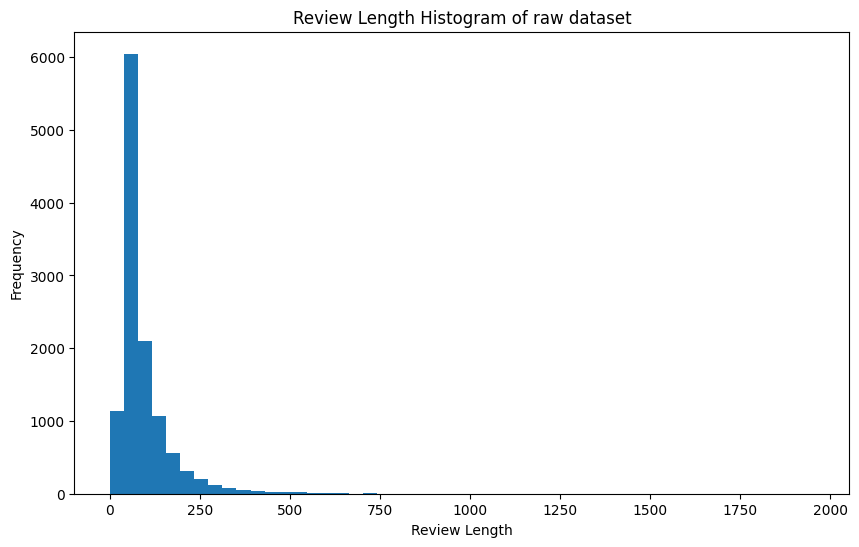

Top 10 most common words: 
[('the', 51947), ('and', 46207), ('a', 26901), ('to', 26395), ('was', 20687), ('The', 15765), ('is', 15588), ('of', 15212), ('in', 14447), ('for', 12879)]
Top 10 most common bigrams: 
[(('in', 'the'), 4597), (('and', 'the'), 4568), (('of', 'the'), 4505), (('to', 'the'), 3418), (('from', 'the'), 2400), (('on', 'the'), 2221), (('at', 'the'), 2199), (('with', 'a'), 2053), (('is', 'a'), 1991), (('had', 'a'), 1862)]

Vocab size: 52084
Unique word ratio: 20.8857230627448
Sentiment Word Counts: {'good': 4142, 'bad': 274, 'amazing': 1706, 'terrible': 74}
POS Tag Distribution: Counter({'NN': 199593, 'DT': 116012, 'JJ': 110135, 'IN': 106735, 'NNP': 68085, 'RB': 64861, 'VBD': 62571, 'CC': 55669, 'PRP': 54524, 'VB': 36825, 'NNS': 33796, 'TO': 26539, 'VBP': 25328, 'VBZ': 24776, 'VBN': 16732, 'VBG': 16602, 'PRP$': 16293, 'CD': 12223, 'MD': 8952, 'WDT': 4085, 'RP': 3239, 'JJS': 3202, 'WRB': 3119, 'WP': 3047, 'EX': 2844, ':': 2524, 'PDT': 2380, 'JJR': 2033, '.': 1544, 'RBR':

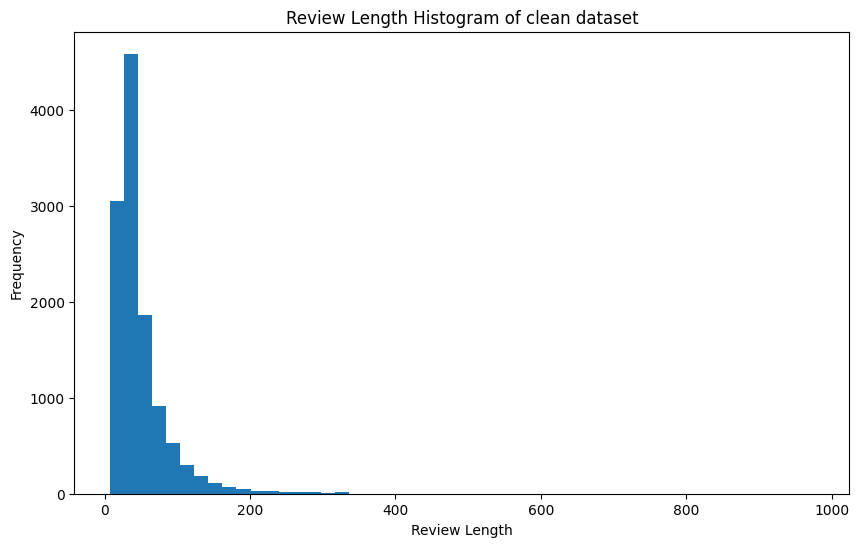

Top 10 most common words: 
[('room', 11725), ('hotel', 10441), ('staff', 8349), ('stay', 6247), ('food', 5900), ('good', 5880), ('place', 5325), ('great', 5052), ('u', 4936), ('view', 4584)]
Top 10 most common bigrams: 
[(('sri', 'lanka'), 1693), (('staff', 'friendly'), 1003), (('highly', 'recommend'), 984), (('sri', 'lankan'), 865), (('room', 'clean'), 841), (('two', 'night'), 749), (('one', 'night'), 701), (('friendly', 'helpful'), 643), (('friendly', 'staff'), 606), (('tuk', 'tuk'), 530)]

Vocab size: 19470
Unique word ratio: 29.72270159219312
Sentiment Word Counts: {'good': 5880, 'bad': 422, 'amazing': 2771, 'terrible': 137}
POS Tag Distribution: Counter({'NN': 255866, 'JJ': 139289, 'RB': 46073, 'VBD': 30721, 'VBG': 21958, 'VBP': 13552, 'CD': 12977, 'VB': 12795, 'VBN': 12400, 'IN': 9324, 'NNS': 5761, 'MD': 5282, 'JJS': 3751, 'DT': 1734, 'VBZ': 1713, 'JJR': 1522, 'RBR': 1011, 'FW': 813, 'NNP': 565, 'CC': 452, 'RP': 436, 'RBS': 278, 'WP': 98, 'WDT': 90, 'WRB': 80, 'PRP': 67, 'WP$': 3

In [ ]:
review_text_analysis(df_raw, "raw")
review_text_analysis(df_clean, "clean")

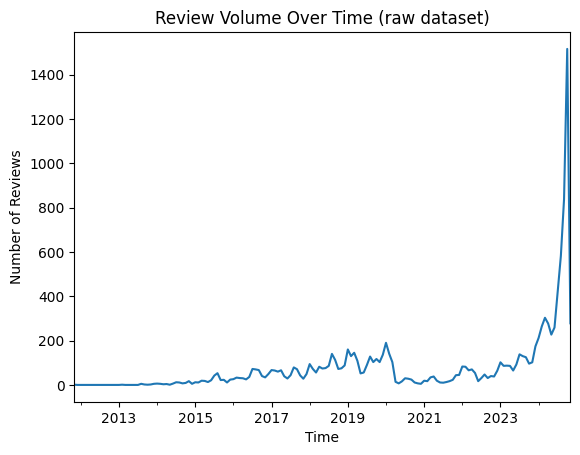

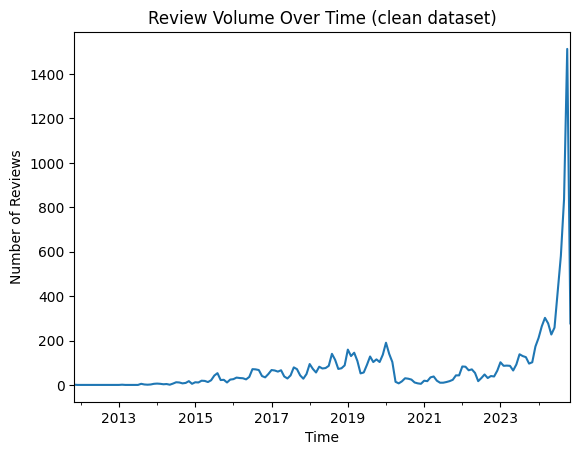

In [ ]:
"""Temporal Analysis"""

def publication_distribution(df, dataset_name):
    """
    Prints the distribution of reviews published over time
    """
    df['publishedDate'] = pd.to_datetime(df['publishedDate'])
    df.set_index('publishedDate')['review_text'].resample('ME').count().plot()
    plt.title(f"Review Volume Over Time ({dataset_name} dataset)")
    plt.xlabel("Time")
    plt.ylabel("Number of Reviews")
    plt.show()

publication_distribution(df_raw, "raw")
publication_distribution(df_clean, "clean")

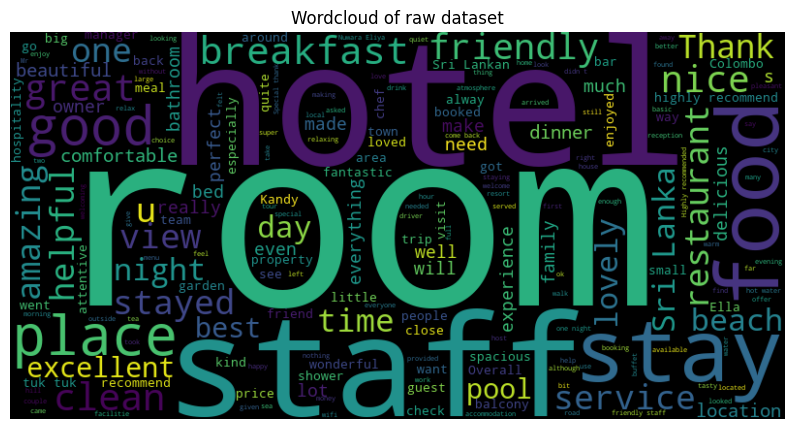

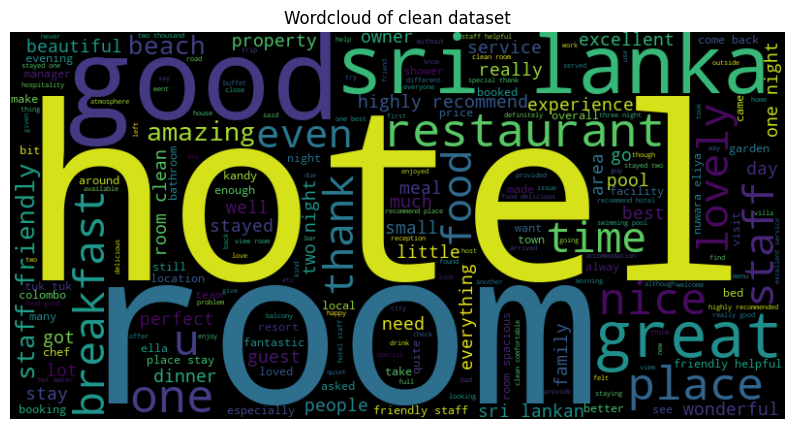

In [ ]:
"""Visualzation"""

def plot_wordcloud(data, title):
    """
    Plots a wordcloud of the data
    """
    # Convert data to string and remove NaN values
    text_data = data.dropna().astype(str)

    # Join the text data
    text = ' '.join(text_data)
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

plot_wordcloud(df_raw['review_text'], "Wordcloud of raw dataset")
plot_wordcloud(df_clean['review_text'], "Wordcloud of clean dataset")

In [ ]:
"""Single-Level Frequency Distribution Analysis"""

def single_level_freq_analysis(df, dataset_name):
    """
    Prints a single-level frequency analysis of the dataset
    """
    print(f"------\nSingle-Level Frequency Analysis of {dataset_name} dataset\n------")
    print(f"Review per City: {df['city'].value_counts()}\n")
    print(f"Review per Trip Type: {df['tripType'].value_counts()}\n")
    print(f"Review per Place Rating: {df['placeRating'].value_counts()}\n")
    print(f"Review per User Rating: {df['userRating'].value_counts()}\n")

single_level_freq_analysis(df_raw, "raw")
single_level_freq_analysis(df_clean, "clean")

------
Single-Level Frequency Analysis of raw dataset
------
Review per City: city
Colombo         2000
Ella            1951
Nuwara Eliya    1932
Kandy           1450
Trincomalee      914
Galle            550
Arugam Bay       494
Unawatuna        450
Pottuvil         438
Hikkaduwa        400
Bentota          350
Kundasale        100
Heerassagala     100
Ahungalla        100
Koggala          100
Ahangama          50
Miwaladeniya      50
Ampitiya          50
Werapitiya        50
Rathgama          50
Gurudeniya        50
Wattegama         50
Hantana           50
Kosgoda           50
Name: count, dtype: int64

Review per Trip Type: tripType
COUPLES     4185
FAMILY      3472
FRIENDS     1826
NONE        1042
SOLO         919
BUSINESS     375
Name: count, dtype: int64

Review per Place Rating: placeRating
4.5    5806
4.0    2563
5.0    2136
3.5     884
3.0     399
2.5      40
Name: count, dtype: int64

Review per User Rating: userRating
5.0    8433
4.0    1787
3.0     695
1.0     560
2.0    

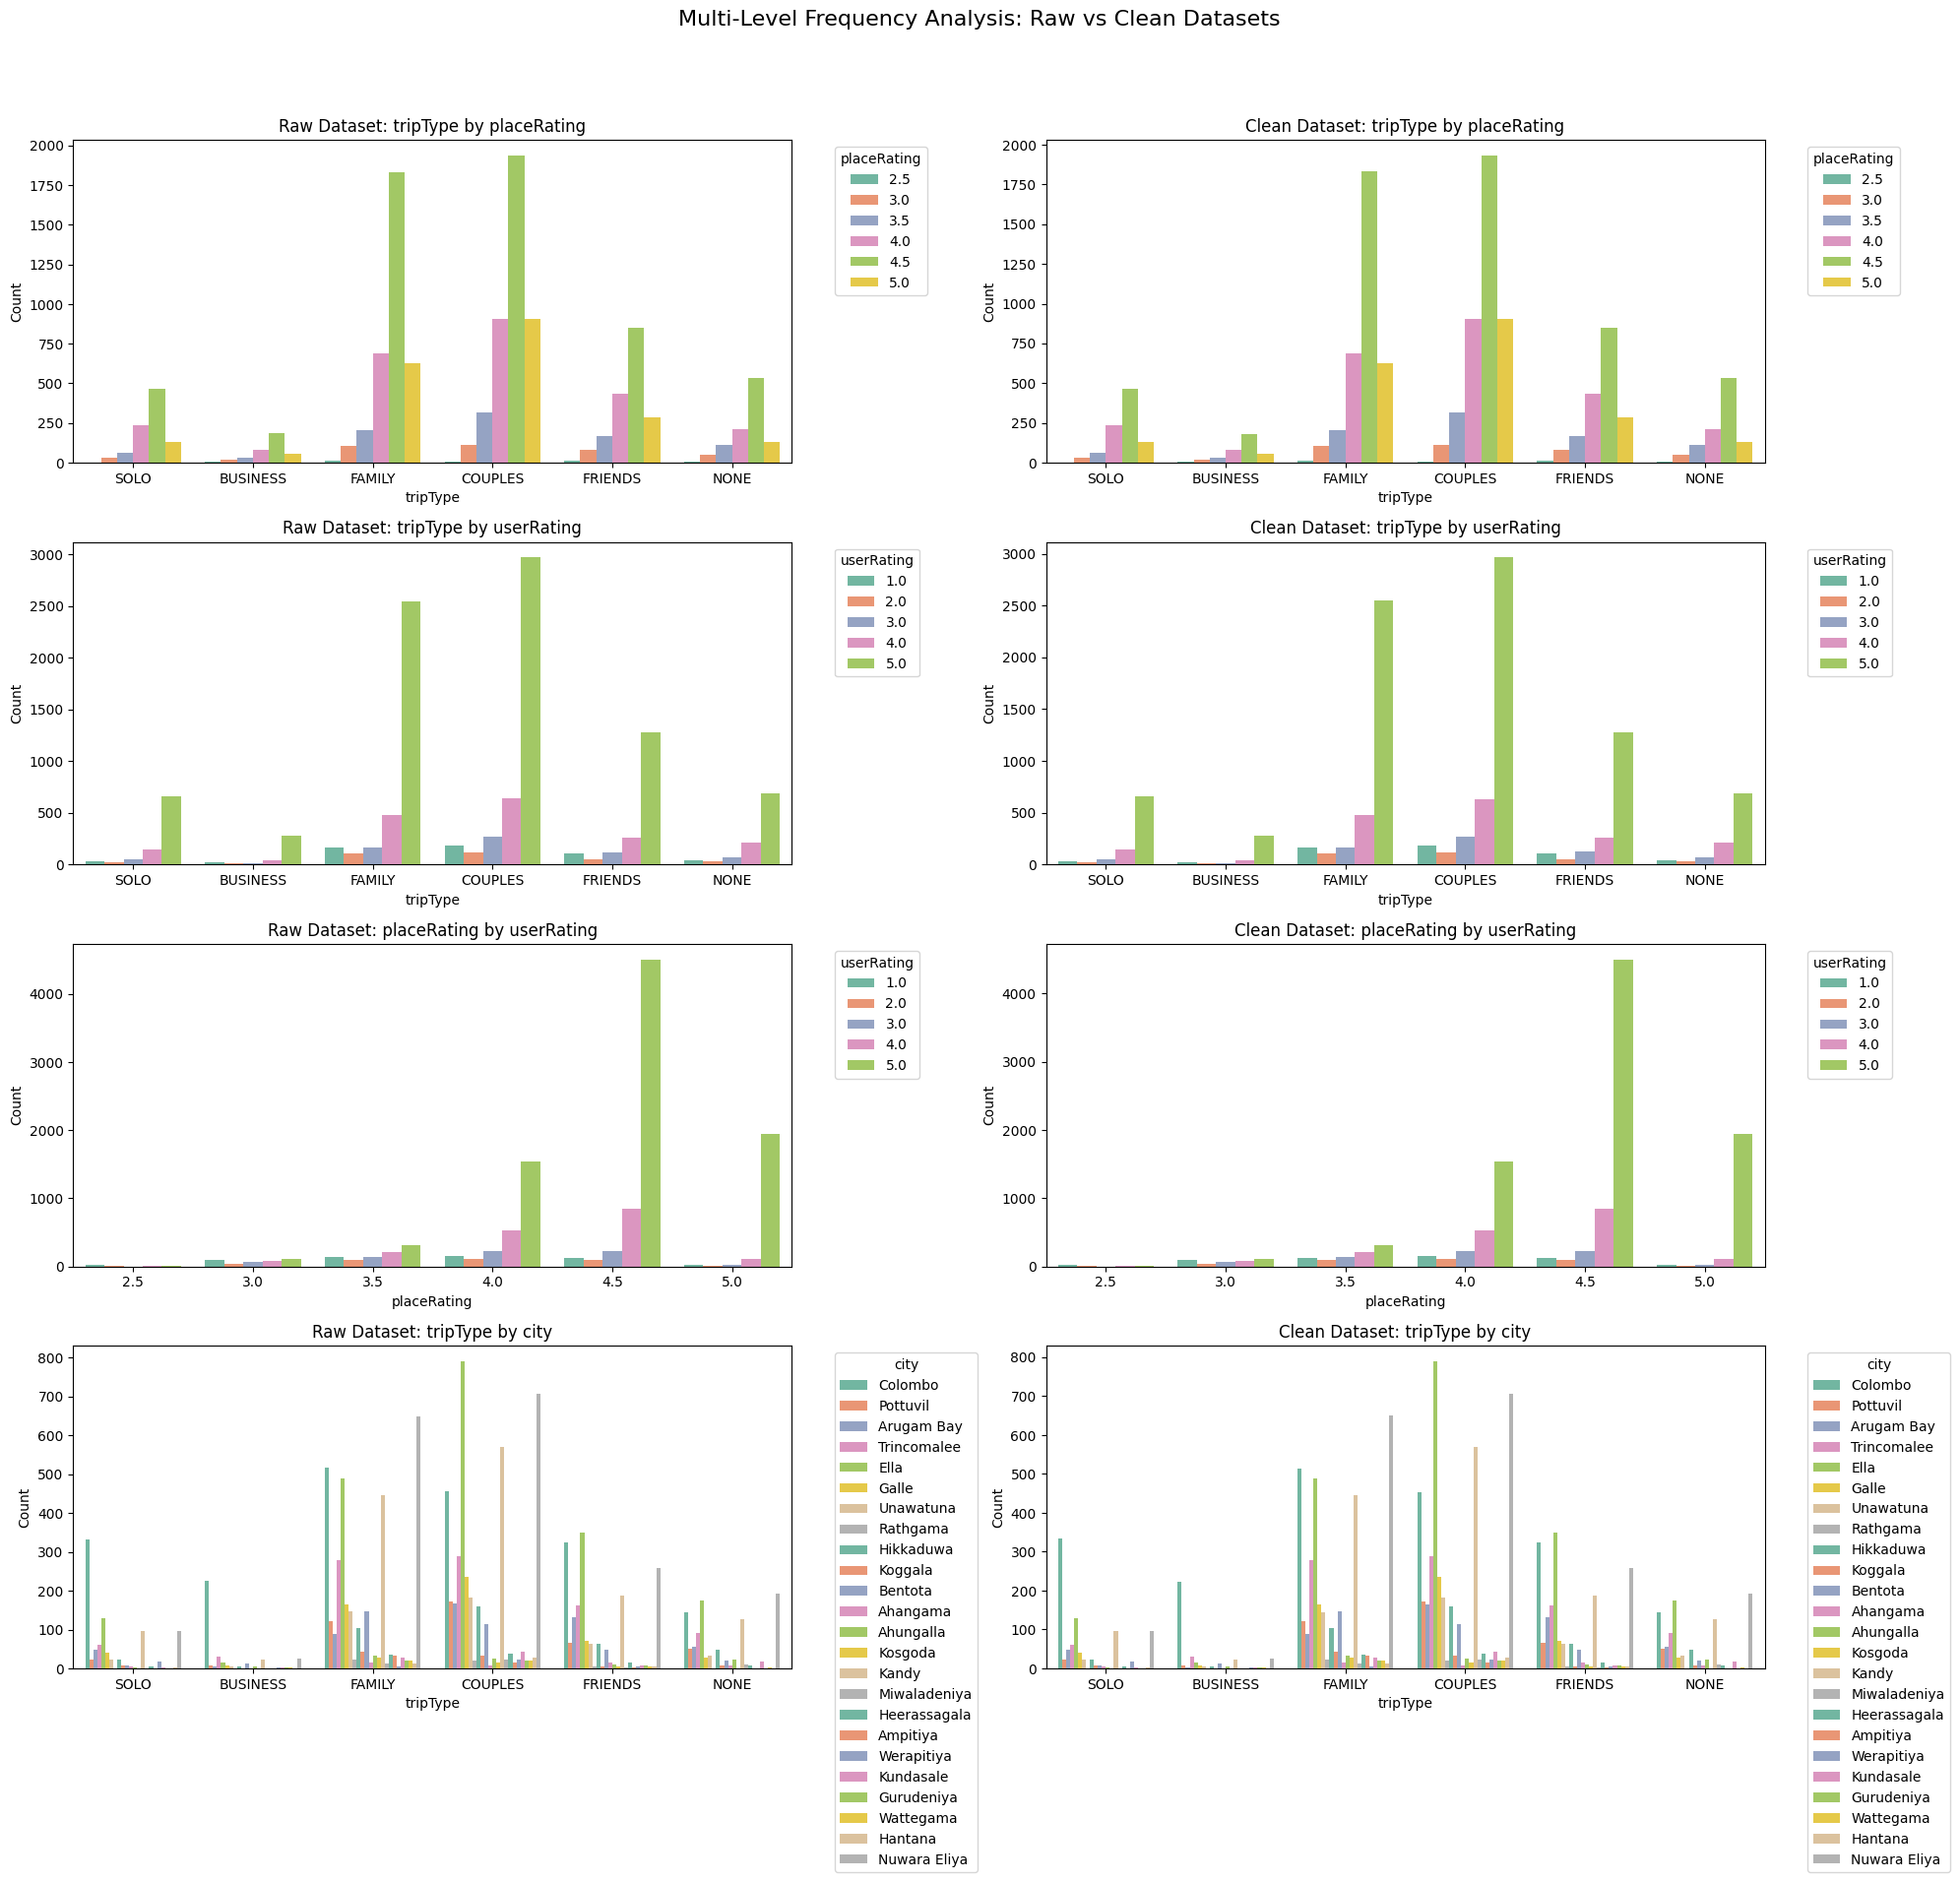

In [ ]:
def count_by_group(df, x_ax, group_by, ax):
    """
    Creates a count plot of the data on a given axis

    Parameters:
    -----------
    df : pandas.DataFrame
        The input dataframe
    x_ax : str
        Column to plot on x-axis
    group_by : str
        Column to use for hue/grouping
    ax : matplotlib.axes.Axes
        The axis to plot on
    """
    sns.countplot(data=df, x=x_ax, hue=group_by, palette='Set2', ax=ax)
    ax.set_xlabel(x_ax)
    ax.set_ylabel('Count')
    ax.set_title(f'Count of {x_ax}, Grouped by {group_by}')
    ax.legend(title=f'{group_by}', bbox_to_anchor=(1.05, 1), loc='upper left')

def multi_level_freq_analysis(df_raw, df_clean):
    """
    Prints a multi-level frequency analysis of both datasets side by side

    Parameters:
    -----------
    df_raw : pandas.DataFrame
        Raw dataset
    df_clean : pandas.DataFrame
        Cleaned dataset
    """
    # Define the plots to create
    plots = [
        ('tripType', 'placeRating'),
        ('tripType', 'userRating'),
        ('placeRating', 'userRating'),
        ('tripType', 'city')
    ]

    # Create a figure with subplots
    fig, axes = plt.subplots(len(plots), 2, figsize=(20, 5*len(plots)))
    fig.suptitle('Multi-Level Frequency Analysis: Raw vs Clean Datasets', fontsize=16)

    # Iterate through plots and create side-by-side comparisons
    for i, (x_ax, group_by) in enumerate(plots):
        # Raw dataset plot
        count_by_group(df_raw, x_ax, group_by, axes[i, 0])
        axes[i, 0].set_title(f'Raw Dataset: {x_ax} by {group_by}')

        # Clean dataset plot
        count_by_group(df_clean, x_ax, group_by, axes[i, 1])
        axes[i, 1].set_title(f'Clean Dataset: {x_ax} by {group_by}')

    # Adjust layout and display
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Usage
multi_level_freq_analysis(df_raw, df_clean)

##### Interpretation of EDA

Overall Sentiment: The EDA revealed a strong positive sentiment among hotel guests, reflected in both word counts and sentiment scores.

Key Aspects Mentioned: Frequent mentions of service quality, room cleanliness, staff friendliness, and location highlight these as critical factors influencing guest satisfaction.

Customer Engagement: An increase in reviews over the past two years could suggest growing customer engagement and possibly an uptick in tourism.

Traveler Profiles: Families and Couples are the travelers that constitute the majority, exhibiting higher satisfaction levels compared to business travelers.

Areas for Improvement: Slightly lower satisfaction among business travelers indicates opportunities to enhance services tailored to their needs.

Correlation Insights: The positive correlation between user ratings and place ratings underscores the importance of maintaining high standards in facilities and services to drive guest satisfaction.

***

## <center> Task 2: Establishing Ground Truth </center>

For this task, the objective was to establish reliable sentiment labels for each hotel review, serving as the ground truth for subsequent analysis and model training. To achieve this, we employed a multi-faceted approach involving three distinct sentiment classifiers and a majority voting scheme:

1. **Exploration of Sentiment Classifiers**:
    - **VADER (Valence Aware Dictionary and sEntiment Reasoner)**:
        - A rule-based sentiment analysis tool specifically attuned to sentiments expressed in social media.
        - Utilizes a lexicon of sentiment-related words and incorporates contextual cues like punctuation and capitalization.
    - **Flair**:
        - An [open-source](https://github.com/flairNLP/flair) NLP library developed by Humboldt University of Berlin.
        - Leverages contextual string embeddings and offers pre-trained models for sentiment analysis.
        - Capable of capturing nuanced sentiment expressions through deep learning architectures.
    - **TextBlob**:
        - A simple Python library for processing textual data.
        - Provides a straightforward API for diving into common NLP tasks, including sentiment analysis.
        - Utilizes a lexicon-based approach combined with some simple machine learning techniques.

2. **Majority Voting Scheme**:
    - **Implementation**:
        - For each review, the sentiment predictions from VADER, Flair, and TextBlob were aggregated.
        - A majority voting mechanism was employed where the most common sentiment among the three classifiers was selected as the final sentiment label.
        - Condition: If the majority sentiment received more than half of the votes (i.e., at least two out of three classifiers agreed), that sentiment was assigned as the ground truth.
    - **Handling Ambiguities**:
        - In cases where there was no clear majority (i.e., all three classifiers provided different sentiments), the review was either flagged for manual review or assigned a neutral sentiment by default, depending on the prevalence of such instances.

In [ ]:
gc.collect()

55952

In [ ]:
df = pd.read_csv('data/dataset_cleaned.csv')

In [ ]:
"""VADER Sentiment Analysis"""
sia = SentimentIntensityAnalyzer()

# Apply VADER to each review and get the compound sentiment score
df['vader_score'] = df['review_text'].apply(lambda x: sia.polarity_scores(str(x)))
df['compound_score'] = df['vader_score'].apply(lambda x: x['compound'])

# Sentiment categorization based on VADER compound score
df['vader_category'] = df['compound_score'].apply(lambda x: 'Positive' if x >= 0.05 else 'Negative')

In [ ]:
df["vader_category"].value_counts()

vader_category
Positive    11317
Negative      489
Name: count, dtype: int64

In [ ]:
"""Flair Sentiment Analysis"""
def analyze_sentiment_apply(df, column_name):
    tagger = Classifier.load('sentiment')

    def get_sentiment(text) -> Tuple[str, float]:
        sentence = Sentence(str(text))
        tagger.predict(sentence)
        return (sentence.labels[0].value, sentence.labels[0].score)

    # Apply the function and create two new columns
    df[['flair_sentiment', 'flair_confidence']] = df[column_name].apply(get_sentiment).apply(pd.Series)
    return df

df = analyze_sentiment_apply(df, 'review_text')

In [ ]:
df["flair_sentiment"].value_counts()

flair_sentiment
POSITIVE    10254
NEGATIVE     1552
Name: count, dtype: int64

In [ ]:
"""TextBlob Sentiment Analysis"""
df['textblob_sentiment'] = df['review_text'].apply(lambda x: TextBlob(x).sentiment)

# map textblob_sentiment column to postive or negative
df['textblob_sentiment'] = df['textblob_sentiment'].apply(lambda x: 'Positive' if x.polarity > 0 else 'Negative')

In [ ]:
df['textblob_sentiment'].value_counts()

textblob_sentiment
Positive    11338
Negative      468
Name: count, dtype: int64

In [ ]:
"""Majority Voting"""
def majority_vote(votes):
  """
  Takes a list of sentiment labels and returns the majority sentiment.
  """
  count = Counter(votes)
  most_common, count = count.most_common(1)[0]

  # If the most common sentiment has more than half the votes, return it
  if count > len(votes) / 2:
    return most_common
  else:
    return "neutral"

# standardize all the sentiment columns
for col in ['vader_category', 'flair_sentiment', 'textblob_sentiment']:
    df[col] = df[col].str.lower()

df['sentiment'] = df.apply(lambda x: majority_vote([x['vader_category'], x['flair_sentiment'], x['textblob_sentiment']]), axis=1)

In [ ]:
df[['vader_category', 'flair_sentiment', 'textblob_sentiment', 'sentiment']].value_counts()

vader_category  flair_sentiment  textblob_sentiment  sentiment
positive        positive         positive            positive     10202
                negative         positive            positive       982
negative        negative         negative            negative       324
                                 positive            negative       134
positive        negative         negative            negative       112
                positive         negative            positive        21
negative        positive         positive            positive        20
                                 negative            negative        11
Name: count, dtype: int64

In [ ]:
df['sentiment'].value_counts()

sentiment
positive    11225
negative      581
Name: count, dtype: int64

In [ ]:
# df.to_csv('data/labelled_data.csv', index=False)

##### Interpretation of Ground Truth Establishment
The establishment of ground truth sentiment labels through the integration of multiple classifiers and a majority voting scheme provided several key benefits:

1. **Enhanced Reliability and Robustness**:
    - **Reduction of Individual Biases**:
        - Each sentiment classifier has its own strengths and potential biases based on its underlying methodology and training data. By aggregating their predictions, we mitigated the influence of any single classifier's bias, leading to more balanced and accurate sentiment labels.
    - **Increased Accuracy**:
        - Majority voting leverages the collective wisdom of multiple models, often resulting in higher accuracy compared to relying on a single classifier. This is particularly advantageous in complex sentiment analysis tasks where nuances in language can lead to divergent interpretations.

2. **Balanced Sentiment Distribution**:
    - **Alignment with Dataset Characteristics**:
        - The sentiment distribution derived from the majority voting scheme closely mirrored the inherent characteristics of the dataset, which, as observed in Task 1, was skewed towards positive sentiments. This alignment ensures that the ground truth labels are reflective of actual customer sentiments.
    - **Identification of Ambiguous Cases**:
        - Reviews where classifiers disagreed highlighted areas of ambiguity or mixed sentiments within the dataset. Addressing these cases, either through manual review or default neutral labeling, provided a more nuanced understanding of customer feedback.

3. **Facilitation of Subsequent Analyses**:
    - **Foundation for Model Training**:
        - Reliable ground truth labels are crucial for training supervised machine learning models. By ensuring the accuracy and consistency of these labels, we laid a strong foundation for effective sentiment classification and topic modeling in subsequent tasks.
    - **Improved Model Evaluation**:
        - With robust ground truth labels, the evaluation metrics for our models (such as accuracy, precision, recall, and F1-score) became more meaningful and indicative of true performance, allowing for better model comparisons and selections.

4. **Operational Efficiency**:
    - **Scalability**:
        - Automating the sentiment labeling process through majority voting enabled efficient handling of large datasets without the need for extensive manual annotation, saving time and resources.
    - **Consistency**:
        - The standardized approach to labeling ensured consistency across the entire dataset, which is essential for maintaining the integrity of analyses and avoiding discrepancies that could arise from manual labeling.

***

## <center>Task 3: Feature Extraction</center>

In this task, we transformed the cleaned review texts into numerical representations suitable for machine learning algorithms by employing both sparse and dense vectorization techniques:

1. **Sparse Vector Representations**:
    - **Count Vectors**:
        - **Action**: Utilized CountVectorizer from sklearn.feature_extraction.text to convert the text data into a matrix of token counts.
        - **Resulting Shape**: The Count Vectors matrix has a shape of (11,806 reviews, 3,000 unique words), where each row represents a review and each column corresponds to the frequency of a specific word.
    - **TF-IDF Vectors**:
        - **Action**: Applied TfidfVectorizer to transform the text data into a matrix of TF-IDF features.
        - **Resulting Shape**: The TF-IDF matrix also has a shape of (11,806 reviews, 3,000 unique words), with each cell representing the TF-IDF score of a word in a given review.

2. **Dense Vector Representations**:
    - **GloVe Embeddings**:
        - **Action**: Incorporated pre-trained GloVe embeddings to convert each word into a 100-dimensional dense vector and averaged these vectors to obtain a single feature vector per review.
        - **Resulting Shape**: The GloVe matrix has a shape of (11,806 reviews, 100 dimensions), where each row represents a review in dense vector space.
    - **Word2Vec Embeddings**:
        - **Action**: Employed pre-trained Word2Vec embeddings to map each word to a 100-dimensional vector and averaged them to create a feature vector for each review.
        - **Resulting Shape**: The Word2Vec matrix has a shape of (11,806 reviews, 100 dimensions), with each row representing a review in dense vector space.

In [ ]:
gc.collect()
df = pd.read_csv('data/labelled_data.csv')

### Sparse Vectors

In [ ]:
"""Count Vectorizer"""
count_vectorizer = CountVectorizer(max_features=3000,min_df=5, max_df=0.8)
count_matrix = count_vectorizer.fit_transform(df['review_text'])  # Transform text into sparse matrix

In [ ]:
print(f"Count Vectorizer Matrix Shape: {count_matrix.shape}")

Count Vectorizer Matrix Shape: (11806, 3000)


In [ ]:
"""TF-IDF Vectorizer"""
tfidf_vectorizer = TfidfVectorizer(max_features=3000,min_df=5, max_df=0.8)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['review_text'])  # Transform text into sparse matrix

In [ ]:
print(f"TF-IDF Vectorizer Matrix Shape: {tfidf_matrix.shape}")

TF-IDF Vectorizer Matrix Shape: (11806, 3000)


In [ ]:
# np.save('data/processed/count_matrix.npy', count_matrix.toarray())
# np.save('data/processed/tfidf_matrix.npy', tfidf_matrix.toarray())

### Dense Vectors

In [ ]:
gc.collect()

0

In [ ]:
"""GloVe Vector Embeddings"""
# Path to the converted Word2Vec format file
glove_file = 'glove.6B.300d.txt'
word2vec_glove_file = 'glove.6B.300d.word2vec.txt'

# Convert the GloVe file
glove2word2vec(glove_file, word2vec_glove_file)

# Load GloVe vectors
glove_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_glove_file, binary=False)

def get_average_vector(tokens, model, embedding_dim):
    vectors = []
    for token in tokens:
        if token in model:
            vectors.append(model[token])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(embedding_dim)

df['tokens'] = df['review_text'].apply(lambda x: x.lower().split())

embedding_dim = 300  # GloVe dimension
df['glove_embedding'] = df['tokens'].apply(lambda x: get_average_vector(x, glove_model, embedding_dim))


In [ ]:
# create glove embedding matrix
glove_embedding_matrix = np.array(df['glove_embedding'].tolist())
# np.save('data/processed/glove_embedding_matrix.npy', glove_embedding_matrix)

In [ ]:
glove_embedding_matrix.shape

(11806, 300)

In [ ]:
"""Word2Vec Embeddings"""

# Load Word2Vec vectors
word2vec_file = 'GoogleNews-vectors-negative300.bin.gz'
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_file, binary=True)

In [ ]:
df['tokens'] = df['review_text'].apply(lambda x: x.lower().split())
df['word2vec_embedding'] = df['tokens'].apply(lambda x: get_average_vector(x, word2vec_model, embedding_dim))
# print(df['word2vec_embedding'].iloc[0].shape)

w2v_embedding_matrix = np.array(df['word2vec_embedding'].tolist())
# np.save('data/processed/w2v_embedding_matrix.npy', w2v_embedding_matrix)

##### Interpretation of Feature Extraction
The selection of both sparse and dense vector representations was intentional, aiming to capture different facets of the textual data:

1. **Sparse Vector Representations**:
    - **Count Vectors**:
        Strengths: Simple to implement and interpret; effective for linear models.
        Weaknesses: High dimensionality and lack of semantic understanding.
        Suitability: Well-suited for models like Logistic Regression and SVM that can handle high-dimensional sparse data efficiently.
    - **TF-IDF Vectors**:
        Strengths: Emphasizes important words by scaling based on their uniqueness across documents; reduces the weight of common words.
        Weaknesses: Still high-dimensional and ignores word order and context.
        Suitability: Enhances performance of linear models by focusing on discriminative features, making it preferable over Count Vectors for algorithms sensitive to feature importance.

2. **Dense Vector Representations**:
    - **GloVe Embeddings**:

        - **Strengths**: Captures semantic relationships between words; reduces dimensionality.

        - **Weaknesses**: Averaging vectors may dilute contextual nuances; dependent on the quality of pre-trained embeddings.

        - **Suitability**: Suitable for both traditional ML models and deep learning architectures, providing richer feature representations that improve model performance.

    - **Word2Vec Embeddings**:
    
        - **Strengths**: Encapsulates contextual and semantic information; flexible for capturing word relationships.
        
        - **Weaknesses**: Similar to GloVe, averaging can lose specific contextual details.
        
        - **Suitability**: Enhances classifiers by providing dense, meaningful features, making it effective for models that can leverage semantic information, including SVM and neural networks.

**Comparative Justification**:

- **Sparse vs. Dense Representations**:
    - Sparse representations like Count Vectors and TF-IDF are effective for capturing word frequency and importance, essential for linear classifiers. However, they lack the ability to understand context and semantics.
    - Dense representations such as GloVe and Word2Vec provide a deeper semantic understanding by capturing word relationships, which can significantly enhance the performance of classifiers, especially those capable of leveraging rich feature spaces.

- **Model Compatibility**:
    - Linear Models (Logistic Regression, SVM): Benefit from TF-IDF's emphasis on important words, improving their discriminative capabilities.
    - Deep Learning Models: Gain from the semantic richness of dense embeddings, allowing for better generalization and performance.

***

## <center>Task 4: Text Classification</center>

In Task 4, we aimed to build and evaluate sentiment classification models using traditional machine learning algorithms. We experimented with three different classifiers and applied them to the feature sets generated from the four feature extraction methods established in Task 3. Our approach involved rigorous evaluation techniques to ensure the reliability and generalizability of our models.

**Algorithms Selected**:
1. Random Forest Classifier:
2. Support Vector Machine
3. Extreme Gradient Boosting (XGBoost)

In [ ]:
gc.collect()

36

In [ ]:
df = pd.read_csv('data/labelled_data.csv')

count_matrix = np.load('data/processed/count_matrix.npy', allow_pickle=True)
tfidf_matrix = np.load('data/processed/tfidf_matrix.npy', allow_pickle=True)
glove_matrix = np.load('data/processed/glove_embedding_matrix.npy')
w2v_matrix = np.load('data/processed/w2v_embedding_matrix.npy')

In [ ]:
print(count_matrix.shape)
print(tfidf_matrix.shape)
print(glove_matrix.shape)
print(w2v_matrix.shape)

(11806, 3000)
(11806, 3000)
(11806, 300)
(11806, 300)


In [ ]:
# convert sentiment to binary and store in a separate variable
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
y = df['sentiment'].tolist()

In [23]:
def plot_class_distribution(y, title='Class Distribution'):
    """Plot the distribution of classes in the target variable."""
    plt.figure(figsize=(10, 5))
    sns.countplot(x=y)
    plt.title(title)
    plt.show()

def create_resampling_pipeline(smote_ratio=0.5, undersample_ratio=0.7, random_state=42):
    """Create a resampling pipeline with SMOTE and RandomUnderSampler."""
    return Pipeline([
        ('smote', SMOTE(sampling_strategy=smote_ratio, random_state=random_state)),
        ('undersampling', RandomUnderSampler(sampling_strategy=undersample_ratio, random_state=random_state))
    ])

def prepare_training_data(X, y, test_size=0.2, random_state=42):
    """Prepare and resample training data."""
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

    # Convert to dense format if using sparse matrices
    if hasattr(X_train, 'toarray'):
        X_train = X_train.toarray()
        X_test = X_test.toarray()

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply resampling
    resampling = create_resampling_pipeline()
    X_train_resampled, y_train_resampled = resampling.fit_resample(X_train_scaled, y_train)

    return X_train_resampled, X_test_scaled, y_train_resampled, y_test


def get_model_params(model_type, y_train=None):
    """Get default parameters for different model types."""
    if model_type == 'xgb':
        return {
            'objective': 'binary:logistic',
            'eval_metric': ['logloss', 'error', 'auc'],
            'max_depth': 6,
            'min_child_weight': 1,
            'learning_rate': 0.1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'tree_method': 'hist'
        }
    elif model_type == 'svm':
        return {
            # 'C': 1.0,
            'kernel': 'linear',
            # 'gamma': 'scale',
            'class_weight': 'balanced'
        }
    elif model_type == 'rf':
        return {
            'n_estimators': 100,
            'max_depth': 10,
            'min_samples_split': 2,
            'min_samples_leaf': 1,
            'class_weight': 'balanced'
        }
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

def train_model(model_type, X_train, X_test, y_train, y_test, params=None, num_rounds=1000):
    """Train model with early stopping and return model and evaluation results."""
    # Use default params if none provided
    if params is None:
        params = get_model_params(model_type, y_train)

    # Train the model based on type
    if model_type == 'xgb':
        # Create DMatrix for XGBoost
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)

        # Initialize evaluation results dictionary
        evals_result = {}

        # Train XGBoost model
        model = xgb.train(
            params,
            dtrain,
            num_rounds,
            evals=[(dtrain, 'train'), (dtest, 'eval')],
            early_stopping_rounds=50,
            verbose_eval=100,
            evals_result=evals_result
        )

        return model, evals_result

    elif model_type in ['svm', 'rf']:
        # Select the appropriate scikit-learn model
        if model_type == 'svm':
            model = SVC(**params, probability=True)
        else:  # Random Forest
            model = RandomForestClassifier(**params)

        # Fit the model
        model.fit(X_train, y_train)

        # Create a mock evaluation result dictionary to maintain consistency
        evals_result = {
            'train': {
                'logloss': [-np.log(model.predict_proba(X_train)[:, 1]).mean()],
                'error': [1 - model.score(X_train, y_train)],
                'auc': [roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])]
            },
            'eval': {
                'logloss': [-np.log(model.predict_proba(X_test)[:, 1]).mean()],
                'error': [1 - model.score(X_test, y_test)],
                'auc': [roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])]
            }
        }

        return model, evals_result

    else:
        raise ValueError(f"Unsupported model type: {model_type}")


def plot_training_metrics(evals_result, model_type):
    """Plot training metrics including loss, error, and AUC."""
    if model_type not in ['xgb']:
        # Not applicable for non-XGBoost models
        return

    plt.figure(figsize=(15, 5))

    # Plot training and validation log loss
    plt.subplot(1, 3, 1)
    plt.plot(evals_result['train']['logloss'], label='Train')
    plt.plot(evals_result['eval']['logloss'], label='Validation')
    plt.title('Log Loss vs Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Log Loss')
    plt.legend()

    # Plot training and validation error
    plt.subplot(1, 3, 2)
    plt.plot(evals_result['train']['error'], label='Train')
    plt.plot(evals_result['eval']['error'], label='Validation')
    plt.title('Classification Error vs Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    plt.legend()

    # Plot training and validation AUC
    plt.subplot(1, 3, 3)
    plt.plot(evals_result['train']['auc'], label='Train')
    plt.plot(evals_result['eval']['auc'], label='Validation')
    plt.title('AUC vs Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

def evaluate_model(model, model_type, X_test, y_test):
    """Evaluate the model and plot confusion matrix and ROC curve."""
    # Get predictions based on model type
    if model_type == 'xgb':
        dtest = xgb.DMatrix(X_test)
        y_pred_proba = model.predict(dtest)
        y_pred = (y_pred_proba > 0.5).astype(int)
    else:  # SVM and Random Forest
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return y_pred, y_pred_proba

def train_and_evaluate_model(X, y, model_type='xgb', feature_names=None, custom_params=None):
    """Main function to train and evaluate the model."""
    # Validate model type
    if model_type not in ['xgb', 'svm', 'rf']:
        raise ValueError(f"Unsupported model type: {model_type}")

    # Plot initial class distribution
    plot_class_distribution(y, title='Initial Class Distribution')

    # Prepare data
    X_train_resampled, X_test, y_train_resampled, y_test = prepare_training_data(X, y)

    # Plot resampled class distribution
    plot_class_distribution(y_train_resampled, title='Class Distribution After Resampling')

    # Train model
    model, evals_result = train_model(
        model_type,
        X_train_resampled,
        X_test,
        y_train_resampled,
        y_test,
        params=custom_params
    )

    # Plot training metrics (note: for SVM and RF, this will only show the single point)
    plot_training_metrics(evals_result, model_type)

    # Evaluate model
    y_pred, y_pred_proba = evaluate_model(model, model_type, X_test, y_test)

    return model, evals_result

### Random Forest

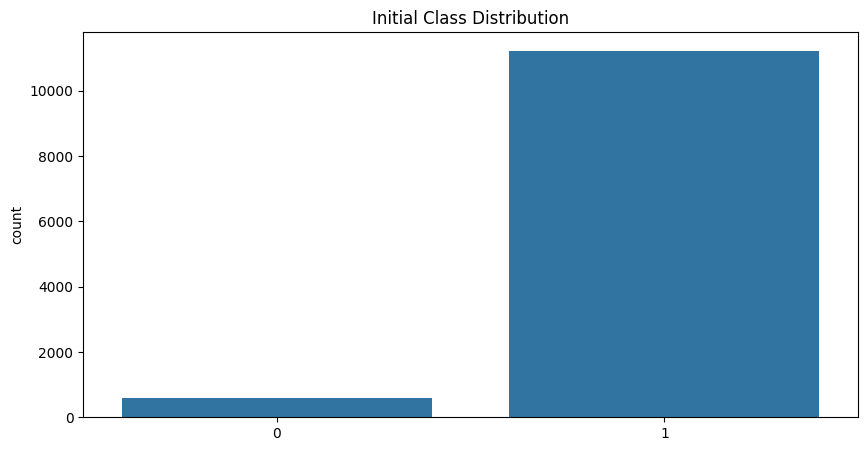

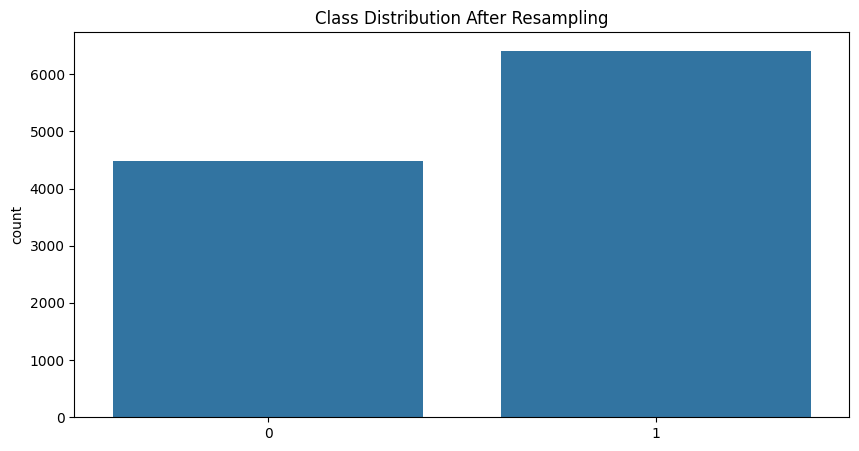

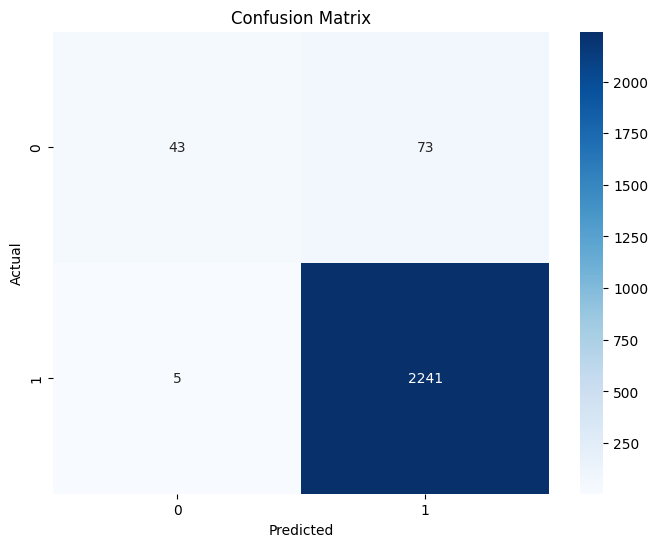

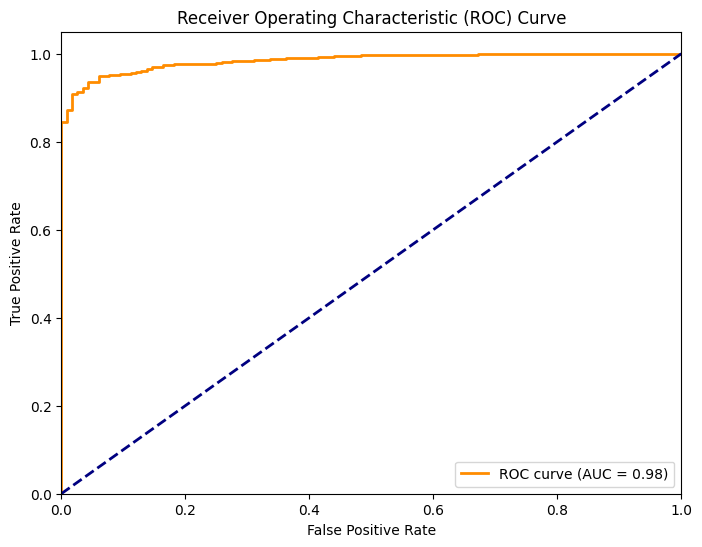


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.37      0.52       116
           1       0.97      1.00      0.98      2246

    accuracy                           0.97      2362
   macro avg       0.93      0.68      0.75      2362
weighted avg       0.96      0.97      0.96      2362



In [ ]:
# Using count matrix
rf_model, rf_results = train_and_evaluate_model(count_matrix, y, model_type='rf')

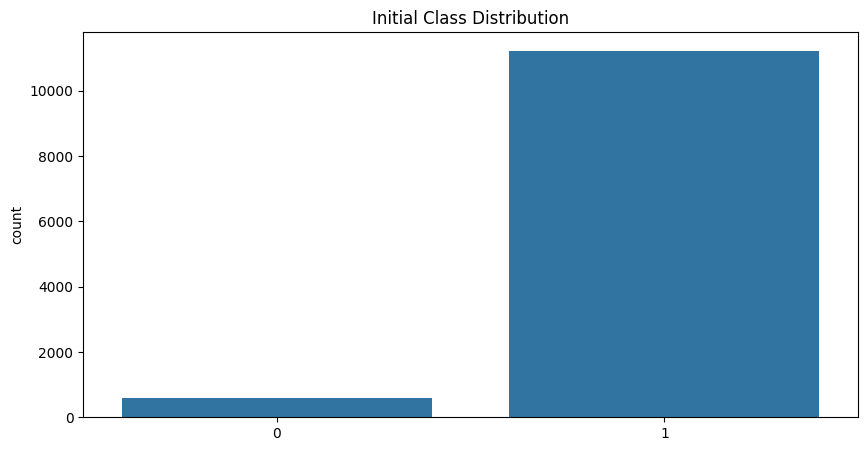

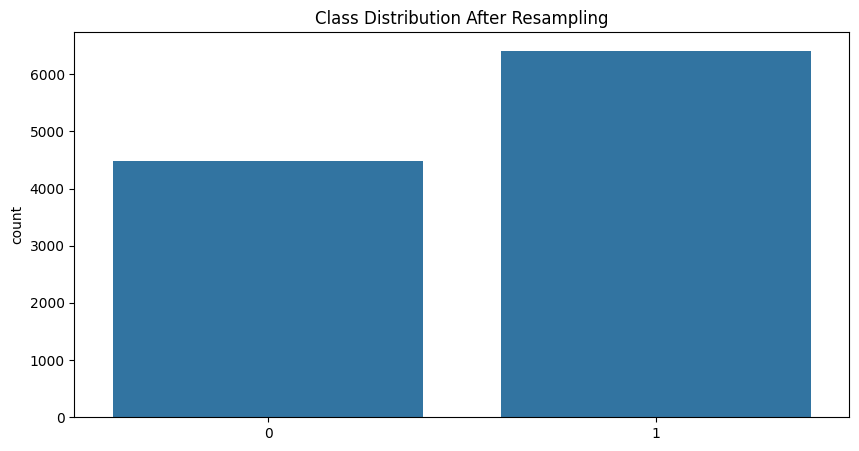

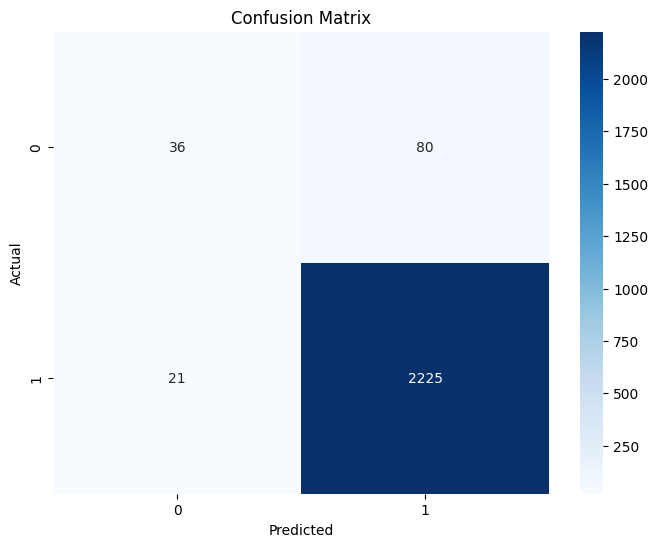

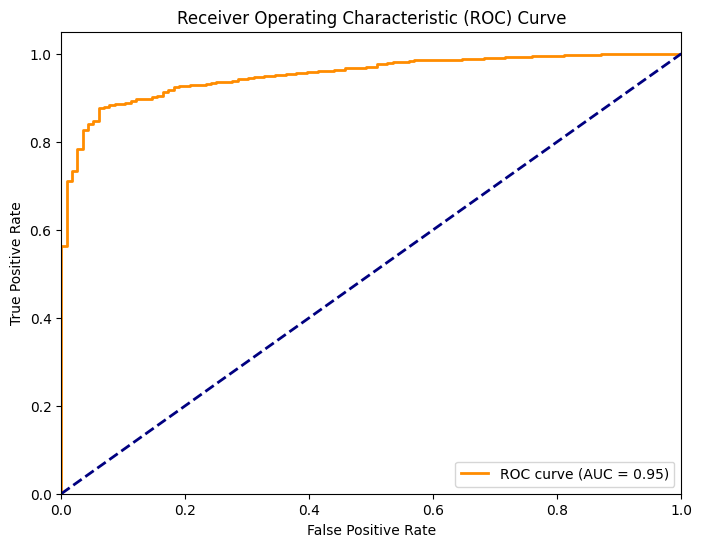


Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.31      0.42       116
           1       0.97      0.99      0.98      2246

    accuracy                           0.96      2362
   macro avg       0.80      0.65      0.70      2362
weighted avg       0.95      0.96      0.95      2362



In [ ]:
# Using tf-idf matrix
rf_model, rf_results = train_and_evaluate_model(tfidf_matrix, y, model_type='rf')

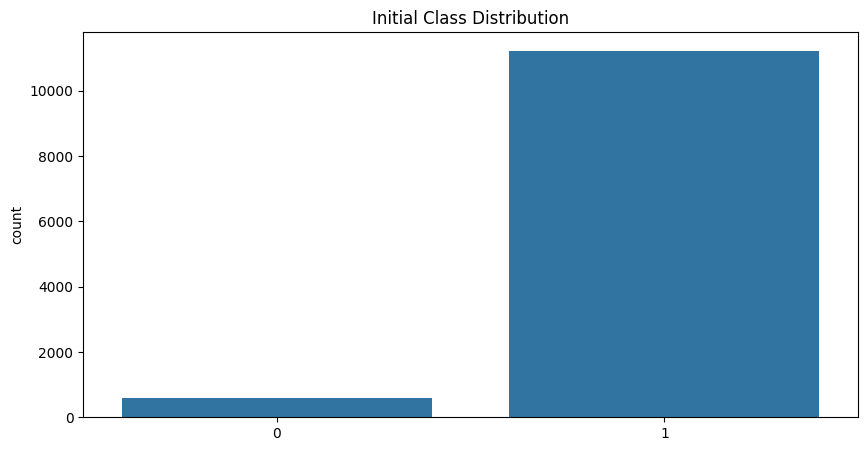

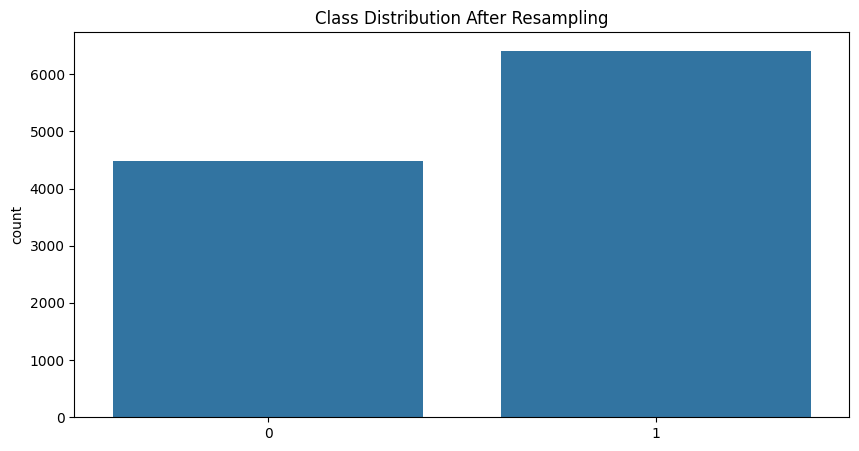

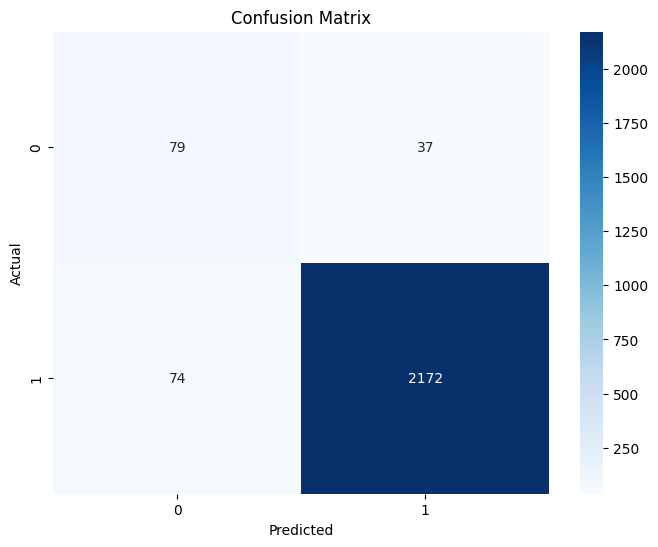

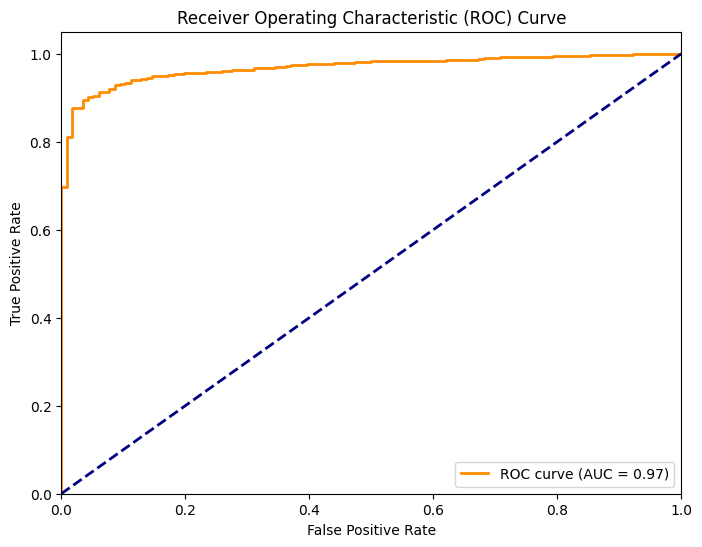


Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.68      0.59       116
           1       0.98      0.97      0.98      2246

    accuracy                           0.95      2362
   macro avg       0.75      0.82      0.78      2362
weighted avg       0.96      0.95      0.96      2362



In [ ]:
# Using glove matrix
rf_model, rf_results = train_and_evaluate_model(glove_matrix, y, model_type='rf')

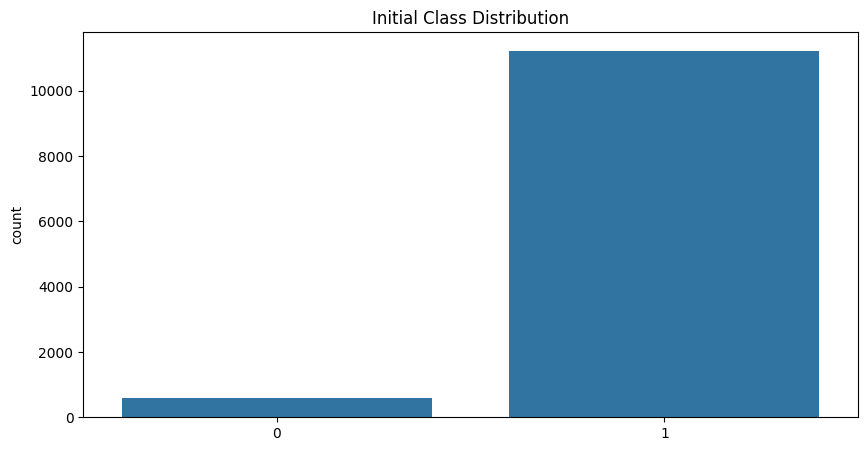

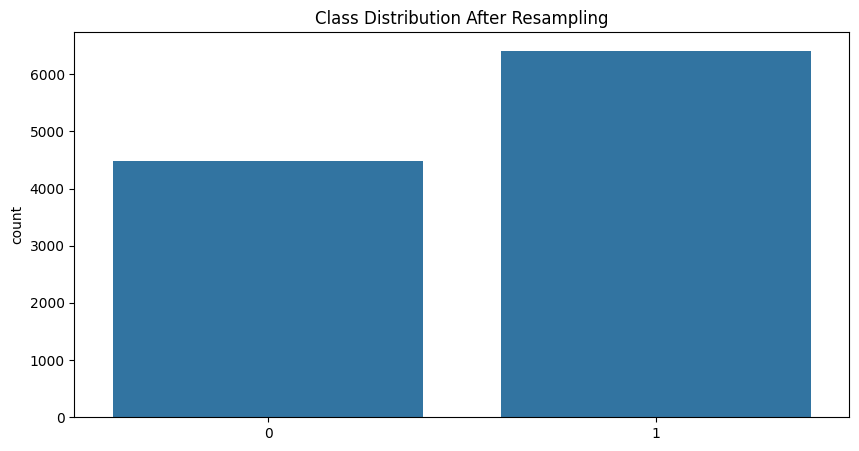

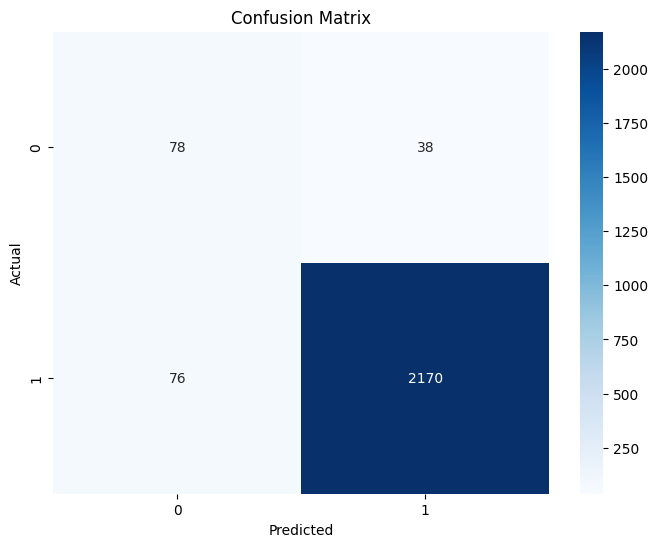

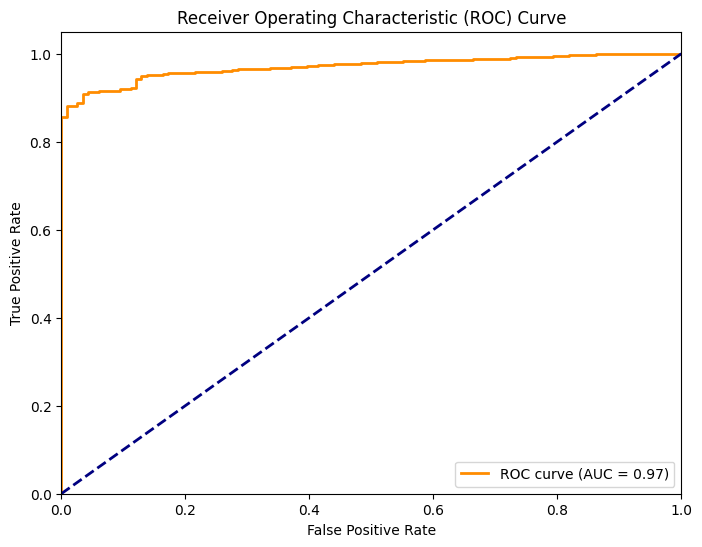


Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.67      0.58       116
           1       0.98      0.97      0.97      2246

    accuracy                           0.95      2362
   macro avg       0.74      0.82      0.78      2362
weighted avg       0.96      0.95      0.95      2362



In [ ]:
# Using glove matrix
rf_model, rf_results = train_and_evaluate_model(w2v_matrix, y, model_type='rf')

### Support Vector Machine

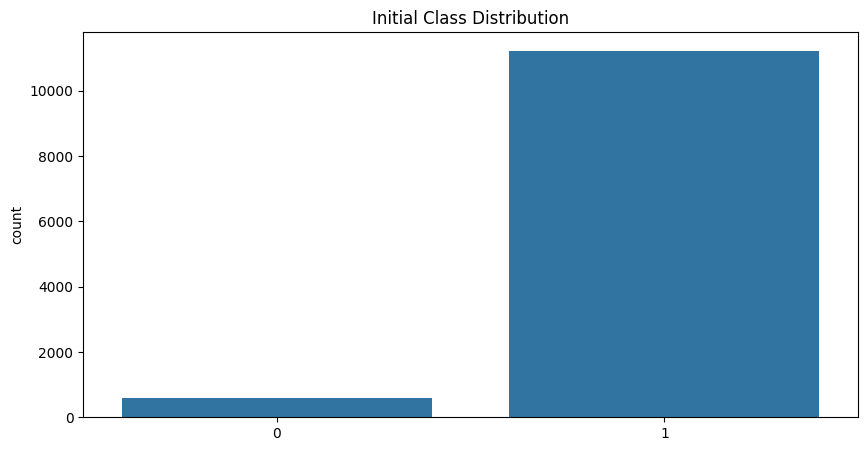

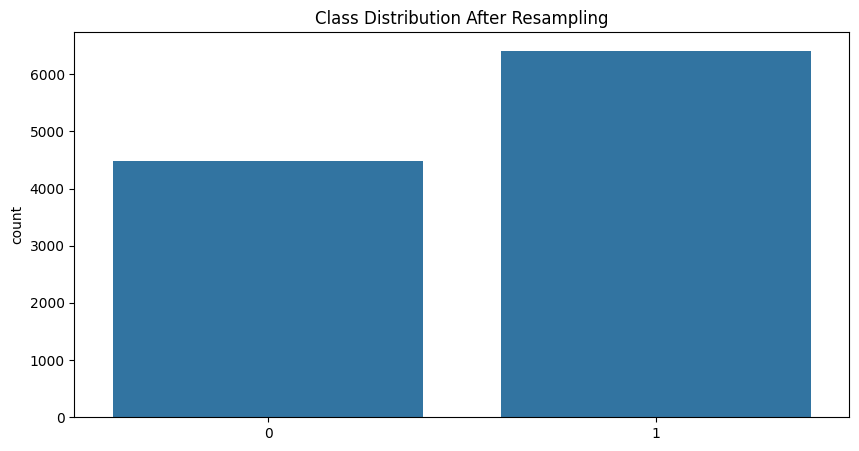

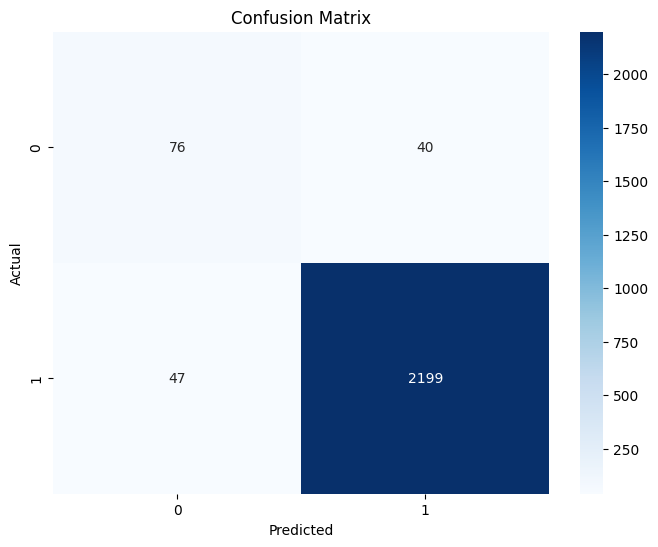

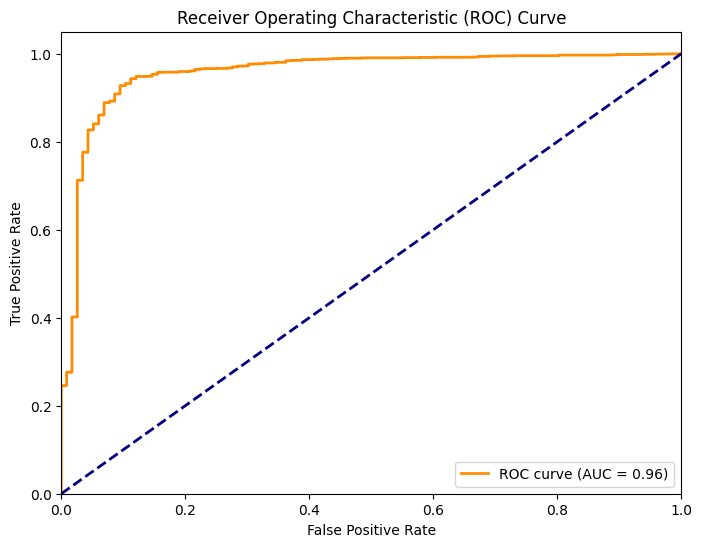


Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.66      0.64       116
           1       0.98      0.98      0.98      2246

    accuracy                           0.96      2362
   macro avg       0.80      0.82      0.81      2362
weighted avg       0.96      0.96      0.96      2362



In [ ]:
# Using count matrix
svm_model, svm_results = train_and_evaluate_model(count_matrix, y, model_type='svm')

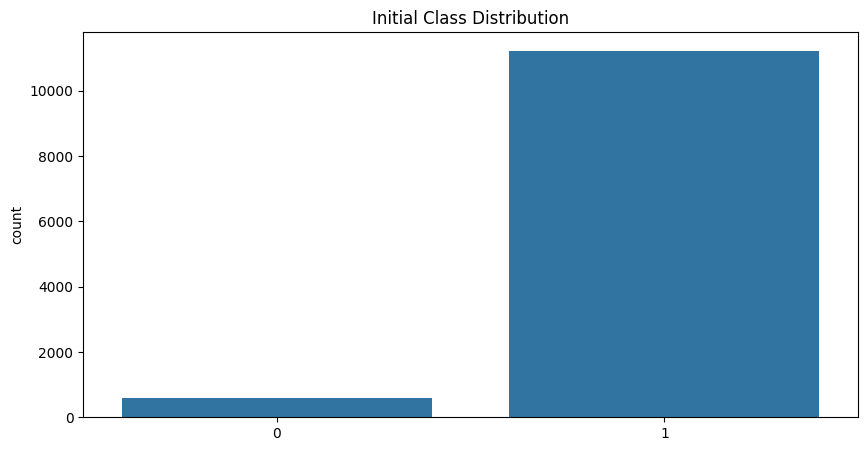

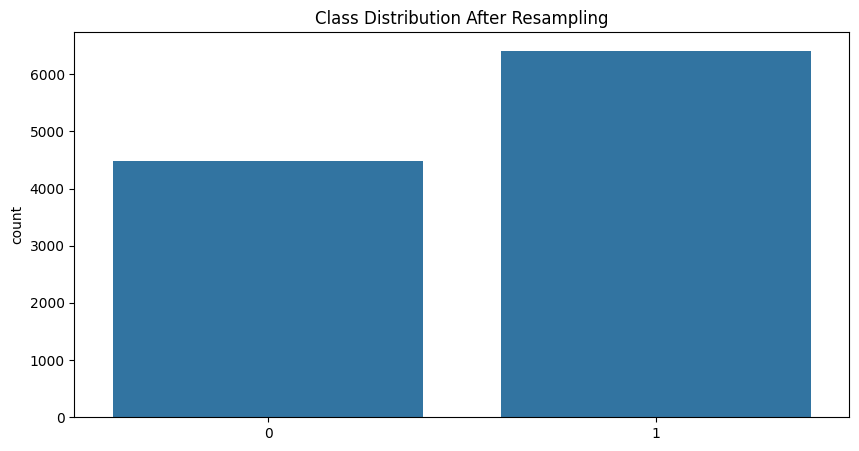

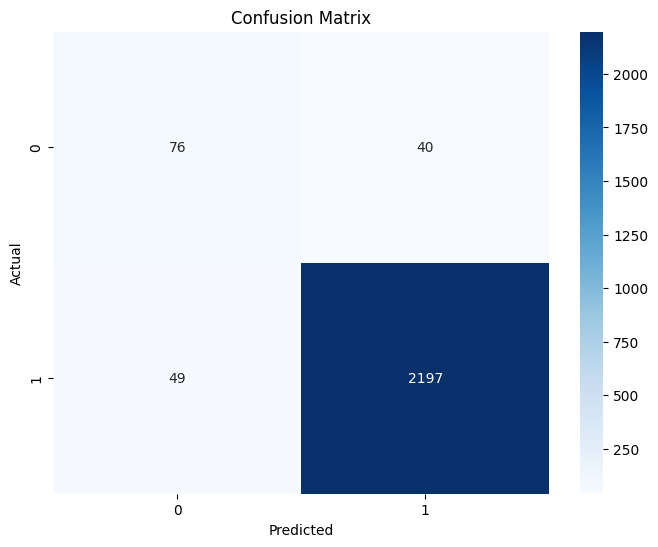

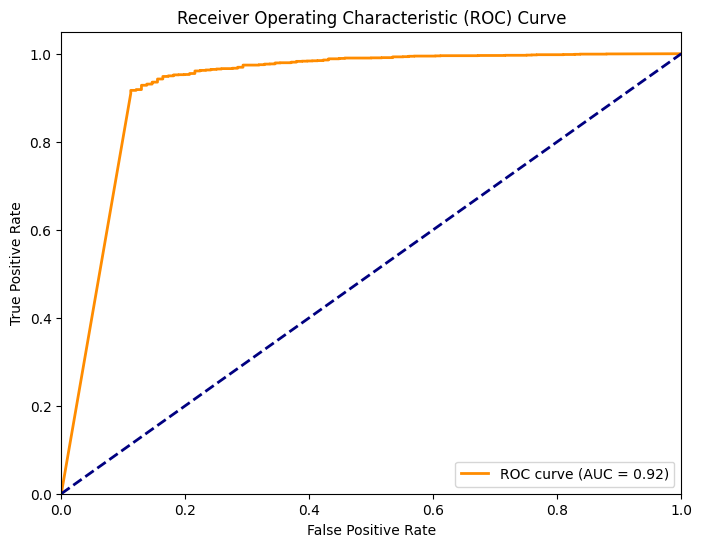


Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.66      0.63       116
           1       0.98      0.98      0.98      2246

    accuracy                           0.96      2362
   macro avg       0.80      0.82      0.81      2362
weighted avg       0.96      0.96      0.96      2362



In [ ]:
# Using tf_idf matrix
svm_model, svm_results = train_and_evaluate_model(tfidf_matrix, y, model_type='svm')

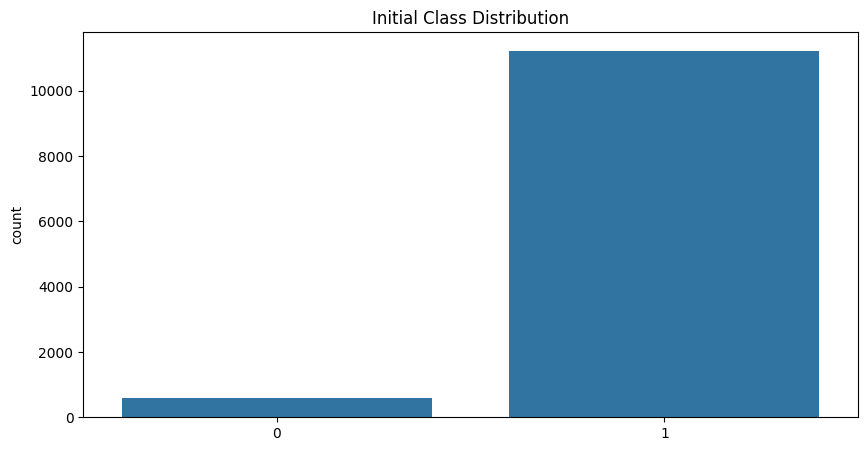

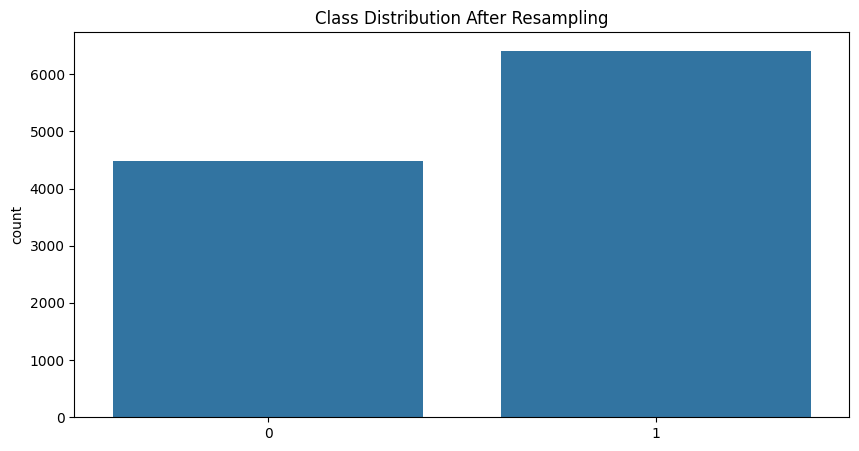

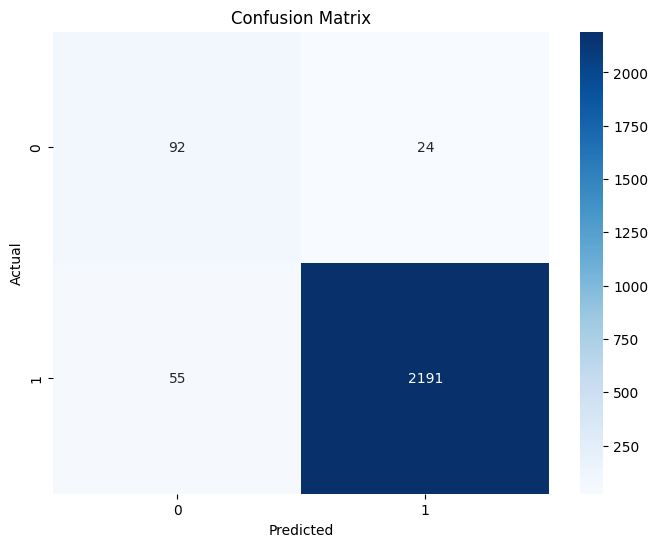

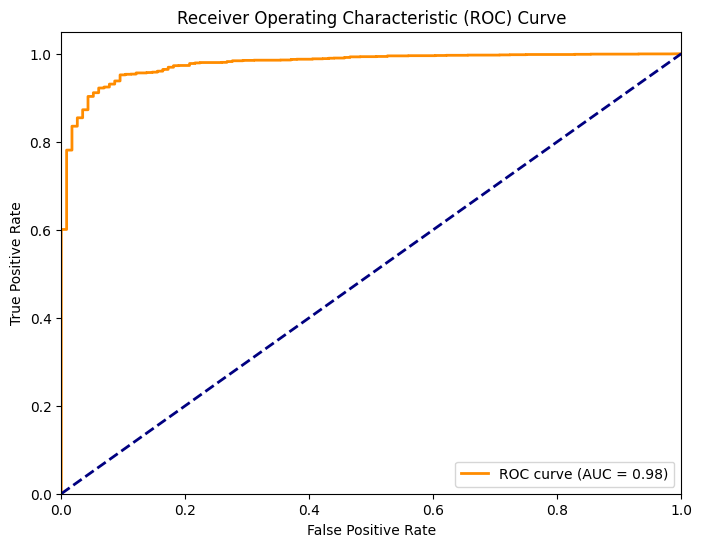


Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.79      0.70       116
           1       0.99      0.98      0.98      2246

    accuracy                           0.97      2362
   macro avg       0.81      0.88      0.84      2362
weighted avg       0.97      0.97      0.97      2362



In [ ]:
# Using glove matrix
svm_model, svm_results = train_and_evaluate_model(glove_matrix, y, model_type='svm')

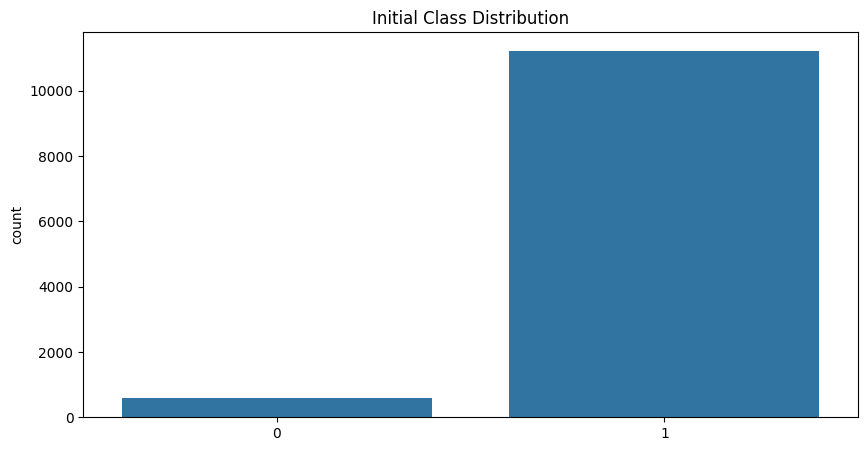

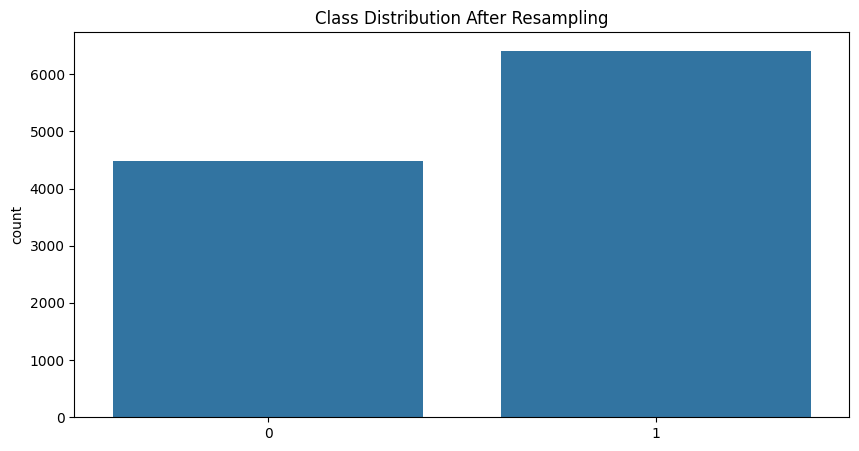

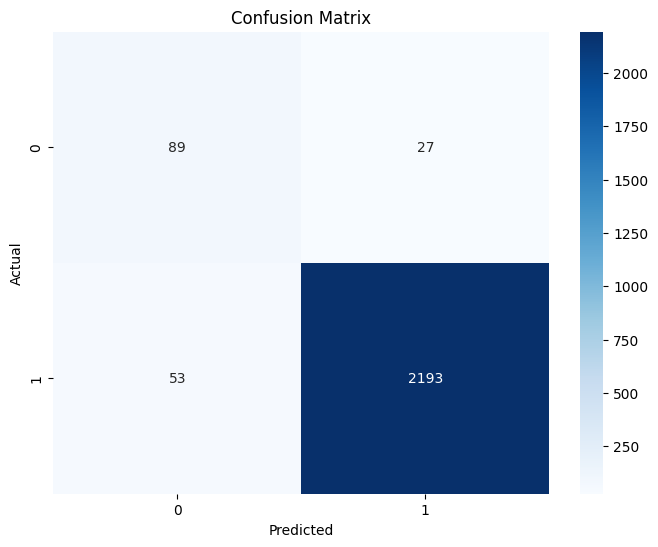

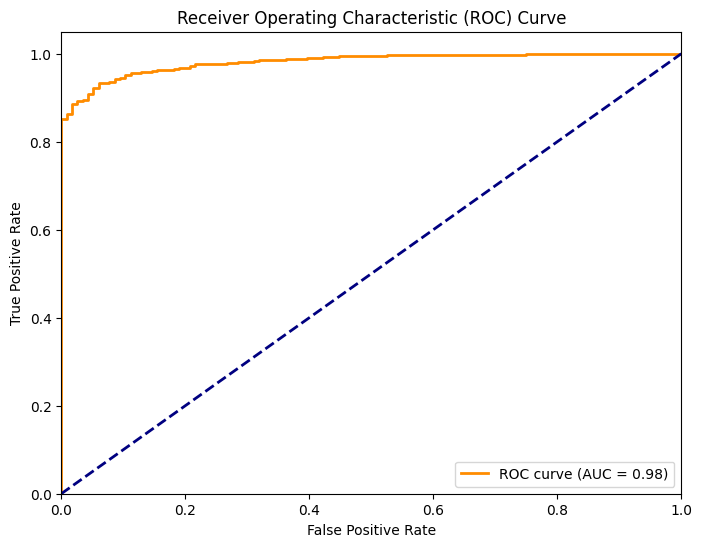


Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.77      0.69       116
           1       0.99      0.98      0.98      2246

    accuracy                           0.97      2362
   macro avg       0.81      0.87      0.84      2362
weighted avg       0.97      0.97      0.97      2362



In [ ]:
# Using w2v matrix
svm_model, svm_results = train_and_evaluate_model(w2v_matrix, y, model_type='svm')

### XGBoost

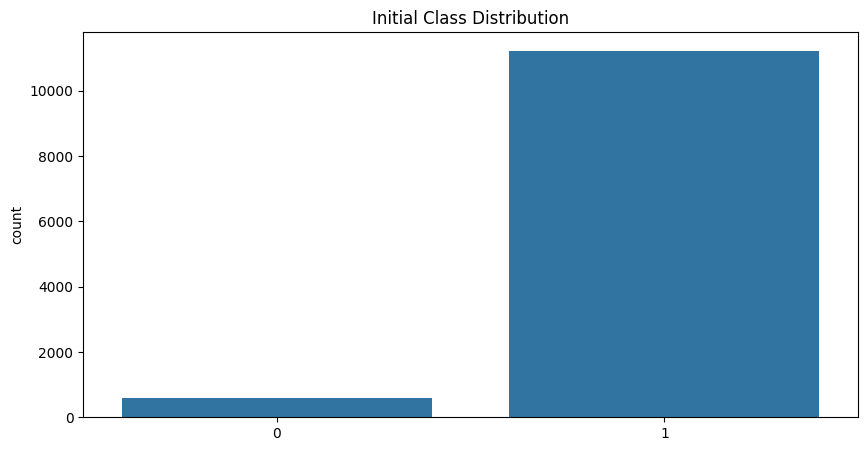

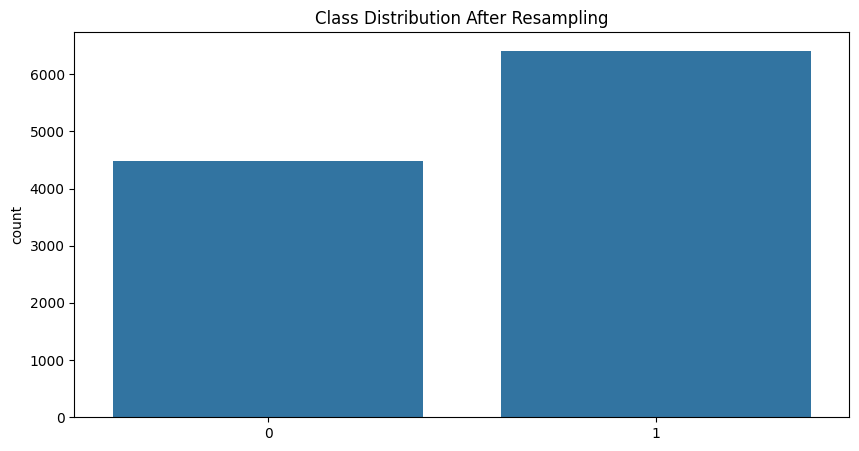

[0]	train-logloss:0.59917	train-error:0.41180	train-auc:0.95863	eval-logloss:0.49643	eval-error:0.04911	eval-auc:0.78733
[100]	train-logloss:0.02726	train-error:0.00642	train-auc:0.99988	eval-logloss:0.06976	eval-error:0.02625	eval-auc:0.98263
[200]	train-logloss:0.01329	train-error:0.00138	train-auc:0.99999	eval-logloss:0.06172	eval-error:0.02413	eval-auc:0.98545
[282]	train-logloss:0.00893	train-error:0.00028	train-auc:1.00000	eval-logloss:0.06141	eval-error:0.02371	eval-auc:0.98553


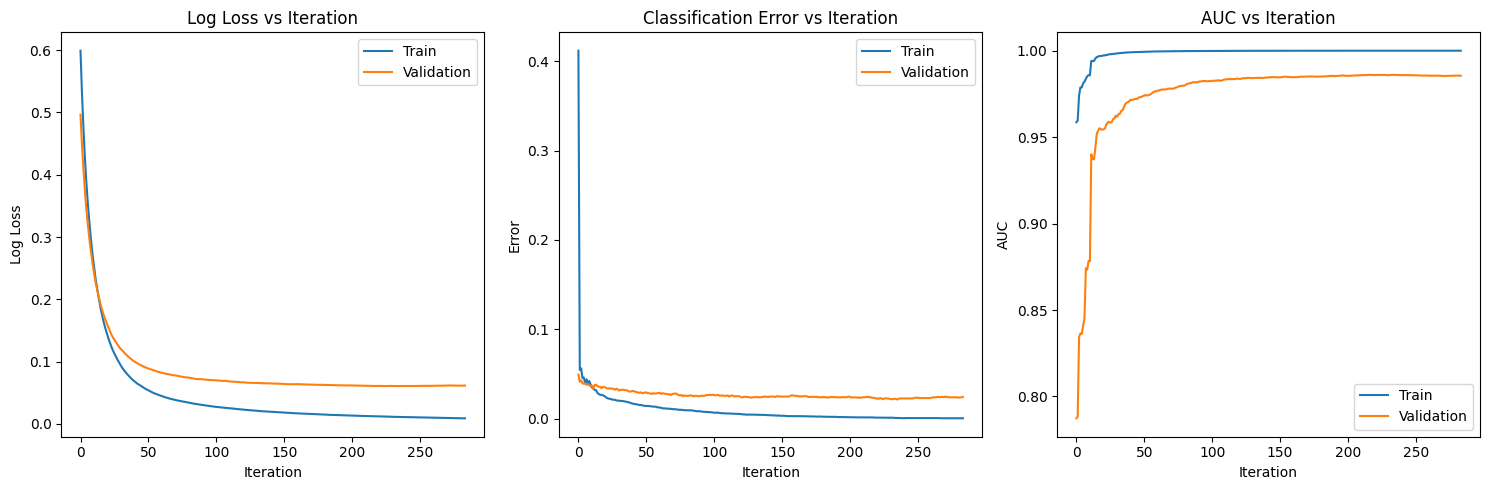

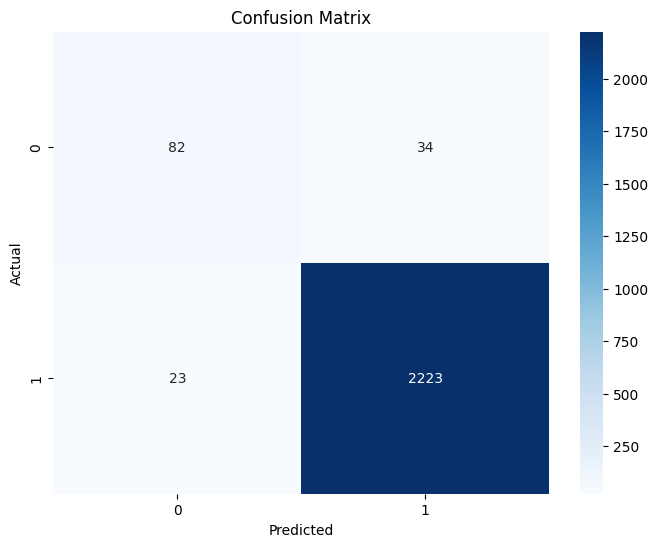

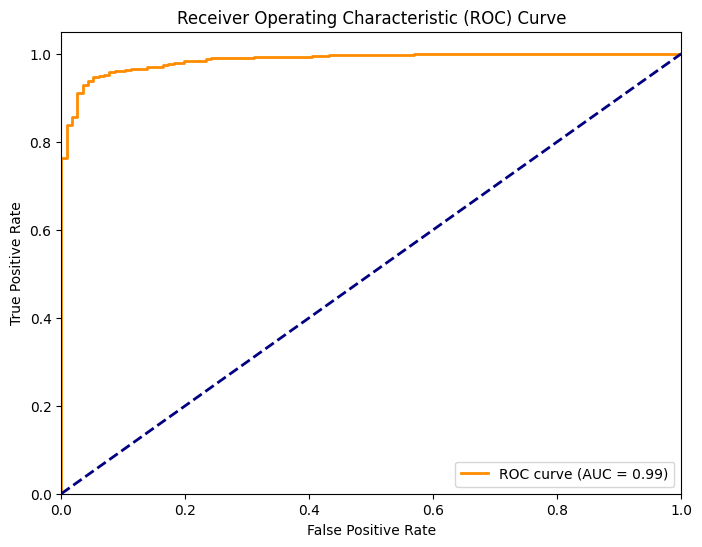


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.71      0.74       116
           1       0.98      0.99      0.99      2246

    accuracy                           0.98      2362
   macro avg       0.88      0.85      0.86      2362
weighted avg       0.97      0.98      0.98      2362



In [ ]:
# Using count matrix
xgb_model, xgb_results = train_and_evaluate_model(count_matrix, y, model_type='xgb')

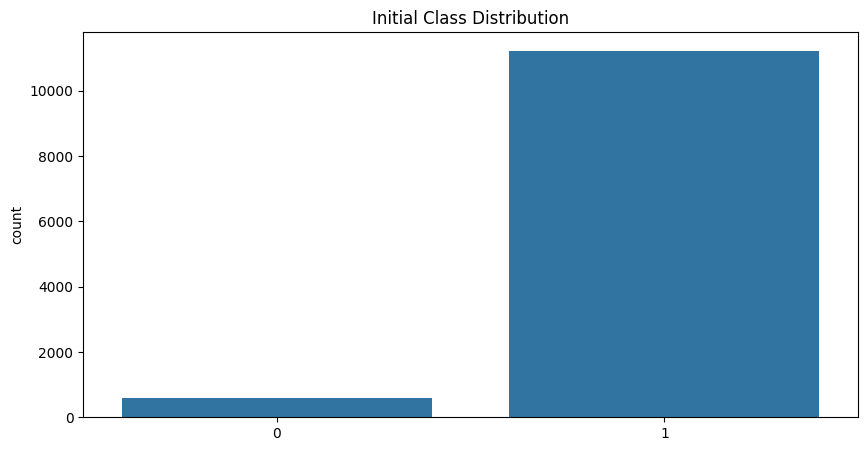

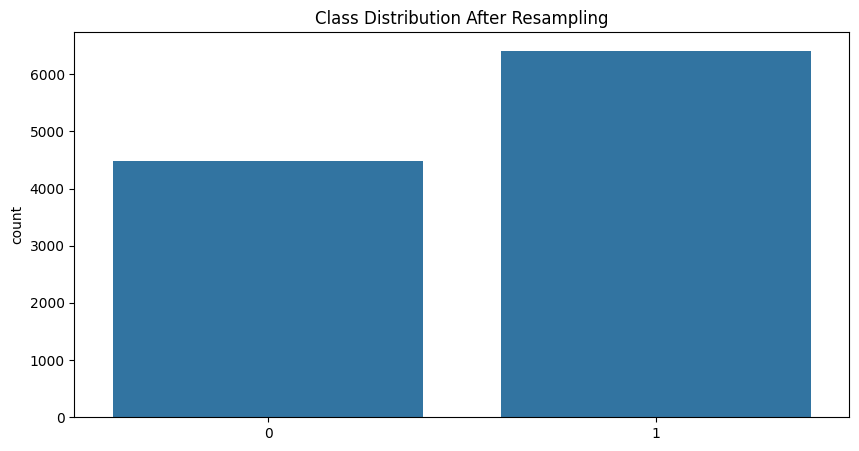

[0]	train-logloss:0.60118	train-error:0.41180	train-auc:0.95518	eval-logloss:0.49929	eval-error:0.04911	eval-auc:0.71704
[100]	train-logloss:0.02924	train-error:0.00725	train-auc:0.99987	eval-logloss:0.07853	eval-error:0.03048	eval-auc:0.98059
[200]	train-logloss:0.01275	train-error:0.00092	train-auc:1.00000	eval-logloss:0.07088	eval-error:0.02667	eval-auc:0.98447
[300]	train-logloss:0.00720	train-error:0.00000	train-auc:1.00000	eval-logloss:0.07069	eval-error:0.02667	eval-auc:0.98452
[325]	train-logloss:0.00643	train-error:0.00000	train-auc:1.00000	eval-logloss:0.07124	eval-error:0.02667	eval-auc:0.98456


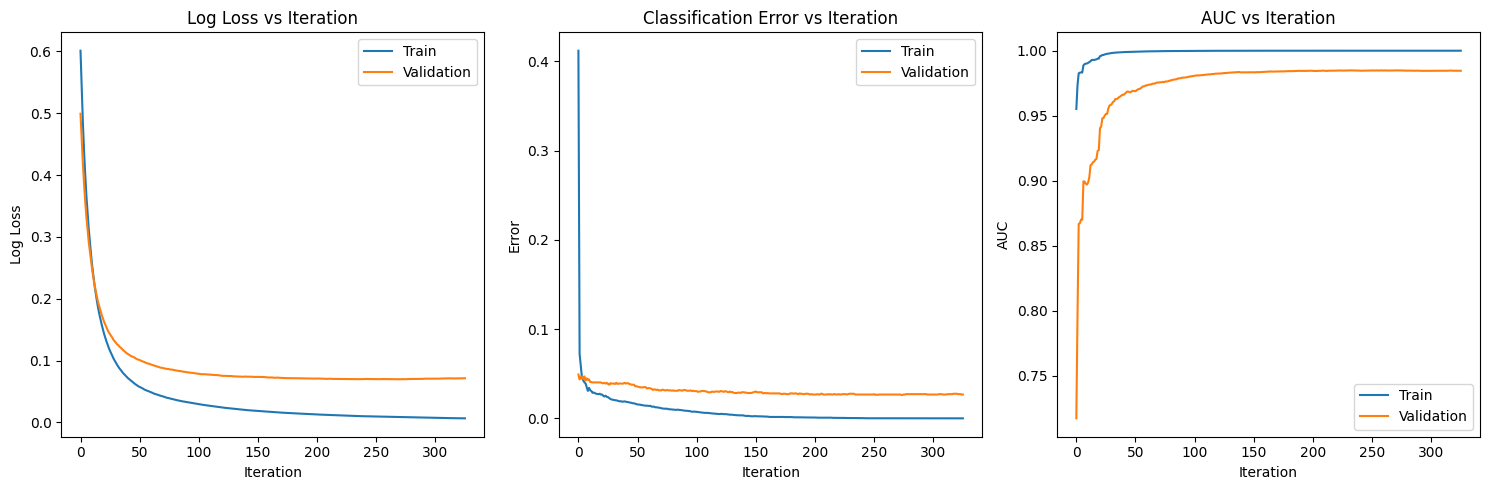

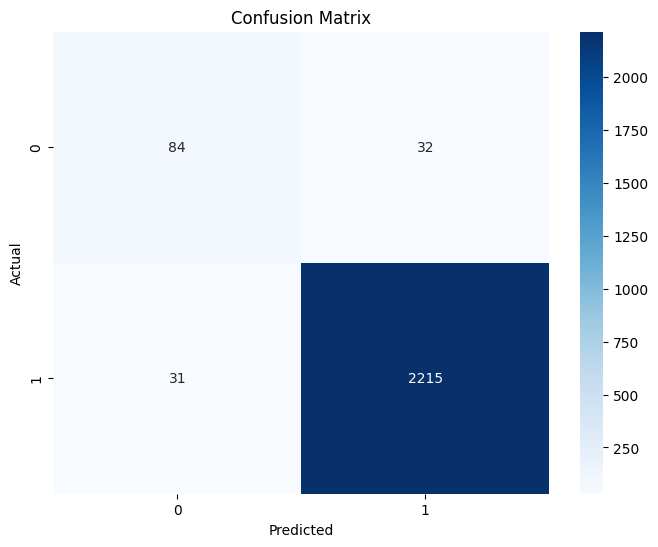

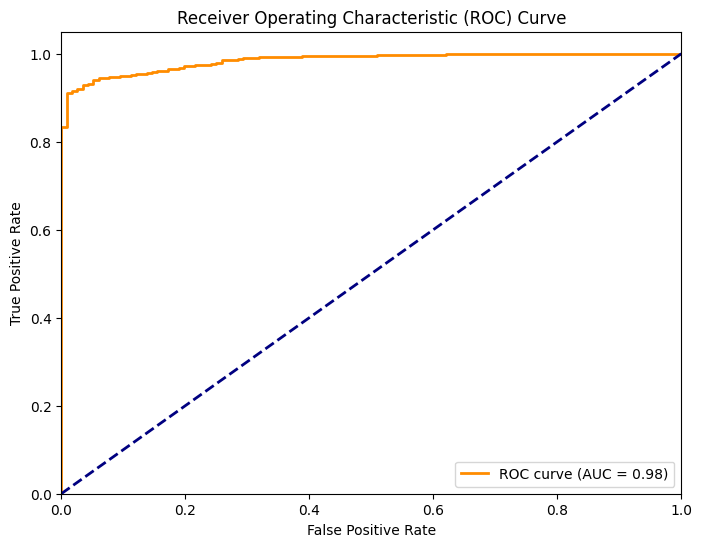


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.72      0.73       116
           1       0.99      0.99      0.99      2246

    accuracy                           0.97      2362
   macro avg       0.86      0.86      0.86      2362
weighted avg       0.97      0.97      0.97      2362



In [ ]:
# Using tfidf matrix
xgb_model, xgb_results = train_and_evaluate_model(tfidf_matrix, y, model_type='xgb')

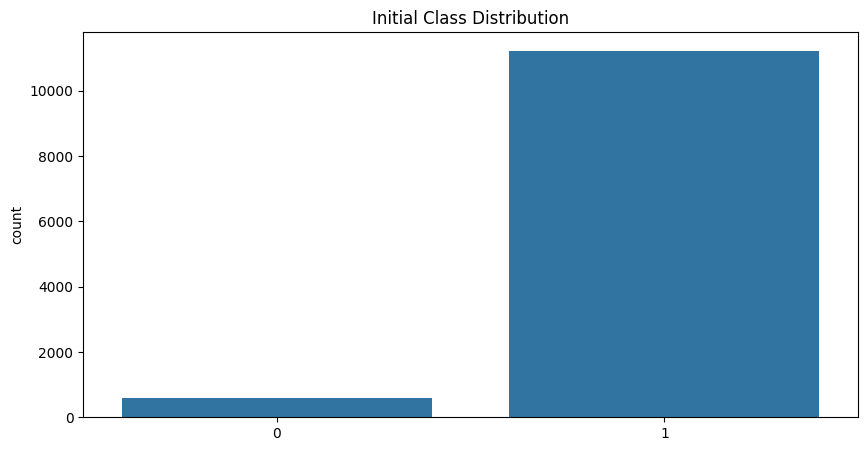

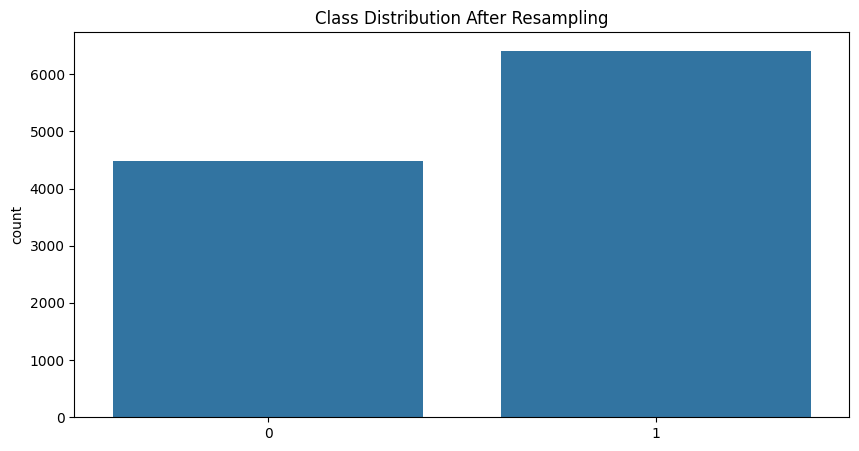

[0]	train-logloss:0.60193	train-error:0.41180	train-auc:0.97125	eval-logloss:0.50012	eval-error:0.04911	eval-auc:0.88949
[100]	train-logloss:0.00579	train-error:0.00000	train-auc:1.00000	eval-logloss:0.08457	eval-error:0.03472	eval-auc:0.98295
[200]	train-logloss:0.00167	train-error:0.00000	train-auc:1.00000	eval-logloss:0.08244	eval-error:0.03133	eval-auc:0.98492
[300]	train-logloss:0.00099	train-error:0.00000	train-auc:1.00000	eval-logloss:0.08315	eval-error:0.03006	eval-auc:0.98564
[400]	train-logloss:0.00073	train-error:0.00000	train-auc:1.00000	eval-logloss:0.08403	eval-error:0.03048	eval-auc:0.98599
[500]	train-logloss:0.00060	train-error:0.00000	train-auc:1.00000	eval-logloss:0.08457	eval-error:0.03091	eval-auc:0.98633
[600]	train-logloss:0.00052	train-error:0.00000	train-auc:1.00000	eval-logloss:0.08527	eval-error:0.03006	eval-auc:0.98649
[631]	train-logloss:0.00050	train-error:0.00000	train-auc:1.00000	eval-logloss:0.08589	eval-error:0.03048	eval-auc:0.98639


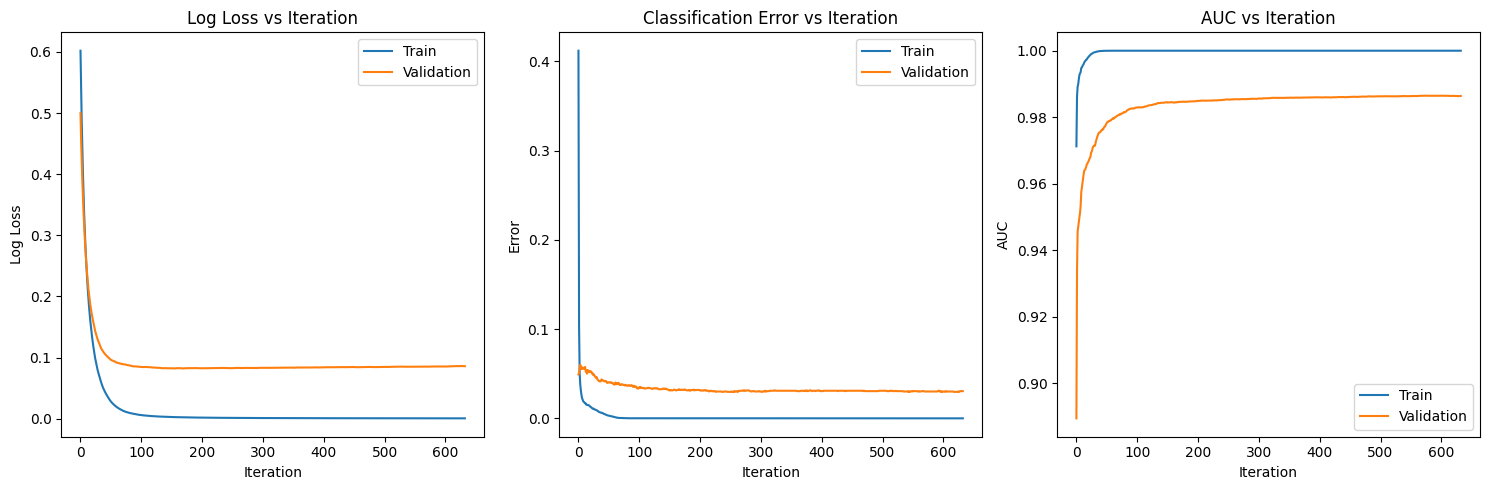

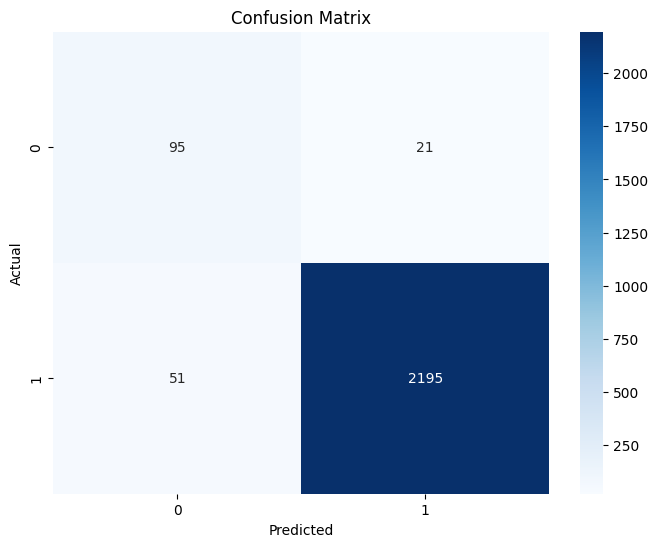

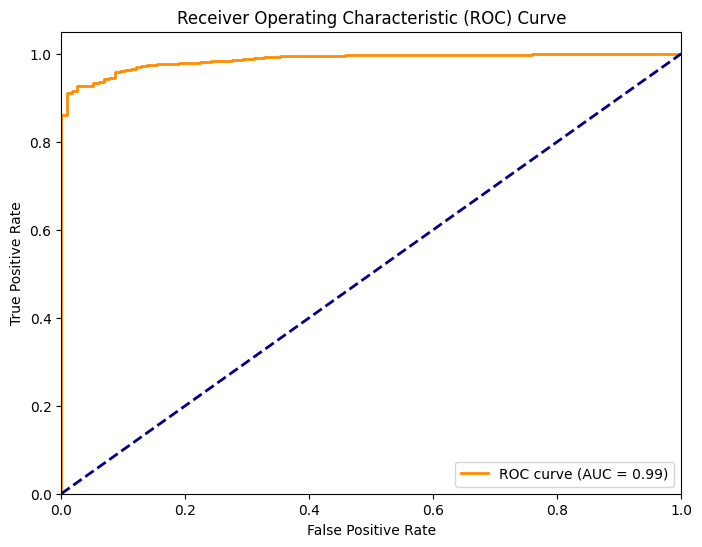


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.82      0.73       116
           1       0.99      0.98      0.98      2246

    accuracy                           0.97      2362
   macro avg       0.82      0.90      0.85      2362
weighted avg       0.97      0.97      0.97      2362



In [ ]:
# Using glove matrix
xgb_model, xgb_results = train_and_evaluate_model(glove_matrix, y, model_type='xgb')

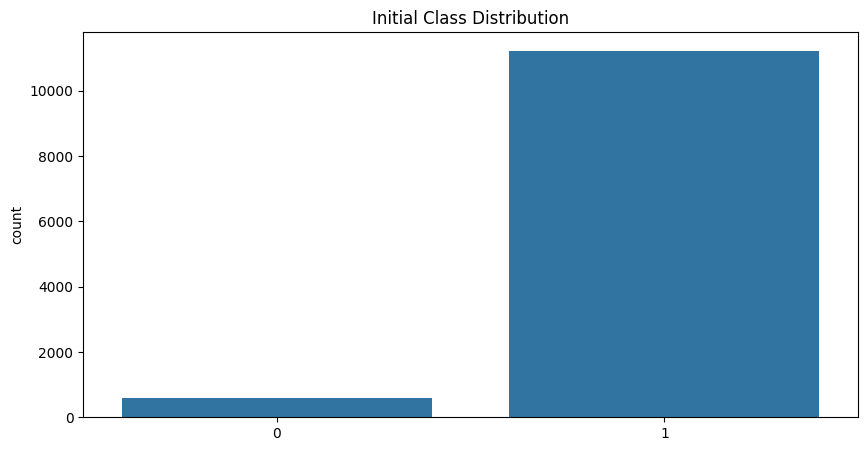

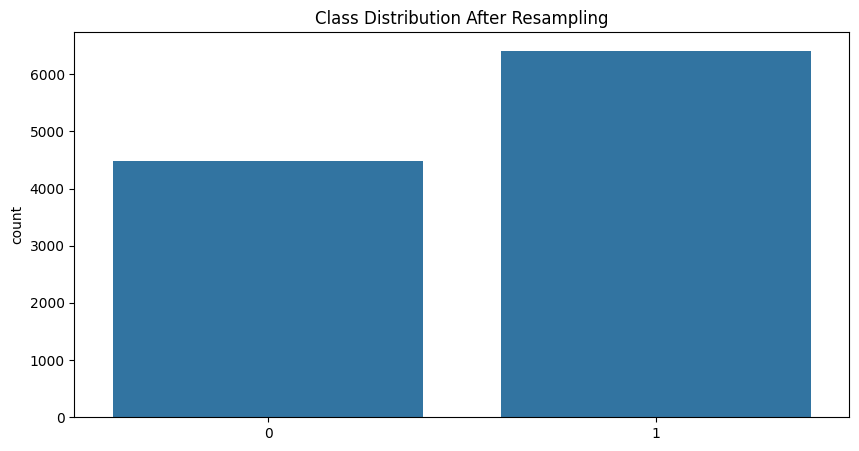

[0]	train-logloss:0.60082	train-error:0.41180	train-auc:0.97212	eval-logloss:0.49832	eval-error:0.04911	eval-auc:0.89698
[100]	train-logloss:0.00524	train-error:0.00000	train-auc:1.00000	eval-logloss:0.09176	eval-error:0.03556	eval-auc:0.98064
[200]	train-logloss:0.00155	train-error:0.00000	train-auc:1.00000	eval-logloss:0.09320	eval-error:0.03302	eval-auc:0.98253
[300]	train-logloss:0.00093	train-error:0.00000	train-auc:1.00000	eval-logloss:0.09374	eval-error:0.03218	eval-auc:0.98343
[400]	train-logloss:0.00069	train-error:0.00000	train-auc:1.00000	eval-logloss:0.09523	eval-error:0.03006	eval-auc:0.98388
[500]	train-logloss:0.00057	train-error:0.00000	train-auc:1.00000	eval-logloss:0.09628	eval-error:0.03006	eval-auc:0.98421
[600]	train-logloss:0.00049	train-error:0.00000	train-auc:1.00000	eval-logloss:0.09708	eval-error:0.02964	eval-auc:0.98447
[700]	train-logloss:0.00044	train-error:0.00000	train-auc:1.00000	eval-logloss:0.09739	eval-error:0.02921	eval-auc:0.98475
[800]	train-loglos

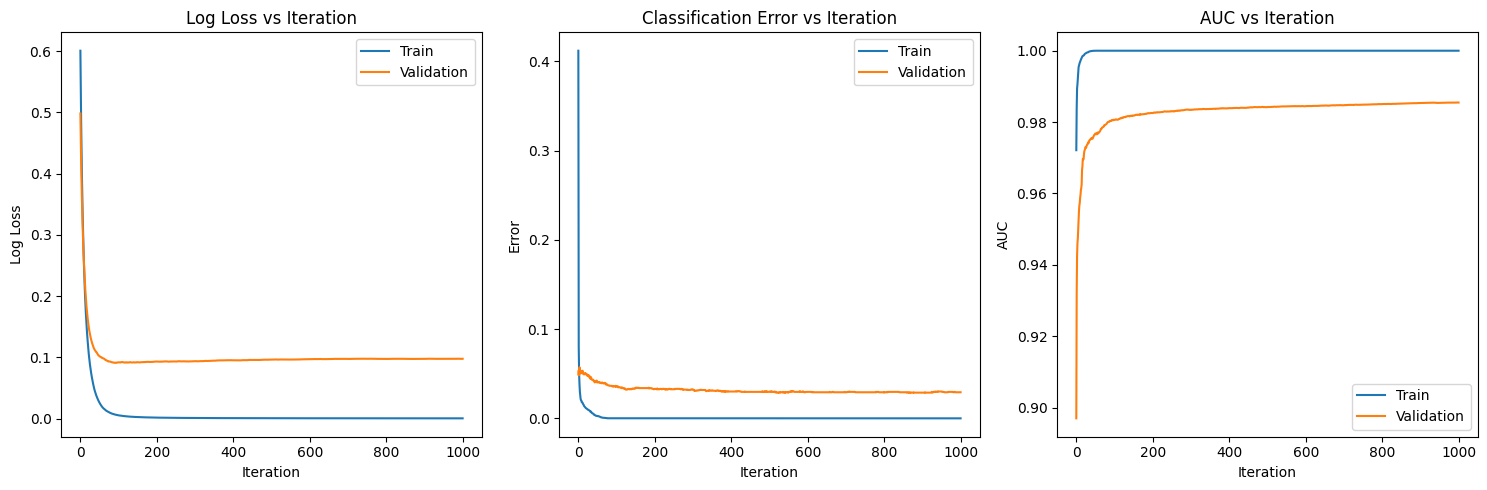

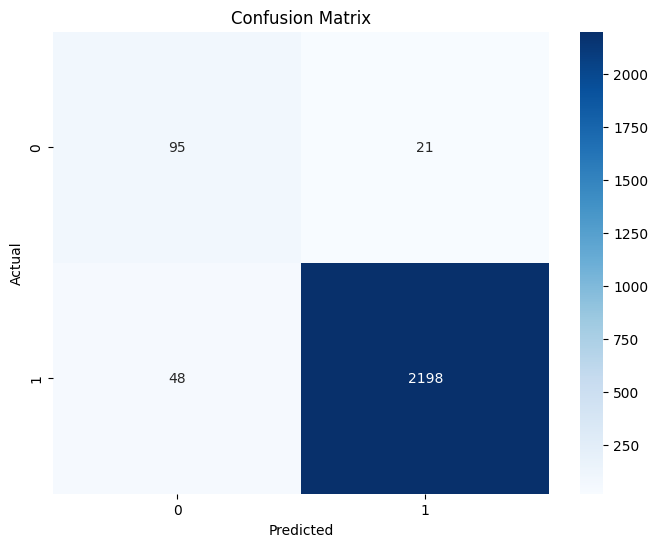

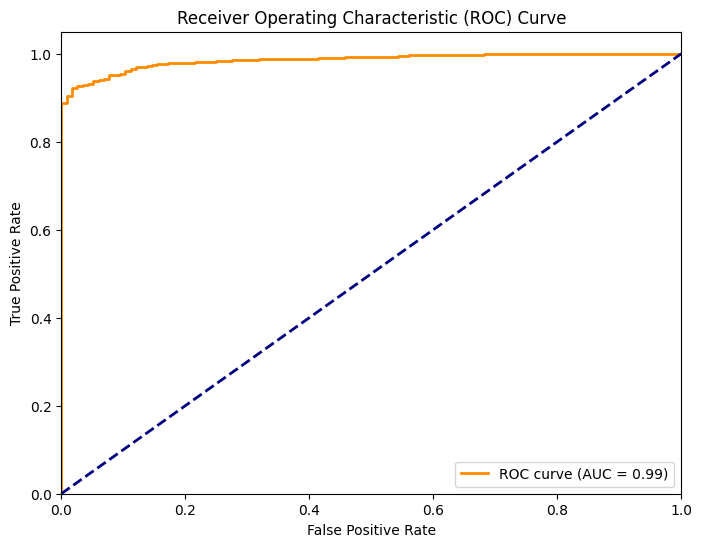


Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.82      0.73       116
           1       0.99      0.98      0.98      2246

    accuracy                           0.97      2362
   macro avg       0.83      0.90      0.86      2362
weighted avg       0.97      0.97      0.97      2362



In [ ]:
# Using word2vec matrix
xgb_model, xgb_results = train_and_evaluate_model(w2v_matrix, y, model_type='xgb')

##### Interpretation of Text Classification Results

**Performance Comparison**:
We evaluated the models based on F1-Score, Precision and Recall. In imbalanced datasets, such as the one we have, accuracy can be misleading as models may achieve high accuracy by simply predicting the majority class. The results of the experiments are summarized below:

| **Algorithm**   | **Feature Extraction** | **F1-Score**   | **Precision**   | **Recall**    |
|-----------------|------------------------|----------------|-----------------|---------------|
| **Random Forest** | Count Vectors        | 75             |  93             |  68           |
|                 | TF-IDF                 | 70             |  80             |  65           |
|                 | GloVe                  | 78             |  75             |  82           |
|                 | Word2Vec               | 78             |  74             |  82           |
| **Support Vector Machine (SVM)** | Count Vectors      | 81 | 80             |  82           |
|                 | TF-IDF                 | 81               | 80            |  82           |
|                 | GloVe                  | 84               | 81            |  88           |
|                 | Word2Vec               | 84               | 81            |  87           |
| **XGBoost**     | Count Vectors          | 86               | 88            |  85           |
|                 | TF-IDF                 | 86               | 86            |  86           |
|                 | GloVe                  | 85               | 90            |  82           |
|                 | Word2Vec               | 86               | 90            |  83           |

**Analysis of Observed Patterns**:

1. **Effectiveness of TF-IDF with SVM**:
    - **Observation**: SVM excels in high-dimensional spaces and is effective with sparse data. TF-IDF enhances this by weighting features according to their importance, allowing SVM to focus on discriminative words that are crucial for sentiment classification.

2. **Performance of Dense Embeddings with XGBoost**:
    - **Observation**:
        - XGBoost performed exceptionally well with dense embeddings, especially Word2Vec, achieving the best performance across all evaluation metrics.
    - **Reasoning**:
        - XGBoost's ability to model complex nonlinear relationships benefits from the semantic information captured in dense embeddings. Word2Vec embeddings encapsulate contextual nuances, and when combined with XGBoost's boosting mechanism, the model effectively differentiates between subtle sentiment cues.

3. **Random Forest's Moderate Performance**:
    - **Observation**:
        - Random Forest showed moderate improvements overall with dense embeddings, but did not outperform the other algorithms.
    - **Reasoning**:
        - Random Forest may struggle with high-dimensional sparse data due to its reliance on decision trees, which can become complex and overfit. While dense embeddings reduced dimensionality, Random Forest still may not capture complex patterns as effectively as XGBoost or SVM.

4. **Impact of Feature Representation**:
    - **Sparse vs. Dense Features**:
        - Sparse features (Count Vectors and TF-IDF) worked well with algorithms that handle high-dimensional data, like SVM.
        - Dense features (GloVe and Word2Vec) were beneficial for algorithms that leverage feature interactions and nonlinear relationships, like XGBoost.


***

## <center>Task 5: Using Pre-trained Vectors</center>

 For Task 5, we explored the use of BERT (Bidirectional Encoder Representations from Transformers) as a pre-trained contextual embedding for sentiment analysis. The goal was to compare the performance of BERT embeddings with the best combinations from Task 4 and to assess the effectiveness of deep learning models in this context.

Steps Undertaken:

1. Selection of BERT:
    - Chose BERT-base-uncased model for generating contextual embeddings due to its strong performance in NLP tasks and ability to capture deep contextual relationships.

2. Embedding Generation:
    - Processed the cleaned review texts using BERT's tokenizer.
    - Generated embeddings by extracting the hidden state of the [CLS] token, resulting in a 768-dimensional vector for each review.

3. Comparison with Best Models from Task 4:
    - Integrated BERT embeddings with the best-performing algorithms from Task 4:
        - Random Forest (previously best with GloVe)
        - Support Vector Machine (SVM) (previously best with GloVe)
        - XGBoost (previously best with Word2Vec)
    - Trained and evaluated these algorithms using the BERT embeddings.

4. Implementation of a Neural Network:
    - Designed a simple feedforward neural network with:
        - Input Layer: 128 neurons corresponding to BERT embeddings.
        - Hidden Layers: One dense layers with ReLU activation and dropout layer to prevent overfitting.
        - Output Layer: Sigmoid activation for binary classification.
    - Trained the neural network on BERT embeddings and evaluated its performance.

5. Performance Evaluation:
    - Compared the performance of models using macro average F1-Score, Precision, and Recall.
    - Assessed the impact of BERT embeddings and deep learning models on classification performance.

In [9]:
df = pd.read_csv("/content/drive/MyDrive/NLP Coursework - Group D/Data/labelled_data.csv")

In [10]:
df['sentiment'].value_counts()

sentiment
positive    11225
negative      581
Name: count, dtype: int64

In [11]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
y = df['sentiment'].tolist()

In [14]:
# Load BERT tokenizer and model
model_name = 'bert-base-uncased'  # You can use a different BERT model if needed
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)


In [15]:
# Ensure GPU is used if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

cuda


In [16]:
# Function to get embeddings for a single review
def get_embedding(text):
    # Tokenize the text
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Get the embeddings from BERT
    with torch.no_grad():
        outputs = model(**inputs)

    # Use the [CLS] token's embedding as the sentence embedding
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    return cls_embedding


In [17]:
gc.collect()

89

In [18]:
X_text = df['review_text'].tolist()

In [19]:
# Extract embeddings for all reviews
embeddings = []
for review in X_text:
    embedding = get_embedding(review)
    embeddings.append(embedding)


In [20]:
# Convert embeddings to a DataFrame
embeddings_df = pd.DataFrame(embeddings)
embeddings_df.to_csv("/content/drive/MyDrive/NLP Coursework - Group D/Data/Preprocessed/bert_embeddings.csv", index=False)  # Save embeddings to a CSV file

embeddings_filepath = "/content/drive/MyDrive/NLP Coursework - Group D/Data/Preprocessed/bert_embeddings.npy"
np.save(embeddings_filepath, embeddings)

print("BERT embeddings extracted and saved!")

BERT embeddings extracted and saved!


In [21]:
embeddings = np.load("/content/drive/MyDrive/NLP Coursework - Group D/Data/Preprocessed/bert_embeddings.npy")

In [33]:
embeddings.shape

(11806, 768)

### Comparing with Non-DL Algorithms

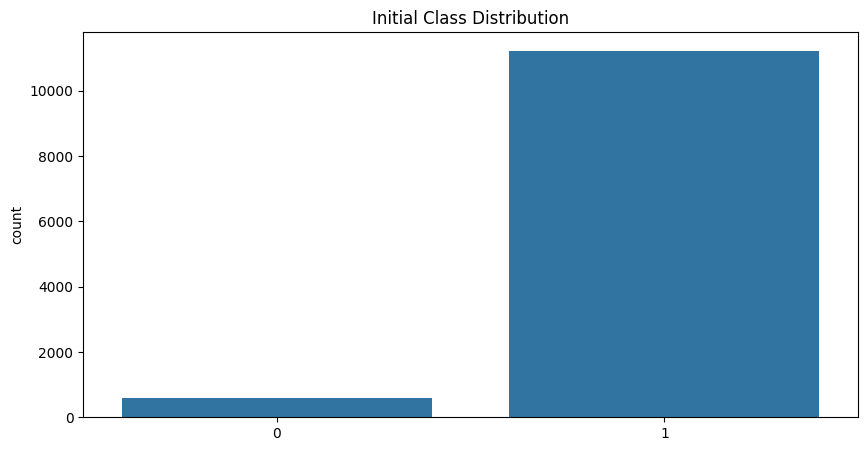

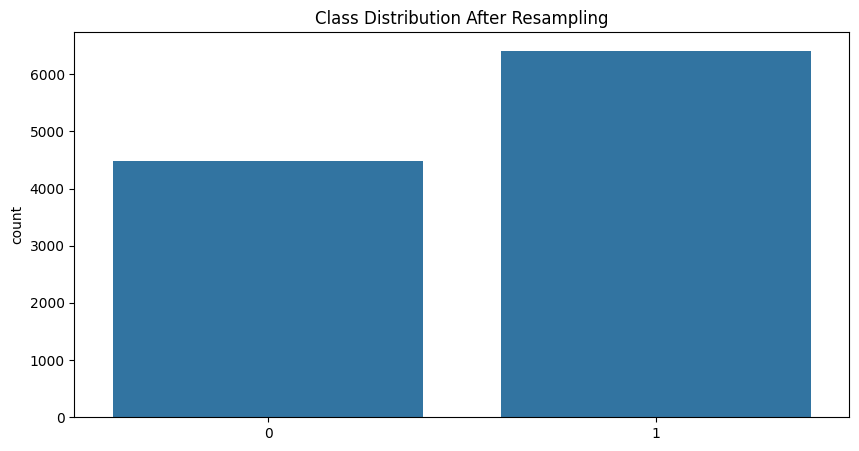

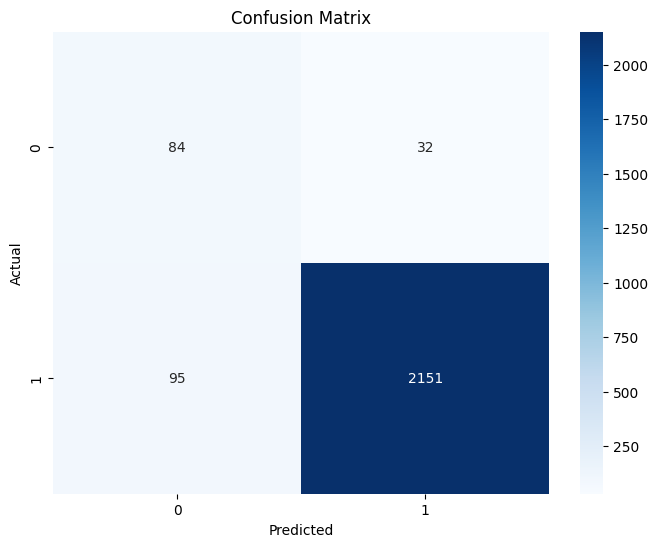

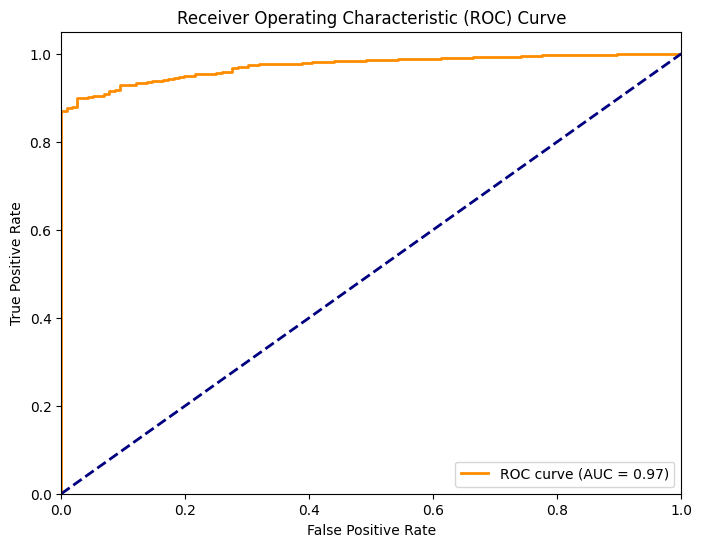


Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.72      0.57       116
           1       0.99      0.96      0.97      2246

    accuracy                           0.95      2362
   macro avg       0.73      0.84      0.77      2362
weighted avg       0.96      0.95      0.95      2362



In [24]:
rf_model, rf_results = train_and_evaluate_model(embeddings, y, model_type='rf')

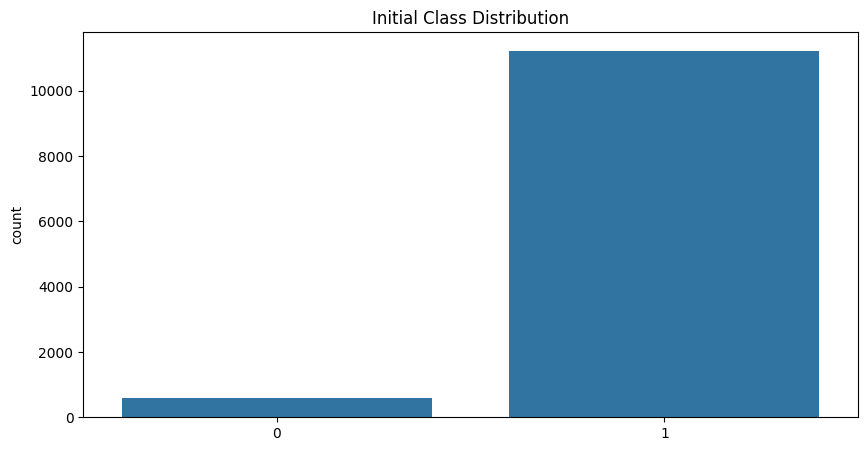

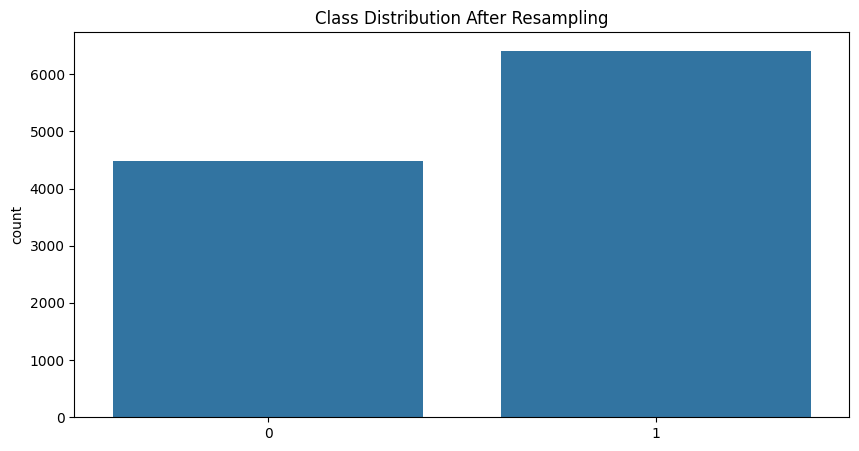

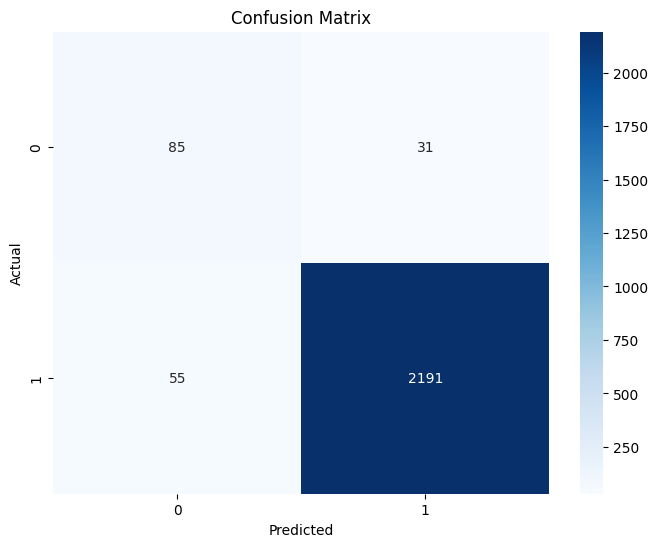

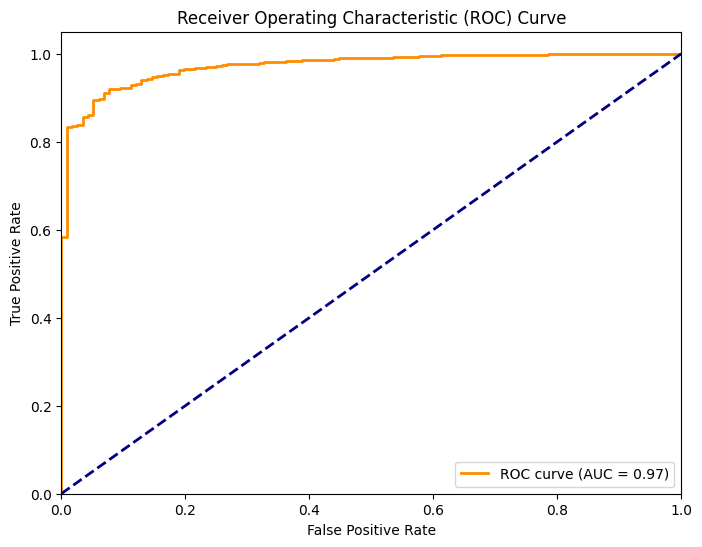


Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.73      0.66       116
           1       0.99      0.98      0.98      2246

    accuracy                           0.96      2362
   macro avg       0.80      0.85      0.82      2362
weighted avg       0.97      0.96      0.97      2362



In [25]:
svm_model, svm_results = train_and_evaluate_model(embeddings, y, model_type='svm')

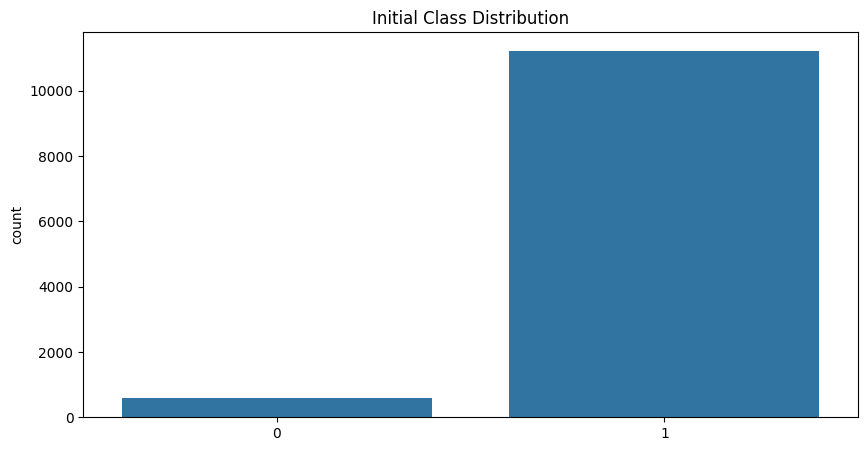

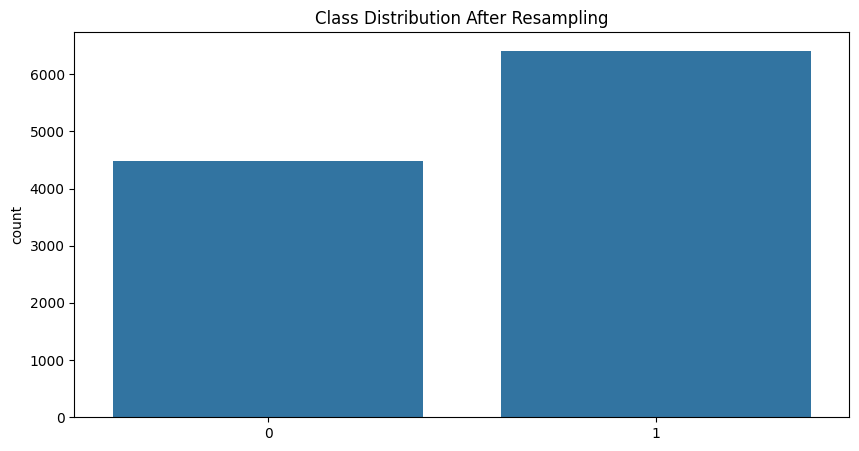

[0]	train-logloss:0.60282	train-error:0.41180	train-auc:0.96078	eval-logloss:0.49942	eval-error:0.04911	eval-auc:0.90145
[100]	train-logloss:0.00663	train-error:0.00000	train-auc:1.00000	eval-logloss:0.09270	eval-error:0.04022	eval-auc:0.97879
[200]	train-logloss:0.00168	train-error:0.00000	train-auc:1.00000	eval-logloss:0.08900	eval-error:0.03599	eval-auc:0.98191
[300]	train-logloss:0.00094	train-error:0.00000	train-auc:1.00000	eval-logloss:0.08984	eval-error:0.03345	eval-auc:0.98314
[400]	train-logloss:0.00069	train-error:0.00000	train-auc:1.00000	eval-logloss:0.09005	eval-error:0.03260	eval-auc:0.98362
[500]	train-logloss:0.00056	train-error:0.00000	train-auc:1.00000	eval-logloss:0.09155	eval-error:0.03091	eval-auc:0.98389
[600]	train-logloss:0.00049	train-error:0.00000	train-auc:1.00000	eval-logloss:0.09157	eval-error:0.03133	eval-auc:0.98427
[700]	train-logloss:0.00044	train-error:0.00000	train-auc:1.00000	eval-logloss:0.09187	eval-error:0.03006	eval-auc:0.98451
[800]	train-loglos

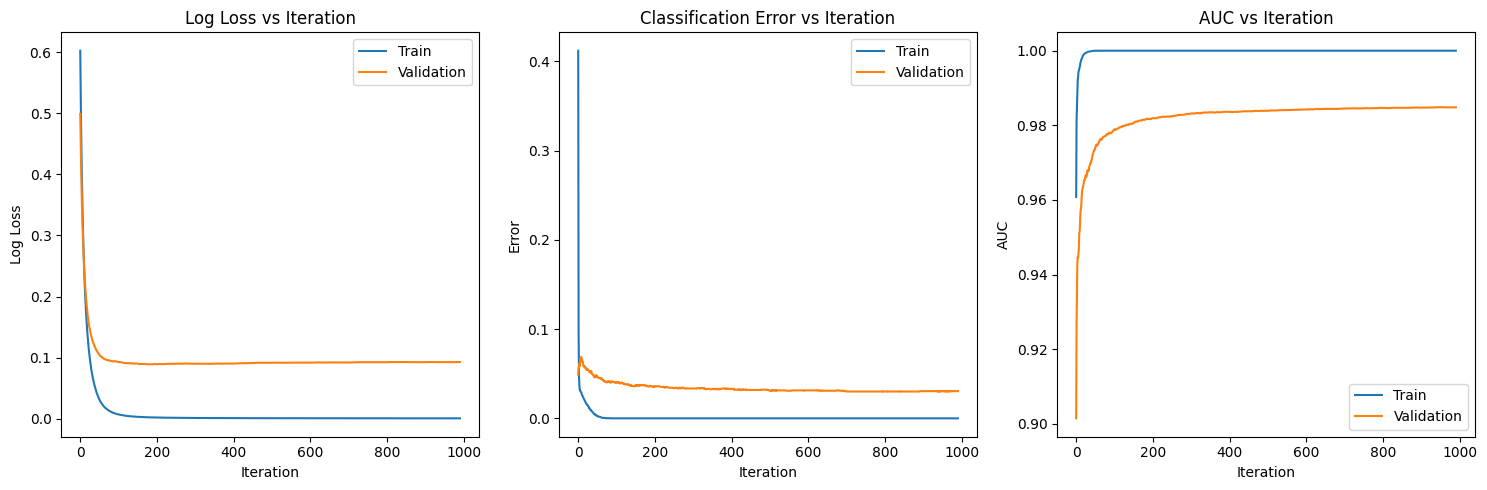

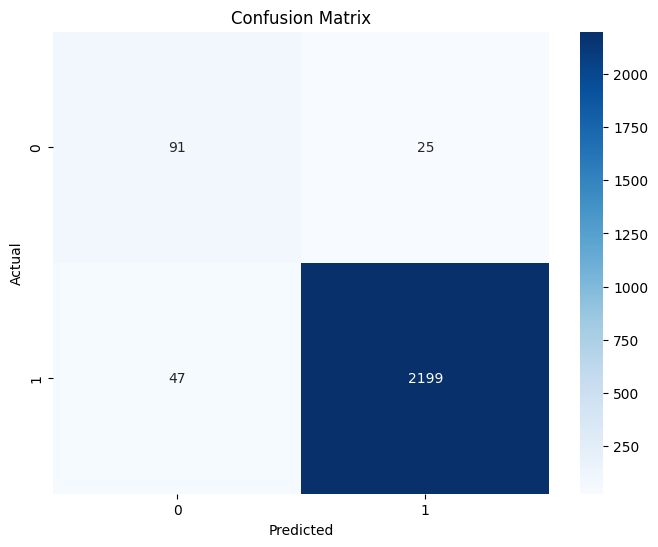

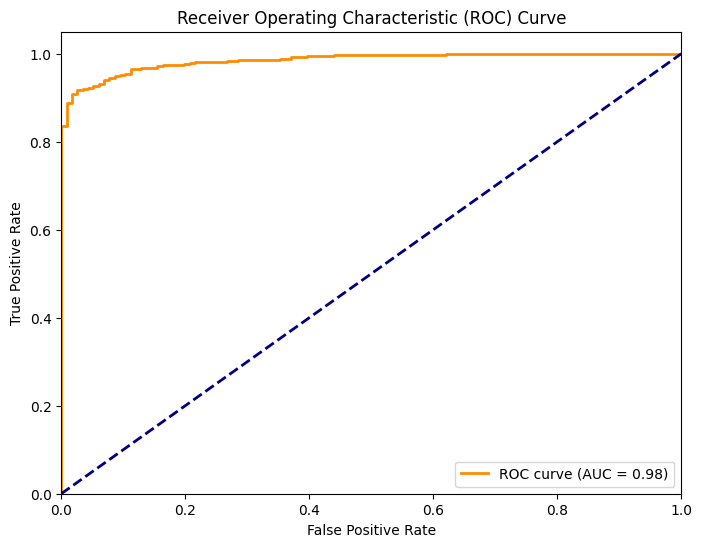


Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.78      0.72       116
           1       0.99      0.98      0.98      2246

    accuracy                           0.97      2362
   macro avg       0.82      0.88      0.85      2362
weighted avg       0.97      0.97      0.97      2362



In [26]:
xgb_model, xgb_results = train_and_evaluate_model(embeddings, y, model_type='xgb')

**Comparison**

| **Algorithm**   | **Feature Extraction** | **F1-Score**   | **Precision**   | **Recall**    |
|-----------------|------------------------|----------------|-----------------|---------------|
| **Random Forest**  | GloVe                  | 78             |  75             |  82           |
|                 | BERT               | 77             |  73             |  84           |
| **Support Vector Machine (SVM)** | GloVe                  | 84               | 81            |  88           |
|                 | BERT               | 82               | 80            |  85           |
| **XGBoost**   | Word2Vec               | 86               | 90            |  83           |
| | BERT  | 85  |  82  |  88  |

**Summary of Findings**:

- GloVe appears to be the best embedding for Random Forest and SVM, as it yields higher F1-Score, Precision, and Recall compared to BERT for these models.

- Word2Vec is the optimal choice for XGBoost, providing the highest F1-Score and Precision among the embeddings tested.

- BERT does not outperform GloVe or Word2Vec across all metrics for the models tested, although it provides a higher Recall for Random Forest and XGBoost.

### Deep Learning Algorithm

In [27]:
# Convert data to tensors
X_train, X_test, y_train, y_test = train_test_split(
        embeddings, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

# Convert to dense format if using sparse matrices
if hasattr(X_train, 'toarray'):
    X_train = X_train.toarray()
    X_test = X_test.toarray()

# Apply resampling
resampling = create_resampling_pipeline()
X_train_resampled, y_train_resampled = resampling.fit_resample(X_train, y_train)

train_data = TensorDataset(torch.tensor(X_train_resampled, dtype=torch.float32), torch.tensor(y_train_resampled))
test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test))

In [28]:
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)
test_loader = DataLoader(test_data, sampler=SequentialSampler(test_data), batch_size=batch_size)

In [29]:
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim):
        super(SentimentClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

def train_and_plot_losses(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    # Lists to store losses
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0

        for batch in train_loader:
            batch_inputs, batch_labels = batch
            batch_labels = batch_labels.type(torch.FloatTensor).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        # Average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation/Test phase
        model.eval()
        total_test_loss = 0

        with torch.no_grad():
            for batch in test_loader:
                batch_inputs, batch_labels = batch
                batch_labels = batch_labels.type(torch.FloatTensor).unsqueeze(1)

                outputs = model(batch_inputs)
                loss = criterion(outputs, batch_labels)
                total_test_loss += loss.item()

        # Average test loss for the epoch
        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

    # Plotting the losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    plt.title('Training and Test Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_losses, test_losses

In [30]:
input_dim = embeddings.shape[1]
model = SentimentClassifier(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

Epoch 1/100, Training Loss: 0.5842, Test Loss: 0.4105
Epoch 2/100, Training Loss: 0.4214, Test Loss: 0.2893
Epoch 3/100, Training Loss: 0.3205, Test Loss: 0.2495
Epoch 4/100, Training Loss: 0.2651, Test Loss: 0.2068
Epoch 5/100, Training Loss: 0.2310, Test Loss: 0.1829
Epoch 6/100, Training Loss: 0.2086, Test Loss: 0.1653
Epoch 7/100, Training Loss: 0.1907, Test Loss: 0.1624
Epoch 8/100, Training Loss: 0.1782, Test Loss: 0.1584
Epoch 9/100, Training Loss: 0.1681, Test Loss: 0.1481
Epoch 10/100, Training Loss: 0.1600, Test Loss: 0.1490
Epoch 11/100, Training Loss: 0.1537, Test Loss: 0.1555
Epoch 12/100, Training Loss: 0.1480, Test Loss: 0.1398
Epoch 13/100, Training Loss: 0.1428, Test Loss: 0.1304
Epoch 14/100, Training Loss: 0.1383, Test Loss: 0.1383
Epoch 15/100, Training Loss: 0.1350, Test Loss: 0.1317
Epoch 16/100, Training Loss: 0.1317, Test Loss: 0.1334
Epoch 17/100, Training Loss: 0.1290, Test Loss: 0.1273
Epoch 18/100, Training Loss: 0.1266, Test Loss: 0.1327
Epoch 19/100, Train

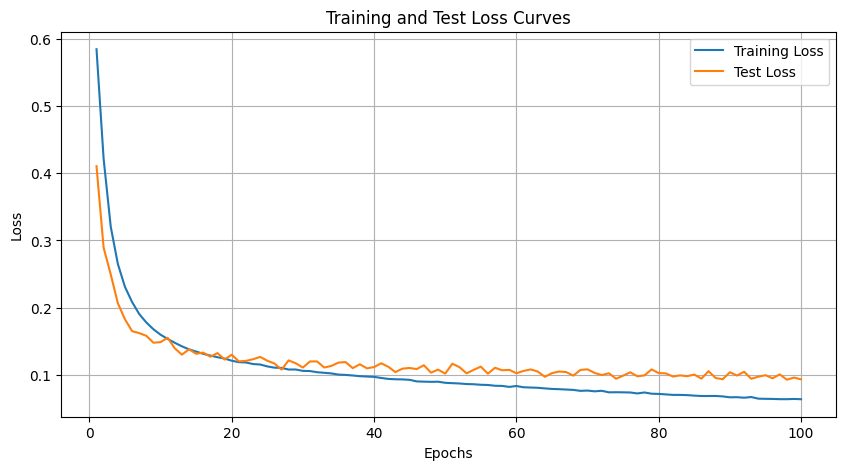

In [31]:
train_losses, test_losses = train_and_plot_losses(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    num_epochs=100
)

In [32]:
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch_inputs, batch_labels = batch
        outputs = model(batch_inputs)
        preds = (outputs >= 0.5).int()
        predictions.extend(preds.squeeze().tolist())
        true_labels.extend(batch_labels.tolist())

print("Deep Learning Model Performance with BERT Embeddings:")
print(classification_report(true_labels, predictions))

Deep Learning Model Performance with BERT Embeddings:
              precision    recall  f1-score   support

           0       0.58      0.89      0.70       116
           1       0.99      0.97      0.98      2246

    accuracy                           0.96      2362
   macro avg       0.79      0.93      0.84      2362
weighted avg       0.97      0.96      0.97      2362



**Interpretation**

1. Comparison Results:

| **Algorithm**   | **Feature Extraction** | **F1-Score**   | **Precision**   | **Recall**    |
|-----------------|------------------------|----------------|-----------------|---------------|
| **Random Forest** | BERT               | 77             |  73             |  84           |
| **Support Vector Machine (SVM)**| BERT               | 82               | 80            |  85           |
| **XGBoost** | BERT  | 85  |  82  |  88  |
| **Neural Network**  | BERT | 84 | 79 | 93 |



2. Justification for Using BERT:
    - Contextual Understanding:
        - BERT generates context-dependent embeddings, allowing the same word to have different representations based on its usage in a sentence. This is crucial for sentiment analysis, where context can alter sentiment polarity.
    - Bidirectional Encoding:
        - Processes text in both forward and backward directions, capturing dependencies from both past and future tokens.
    - Proven Effectiveness:
        - BERT has achieved state-of-the-art results in various NLP tasks, making it a strong candidate for improving sentiment classification performance.

3. Analysis of Results:
    - Impact of BERT Embeddings on Traditional Models:

        - Random Forest: BERT embeddings did not significantly improve performance for Random Forest. The complex, high-dimensional BERT embeddings may not align well with the decision tree-based structure of Random Forest.

        - Support Vector Machine (SVM): SVM showed a slight decrease in performance with BERT embeddings. SVMs may not fully leverage the richness of BERT's contextual embeddings due to their reliance on separating data with a hyperplane in high-dimensional space.

        - XGBoost: XGBoost's performance remained strong with BERT embeddings but did not surpass its performance with Word2Vec. XGBoost effectively handles complex patterns, but the marginal decrease suggests that BERT's embeddings did not provide additional benefits over Word2Vec in this case.

4. Observations and Insights:
    - Traditional Models vs. Neural Network:
        - The neural network's performance with BERT embeddings was competitive with traditional models but did not significantly surpass them.
        - Deep learning models like neural networks can better exploit BERT's embeddings, but in this case, the expected performance gain was modest.

    - BERT Embeddings Effectiveness:
        - BERT did not consistently improve performance across models compared to previous embeddings (GloVe and Word2Vec).
        - This may be due to the complexity of BERT embeddings and the capacity of the models to utilize them effectively.

    - Model and Embedding Compatibility:
        - Traditional machine learning models may not fully capitalize on the contextual information in BERT embeddings.
        - Neural networks, designed to handle high-dimensional and complex data, are better suited for BERT embeddings but require careful tuning.

5. Reasons Behind Observed Patterns:
    - Model Complexity and Data Size:
        - The dataset size and the simplicity of the neural network may limit the benefits of using BERT embeddings.
        - Overfitting can occur if the model is too complex relative to the amount of data, especially with high-dimensional embeddings.

    - Feature Representation:
        - Dense embeddings like GloVe and Word2Vec already capture significant semantic information.
        - The marginal gains from BERT embeddings may not justify the increased computational complexity for traditional models.

    - Precision-Recall Trade-off:
        - The neural network's high recall indicates effectiveness in capturing positive sentiments but at the expense of precision.
        - Adjusting the decision threshold or implementing techniques like class weighting could improve precision.

6. Effectiveness of BERT:
    - While BERT provides advanced contextual embeddings, its advantages were not fully realized in this task across all models.
    - The expected performance improvements over previous embeddings were marginal for traditional models.


***

## <center>Task 6: Text Clustering</center>

In Task 6, we aimed to uncover the underlying topics within the hotel reviews to understand the specific aspects that customers commented on and how these aspects relate to their sentiments. To achieve this, we employed Latent Dirichlet Allocation (LDA) topic modeling on the cleaned review texts. The steps involved were:

1. Determining the Optimal Number of Topics:
    - We experimented with different numbers of topics and computed the coherence scores for each model.
    - Coherence scores measure the semantic similarity between high-scoring words in a topic, helping us select the most meaningful number of topics.

2. Applying LDA Topic Modeling:
    - Using the optimal number of topics, we trained the LDA model on the dataset.
    - The model generated topics, each represented by a set of keywords that are most representative of that topic.

3. Validation of Topic Modeling:
    - To assess the quality of the topic modeling, we compared the model-generated topics against manually labeled data.
    - We used metrics such as the Rand Index and the Jaccard Coefficient:
        - Rand Index: Measures the similarity between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.
        - Jaccard Coefficient: Evaluates the similarity between finite sample sets, calculated as the size of the intersection divided by the size of the union of the sample sets.
    - These metrics provided quantitative assessments of how well the LDA topics matched the manually identified topics.

4. Connecting Topics to Sentiment Analysis:
    - We assigned sentiment labels to each topic by analyzing the sentiment distribution of the reviews within each topic.
    - For each topic, we calculated the proportion of positive, and negative sentiments.
    - By analyzing these distributions, we identified which topics were predominantly associated with positive sentiments and which were linked to negative sentiments.

### Topic Modeling

In [64]:
gc.collect()

186

In [71]:
np.random.seed(42)
random.seed(42)

In [72]:
df = pd.read_csv('data/labelled_data.csv')

In [74]:
count_vectorizer = CountVectorizer(max_df=0.95, min_df=5, stop_words='english', ngram_range=(1,1))
X_counts = count_vectorizer.fit_transform(df['review_text'])
feature_names = count_vectorizer.get_feature_names_out()
print(f'Count Vectorizer Feature Matrix Shape: {X_counts.shape}')

Count Vectorizer Feature Matrix Shape: (11806, 5388)


In [76]:
# Tokenize for Gensim
tokenized_reviews = [doc.split() for doc in df['review_text']]

# Create Gensim dictionary and corpus
dictionary = Dictionary(tokenized_reviews)
corpus = [dictionary.doc2bow(text) for text in tokenized_reviews]

#### Finding Optimal Number of Topics

Number of Topics: 5, Coherence Score: 0.4437
Number of Topics: 6, Coherence Score: 0.4385
Number of Topics: 7, Coherence Score: 0.4800
Number of Topics: 8, Coherence Score: 0.4808
Number of Topics: 9, Coherence Score: 0.4716
Number of Topics: 10, Coherence Score: 0.4697
Number of Topics: 11, Coherence Score: 0.4677
Number of Topics: 12, Coherence Score: 0.4616
Number of Topics: 13, Coherence Score: 0.4574
Number of Topics: 14, Coherence Score: 0.4830
Number of Topics: 15, Coherence Score: 0.4616
Number of Topics: 16, Coherence Score: 0.4619
Number of Topics: 17, Coherence Score: 0.4643
Number of Topics: 18, Coherence Score: 0.4495
Number of Topics: 19, Coherence Score: 0.4351
Number of Topics: 20, Coherence Score: 0.4562


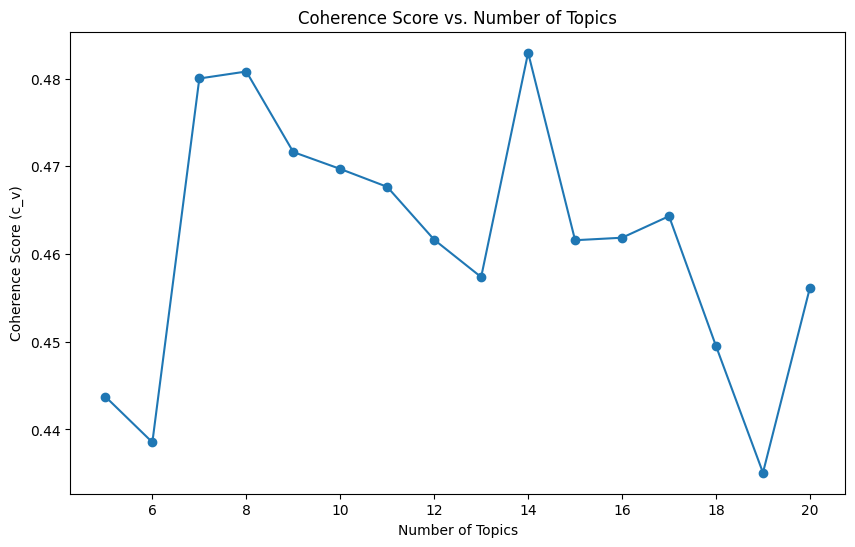

In [77]:
# Determine the optimal number of topics using coherence scores
topic_range = range(5, 21, 1)
coherence_scores = []

for k in topic_range:
    lda = LatentDirichletAllocation(n_components=k, random_state=42, learning_method='batch')
    lda.fit(X_counts)
    
    # Extract topics
    topics = []
    for topic_idx, topic in enumerate(lda.components_):
        top_features_ind = topic.argsort()[:-11:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        topics.append(top_features)
    
    # Compute coherence score
    coherence_model = CoherenceModel(topics=topics, texts=tokenized_reviews, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model.get_coherence()
    coherence_scores.append(coherence)
    
    print(f'Number of Topics: {k}, Coherence Score: {coherence:.4f}')

# Plot coherence scores
plt.figure(figsize=(10,6))
plt.plot(topic_range, coherence_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score (c_v)')
plt.title('Coherence Score vs. Number of Topics')
plt.show()


In [78]:
# Select the number of topics with the highest coherence score
optimal_k = topic_range[coherence_scores.index(max(coherence_scores))]
print(f'Optimal number of topics based on coherence score: {optimal_k}')

Optimal number of topics based on coherence score: 14


In [79]:
# Train LDA with optimal number of topics
lda_optimal = LatentDirichletAllocation(n_components=optimal_k, random_state=42, learning_method='batch')
lda_optimal.fit(X_counts)

LatentDirichletAllocation(n_components=14, random_state=42)

In [80]:
# Display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx +1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("\n")

no_top_words = 10
display_topics(lda_optimal, feature_names, no_top_words)

Topic 1:
stay, experience, service, hotel, staff, special, highly, recommend, food, exceptional


Topic 2:
view, room, ella, breakfast, tuk, stay, place, night, sri, town


Topic 3:
hotel, good, room, staff, service, food, stay, location, clean, excellent


Topic 4:
service, special, team, staff, food, birthday, dinner, stay, chef, excellent


Topic 5:
villa, resort, yoga, spa, nature, jungle, experience, class, treatment, private


Topic 6:
hotel, room, food, good, dinner, buffet, breakfast, restaurant, staff, pool


Topic 7:
room, water, bed, night, bathroom, breakfast, shower, hot, good, clean


Topic 8:
place, eliya, nuwara, house, home, like, stay, garden, room, family


Topic 9:
room, hotel, beach, staff, great, pool, view, clean, friendly, nice


Topic 10:
room, area, hotel, little, road, hear, bathroom, building, main, staff


Topic 11:
great, ella, kandy, time, buffet, price, location, good, dinner, night


Topic 12:
place, good, nice, stay, beach, really, clean, great, room, 

#### Visualizations

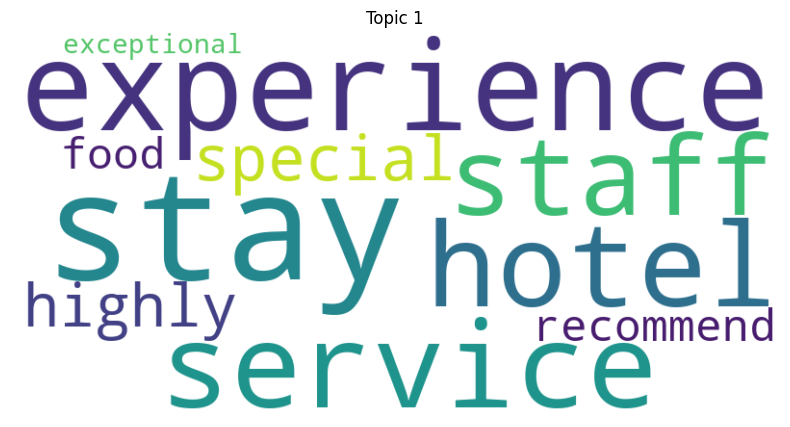

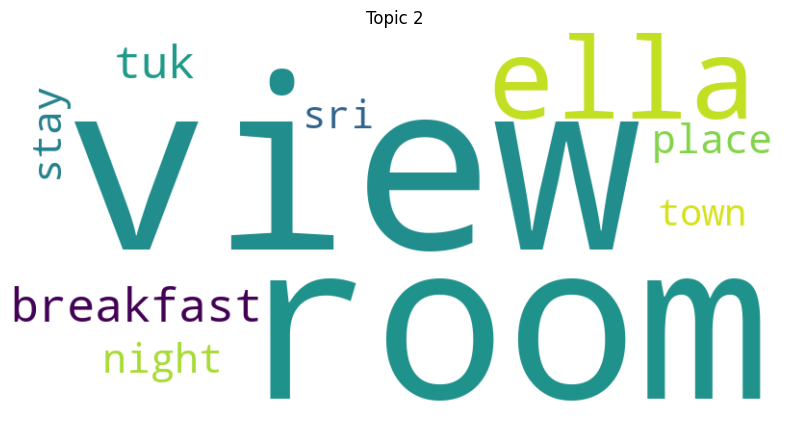

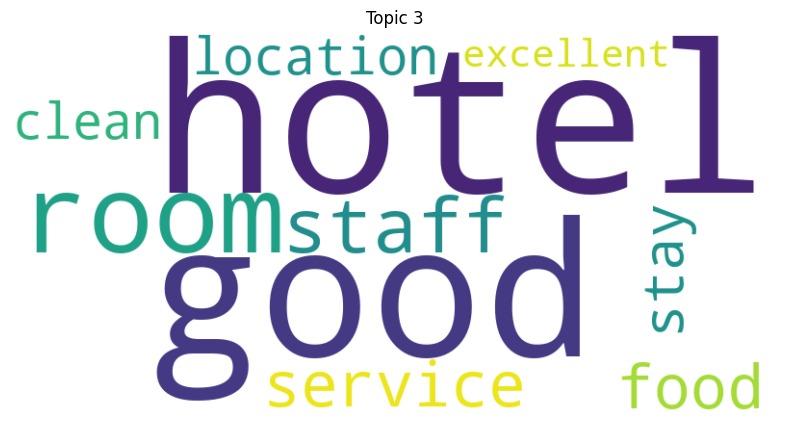

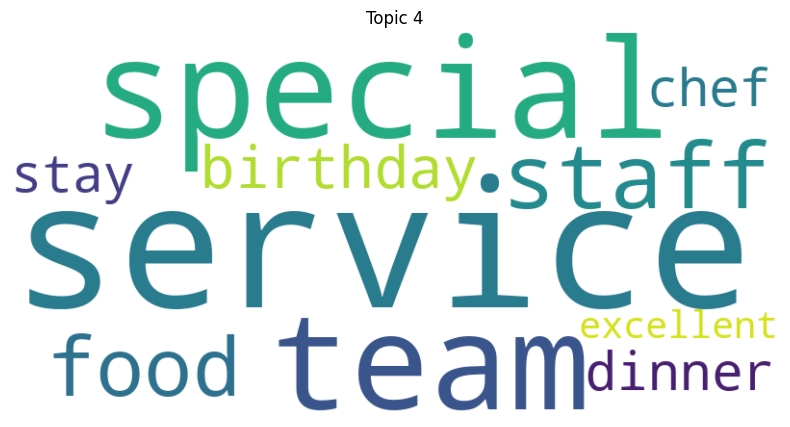

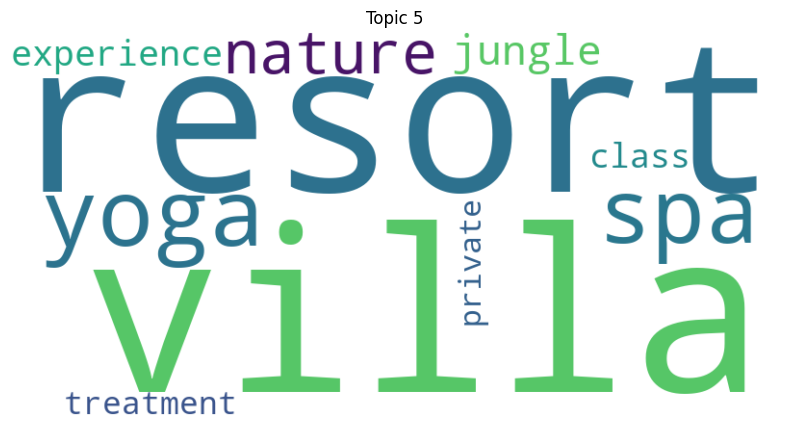

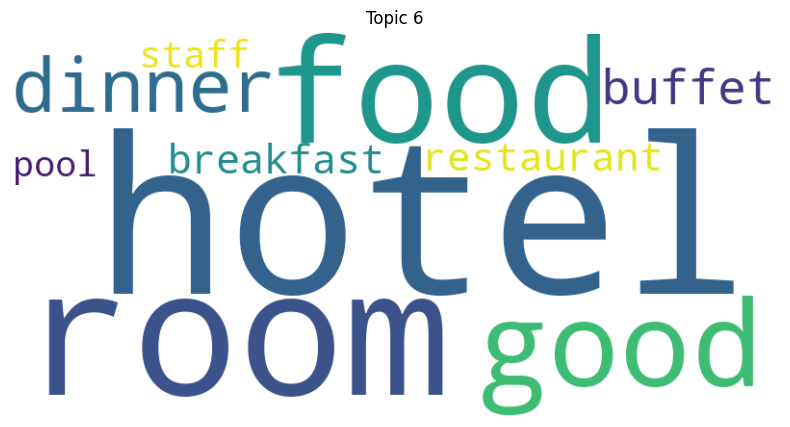

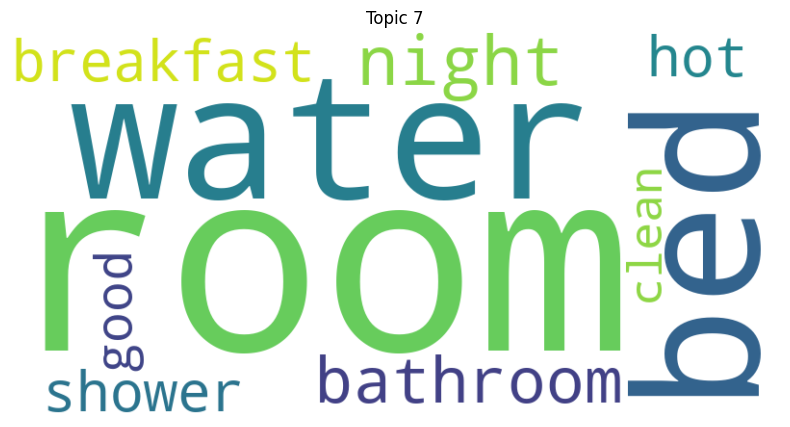

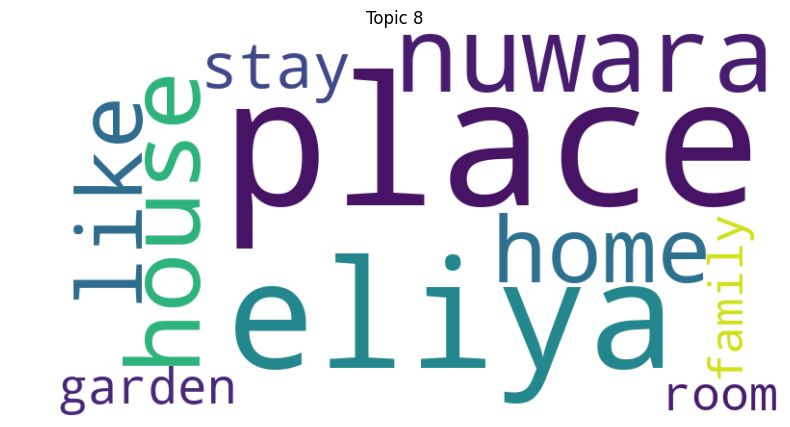

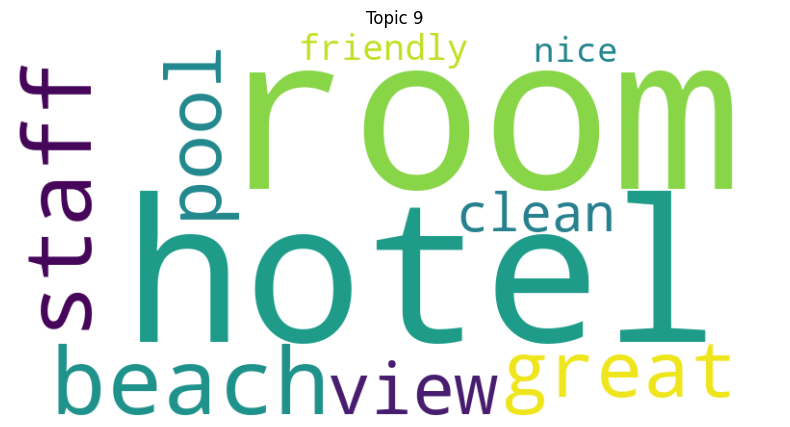

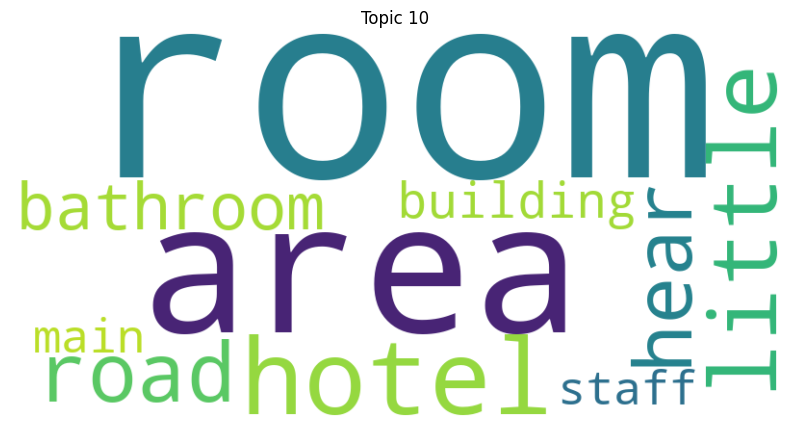

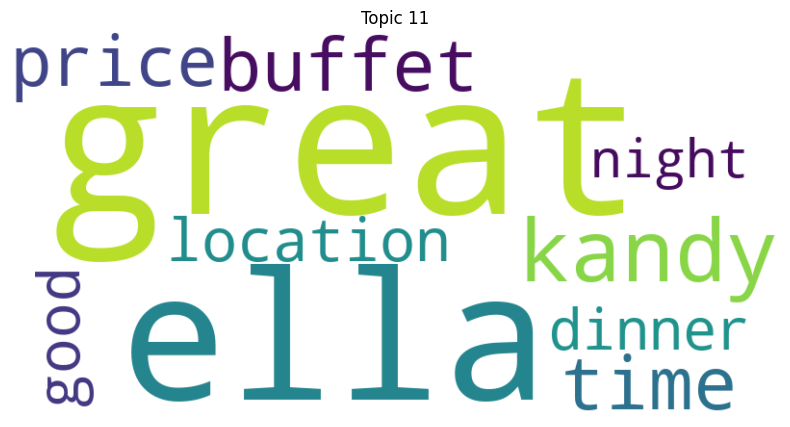

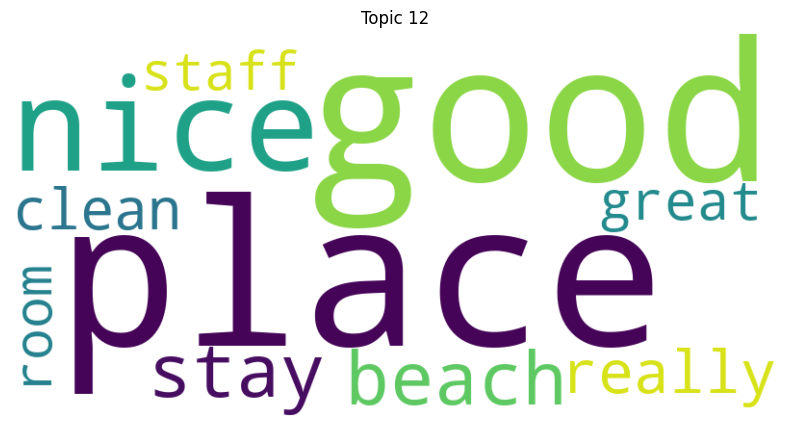

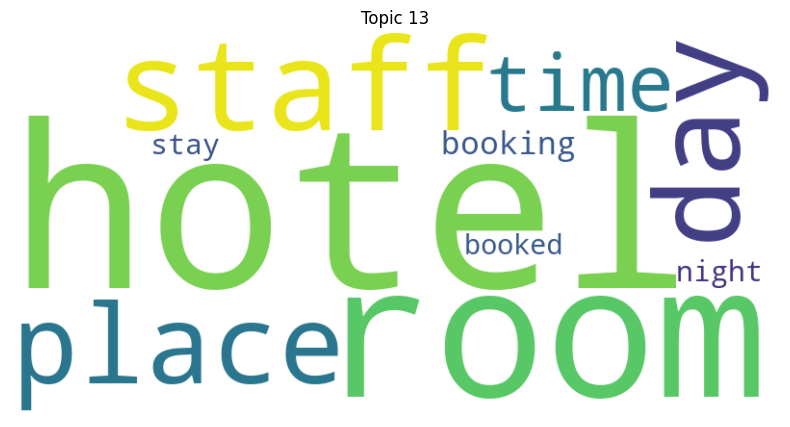

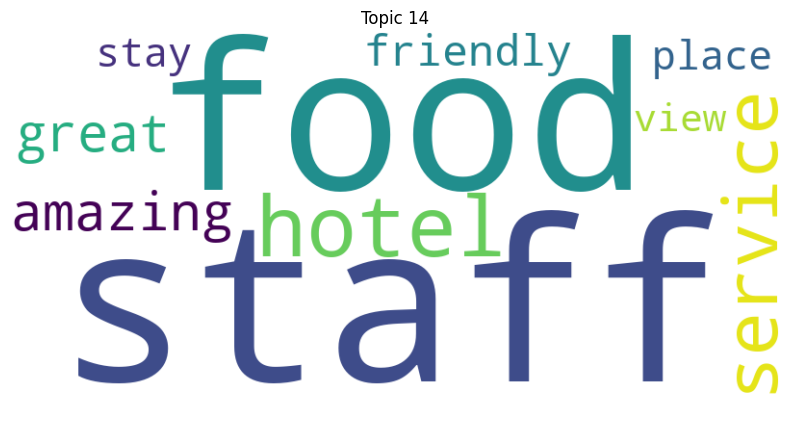

In [125]:
def plot_wordclouds(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-no_top_words -1:-1]]
        top_weights = topic[topic.argsort()[:-no_top_words -1:-1]]
        word_freq = dict(zip(top_features, top_weights))
        
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
        
        plt.figure(figsize=(10,5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Topic {topic_idx +1}")
        plt.show()

plot_wordclouds(lda_optimal, feature_names, no_top_words)

In [ ]:
# HDBSCAN is a density-based clustering method that does not require the number of clusters in advance.
loaded_vectors = np.load('data/processed/w2v_embedding_matrix.npy')
# Fit HDBSCAN
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=10,
                                    min_samples = 5,
                                    metric='euclidean',
                                    cluster_selection_epsilon=0.1 )
topics = hdbscan_clusterer.fit_predict(loaded_vectors)

# Number of clusters (excluding noise points labeled as -1)
n_clusters = len(set(topics)) - (1 if -1 in topics else 0)
print(f"Number of clusters: {n_clusters}")

Number of clusters: 0


In [ ]:
X_fasttext = normalize(loaded_vectors)

In [120]:
hdbscan_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10,  # Experiment with values like 5, 10, 20
    min_samples=5,        # Lower this for higher sensitivity to small clusters
    metric='euclidean',   # Other options: 'cosine', 'manhattan'
    cluster_selection_epsilon=0.1  # Add if clusters are too sparse
)
topics_nomralized = hdbscan_clusterer.fit_predict(X_fasttext)


In [121]:
# Number of clusters (excluding noise points labeled as -1)
n_clusters = len(set(topics_nomralized)) - (1 if -1 in topics_nomralized else 0)
print(f"Number of clusters: {n_clusters}")

Number of clusters: 0


In [ ]:
# Reduce dimensions to 50 before HDBSCAN
pca = PCA(n_components=50, random_state=42)
X_reduced = pca.fit_transform(X_fasttext)

# Run HDBSCAN on reduced data
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean')
topics = hdbscan_clusterer.fit_predict(X_reduced)


In [123]:
# Number of clusters (excluding noise points labeled as -1)
n_clusters = len(set(topics)) - (1 if -1 in topics else 0)
print(f"Number of clusters: {n_clusters}")

Number of clusters: 0


In [ ]:
print(set(topics))

{-1}


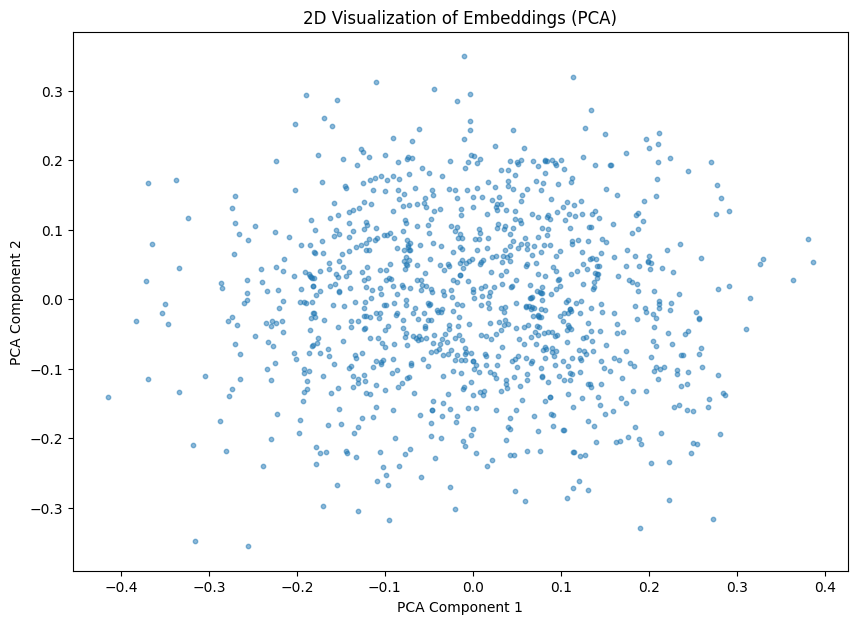

In [127]:
random_vectors = random.sample(range(11808), 1000)

# Reduce embeddings to 2D
pca = PCA(n_components=20)
X_embedded = pca.fit_transform(X_fasttext)

# Plot the reduced embeddings
plt.figure(figsize=(10, 7))
plt.scatter(X_embedded[random_vectors, 0], X_embedded[random_vectors, 1], alpha=0.5, s=10)
plt.title("2D Visualization of Embeddings (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


In [129]:
fasttext_vectors = X_fasttext
sentiments = df['sentiment']

In [130]:
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(fasttext_vectors)

# Map sentiments to colors
sentiment_colors = {'positive': 'green', 'negative': 'red', 'neutral': 'blue'}
colors = [sentiment_colors[s] for s in sentiments]

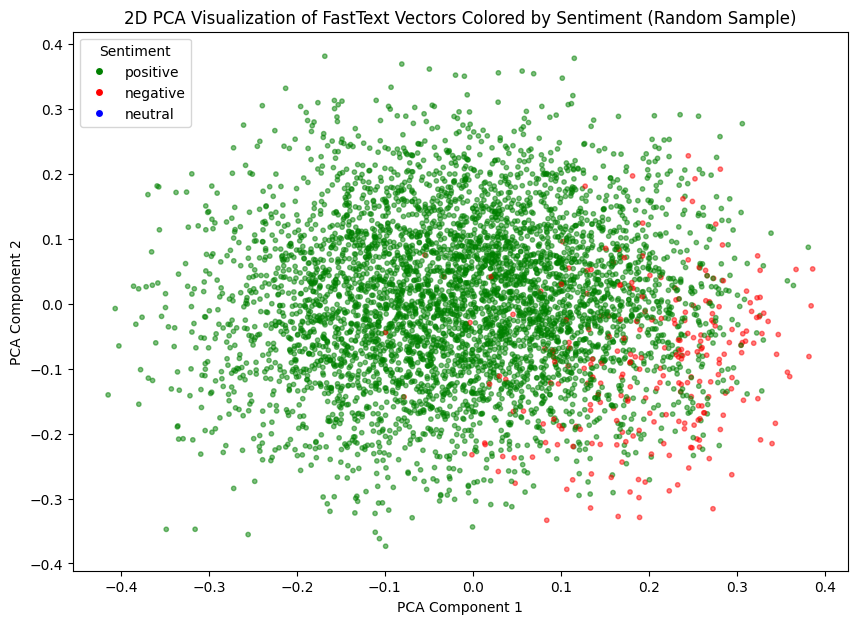

In [131]:
# Generate random indices
random.seed(42)  # Set a seed for reproducibility
random_vectors = random.sample(range(X_pca.shape[0]), 5000)  # Randomly sample 100 indices

# Subset PCA components and corresponding colors using the random indices
X_pca_subset = X_pca[random_vectors]
colors_subset = [colors[i] for i in random_vectors]

# Create scatter plot
plt.figure(figsize=(10, 7))
plt.scatter(X_pca_subset[:, 0], X_pca_subset[:, 1], c=colors_subset, alpha=0.5, s=10)
plt.title("2D PCA Visualization of FastText Vectors Colored by Sentiment (Random Sample)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=k, markerfacecolor=v)
                     for k, v in sentiment_colors.items()],
           title="Sentiment")
plt.show()


In [133]:
# Fit t-SNE to the embeddings
tsne = TSNE(n_components=3, perplexity=80, random_state=42)
X_tsne = tsne.fit_transform(X_fasttext)

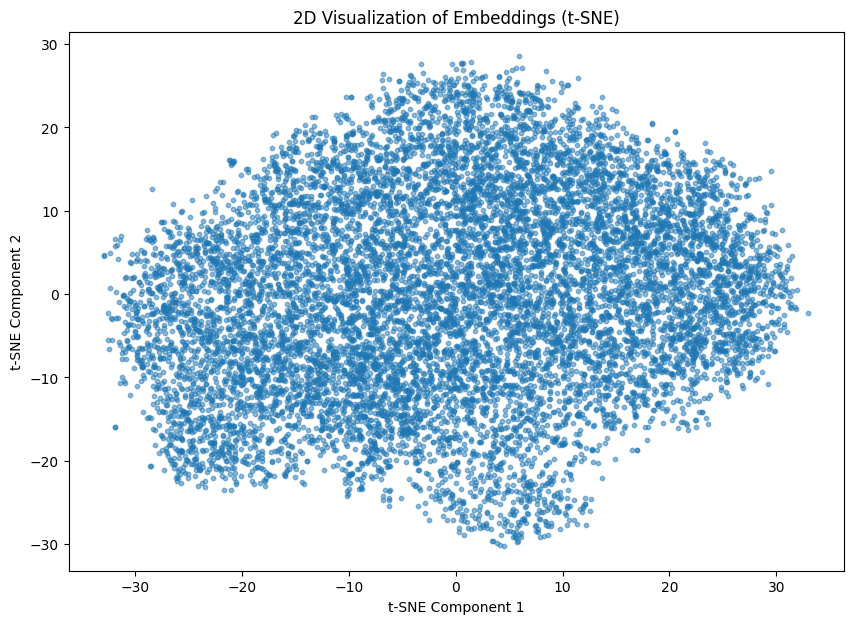

In [ ]:
# Plot the t-SNE projection
plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.5, s=10)
plt.title("2D Visualization of Embeddings (t-SNE)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

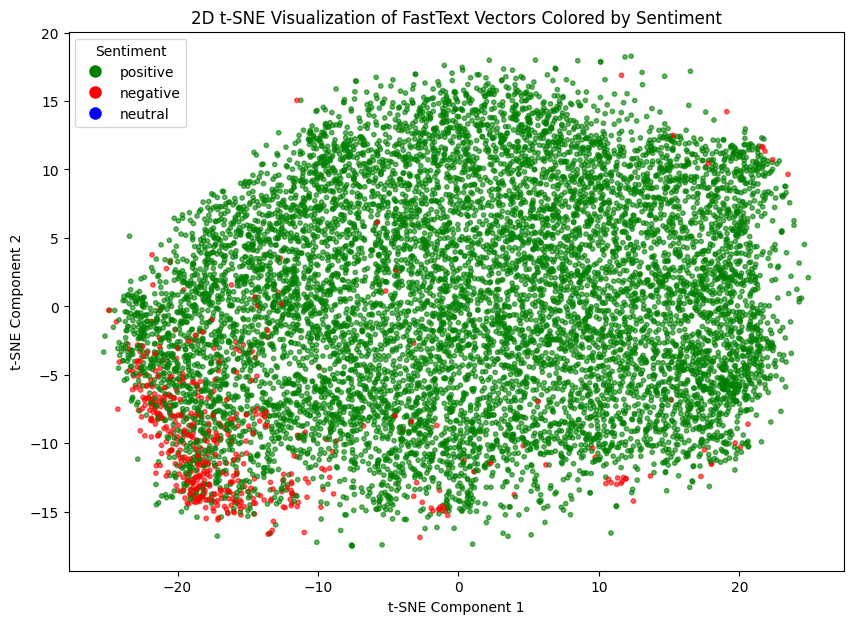

In [ ]:
# Define sentiment colors
sentiment_colors = {
    "positive": "green",
    "negative": "red",
    "neutral": "blue"
}

# Map sentiment labels to colors
colors = [sentiment_colors[sent] for sent in sentiments]

# Randomly sample 1000 points for visualization
random_indices = random.sample(range(X_tsne.shape[0]), min(10000, X_tsne.shape[0]))

# Create scatter plot
plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[random_indices, 0], X_tsne[random_indices, 1],
            c=np.array(colors)[random_indices], alpha=0.6, s=15)
plt.title("2D t-SNE Visualization of FastText Vectors Colored by Sentiment")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

# Add legend
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=k, markerfacecolor=v, markersize=10)
                     for k, v in sentiment_colors.items()],
           title="Sentiment", loc="best")
plt.show()


In [ ]:
# Define topic colors (example: topics 0 to 9)
num_topics = df['assigned_topics'].nunique()  # Get the number of unique topics
topic_colors = {topic: plt.cm.tab10(topic % 10) for topic in range(num_topics)}  # Use tab10 colormap
# Map topics to colors
colors = [topic_colors[topic] for topic in df['assigned_topics']]

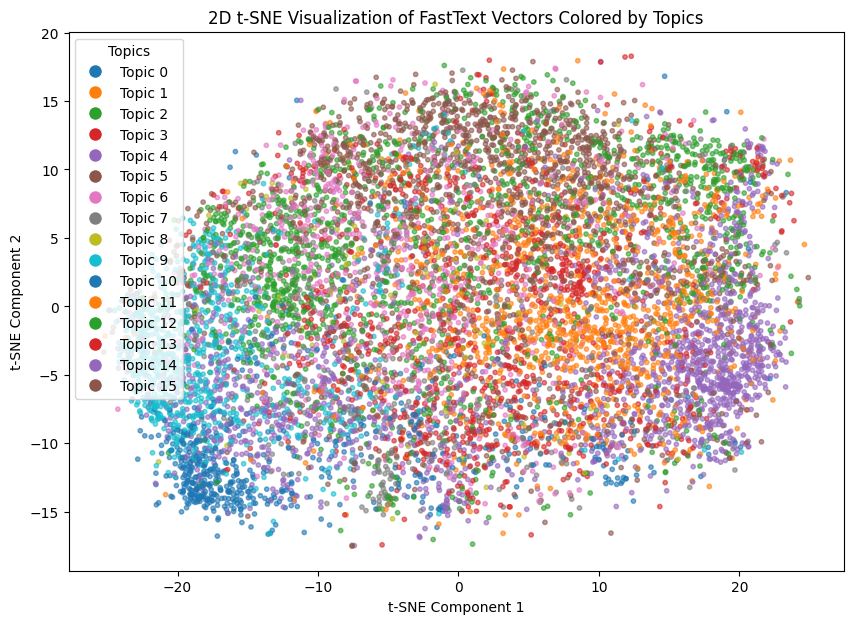

In [ ]:
# Randomly sample points for visualization (e.g., 1000 points)
random_indices = random.sample(range(X_tsne.shape[0]), min(10000, X_tsne.shape[0]))

# Create scatter plot
plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[random_indices, 0], X_tsne[random_indices, 1],
            c=np.array(colors)[random_indices], alpha=0.6, s=5)
plt.title("2D t-SNE Visualization of FastText Vectors Colored by Topics")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

# Add legend for topics
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=f"Topic {k}", markerfacecolor=v, markersize=10)
                     for k, v in topic_colors.items()],
           title="Topics", loc="best")
plt.show()


#### Validation of Topic Modeling

In [81]:
subset_reviews = df.sample(n=50, random_state=42).reset_index(drop=True)

In [ ]:
manual_labels = [
    ['Location', 'Service', 'Staff Friendliness', 'View'],
    ['Staff Friendliness', 'Overall Experience', 'Amenities'], 
    ['Location', 'Room Quality', 'Service'],
    ['Location', 'Amenities', 'Overall Experience'], 
    ['Location', 'Room Quality', 'Amenities', 'Service'], 
    ['Food', 'Service', 'Staff Friendliness', 'View'], 
    ['View', 'Amenities', 'Staff Friendliness', 'Overall Experience'], 
    ['Location', 'Room Quality', 'Staff Friendliness'], 
    ['Location', 'Staff Friendliness', 'Overall Experience', 'View'], 
    ['Location', 'Food', 'Amenities', 'Staff Friendliness'],
    ['Location', 'Food', 'Staff Friendliness', 'Overall Experience'],
    ['Room Quality', 'Service', 'Staff Friendliness', 'Food'],
    ['Service', 'Cleanliness', 'Overall Experience'], 
    ['Food', 'Location'], 
    ['Location', 'View', 'Value for Money', 'Overall Experience'], 
    ['Service', 'Staff Friendliness', 'Overall Experience'], 
    ['Room Quality', 'Service', 'Food', 'Staff Friendliness'], 
    ['Food', 'Staff Friendliness', 'View', 'Overall Experience'], 
    ['Location', 'View', 'Food', 'Overall Experience'], 
    ['Service', 'Staff Friendliness', 'Room Quality', 'View'],  
    ['Room Quality', 'Service', 'Staff Friendliness', 'View'], 
    ['Location', 'View', 'Staff Friendliness', 'Service'], 
    ['Service', 'Staff Friendliness', 'Food', 'Overall Experience'], 
    ['Location', 'Service', 'Staff Friendliness', 'Overall Experience'], 
    ['Room Quality', 'Amenities', 'Overall Experience'], 
    ['Location', 'Room Quality', 'Food', 'Staff Friendliness'],
    ['Service', 'Staff Friendliness', 'Cleanliness', 'Overall Experience'],  
    ['View', 'Amenities', 'Location'], 
    ['Room Quality', 'Service', 'Staff Friendliness', 'Food'],  
    ['Service', 'Staff Friendliness', 'Room Quality', 'Overall Experience'], 
    ['Room Quality', 'Amenities', 'Service'], 
    ['Amenities', 'Service', 'Overall Experience'], 
    ['Location', 'Staff Friendliness', 'Food', 'Overall Experience'], 
    ['Staff Friendliness', 'Room Quality', 'Location', 'Overall Experience'],  
    ['Service', 'Room Quality', 'Overall Experience'],  
    ['Location', 'View', 'Staff Friendliness', 'Food'], 
    ['Location', 'Room Quality', 'Service'], 
    ['Cleanliness', 'Service', 'Room Quality'],  
    ['Service', 'Staff Friendliness', 'Overall Experience'],  
    ['Location', 'Room Quality', 'Amenities', 'Food'], 
    ['Amenities', 'Staff Friendliness', 'Service'],  
    ['Service', 'Room Quality'], 
    ['Service', 'Staff Friendliness', 'Overall Experience', 'Food'],  
    ['Room Quality', 'Cleanliness', 'Service'], 
    ['Room Quality', 'Location', 'Staff Friendliness', 'Food'],
    ['Location', 'Room Quality', 'Service', 'Staff Friendliness'],  
    ['Staff Friendliness', 'Service'], 
    ['Food', 'Staff Friendliness'], 
    ['Location', 'Room Quality', 'Staff Friendliness', 'View'],  
    ['Service', 'Staff Friendliness', 'Food', 'Room Quality'] 
]

In [ ]:
len(manual_labels)

50

In [93]:
subset_reviews['manual_labels'] = manual_labels

In [ ]:
# Assigning topics to the subset reviews
subset_counts = count_vectorizer.transform(subset_reviews['review_text'])
topic_distributions_subset = lda_optimal.transform(subset_counts)
subset_reviews['assigned_topic'] = topic_distributions_subset.argmax(axis=1)

In [89]:
topic_aspect_mapping = {
    0: 'Staff Friendliness',
    1: 'View',
    2: 'Service',
    3: 'Service',
    4: 'Amenities',
    5: 'Food',
    6: 'Room Quality',
    7: 'Room Quality',
    8: 'Location',
    9: 'Location',
    10: 'Room Quality',
    11: 'Food',
    12: 'Location',
    13: 'Service',
    14: 'Staff Friendliness'
}

In [98]:
subset_reviews['mapped_aspect'] = subset_reviews['assigned_topic'].map(topic_aspect_mapping)

In [ ]:
mlb = MultiLabelBinarizer()
manual_binary = mlb.fit_transform(subset_reviews['manual_labels'])
mapped_binary = mlb.transform(subset_reviews['mapped_aspect'].apply(lambda x: [x] if pd.notnull(x) else []))

# Compute Adjusted Rand Index
ari = adjusted_rand_score(manual_binary.argmax(axis=1), mapped_binary.argmax(axis=1))
print(f'Adjusted Rand Index: {ari:.4f}')

# Compute Jaccard Coefficient for multi-label
jaccard = jaccard_score(manual_binary, mapped_binary, average='macro')
print(f'Jaccard Coefficient: {jaccard:.4f}')

Adjusted Rand Index: 0.0192
Jaccard Coefficient: 0.1393


#### Connecting Topics to Sentiment Analysis

In [101]:
df['assigned_topic'] = lda_optimal.transform(X_counts).argmax(axis=1)
df['mapped_aspect'] = df['assigned_topic'].map(topic_aspect_mapping)

In [102]:
# Calculate sentiment distribution per topic
sentiment_distribution = df.groupby(['mapped_aspect', 'sentiment']).size().unstack(fill_value=0)

# Normalize to get proportions
sentiment_proportions = sentiment_distribution.div(sentiment_distribution.sum(axis=1), axis=0)

print(sentiment_proportions)

sentiment           negative  positive
mapped_aspect                         
Amenities           0.000000  1.000000
Food                0.029672  0.970328
Location            0.151098  0.848902
Room Quality        0.109822  0.890178
Service             0.005926  0.994074
Staff Friendliness  0.001233  0.998767
View                0.004867  0.995133


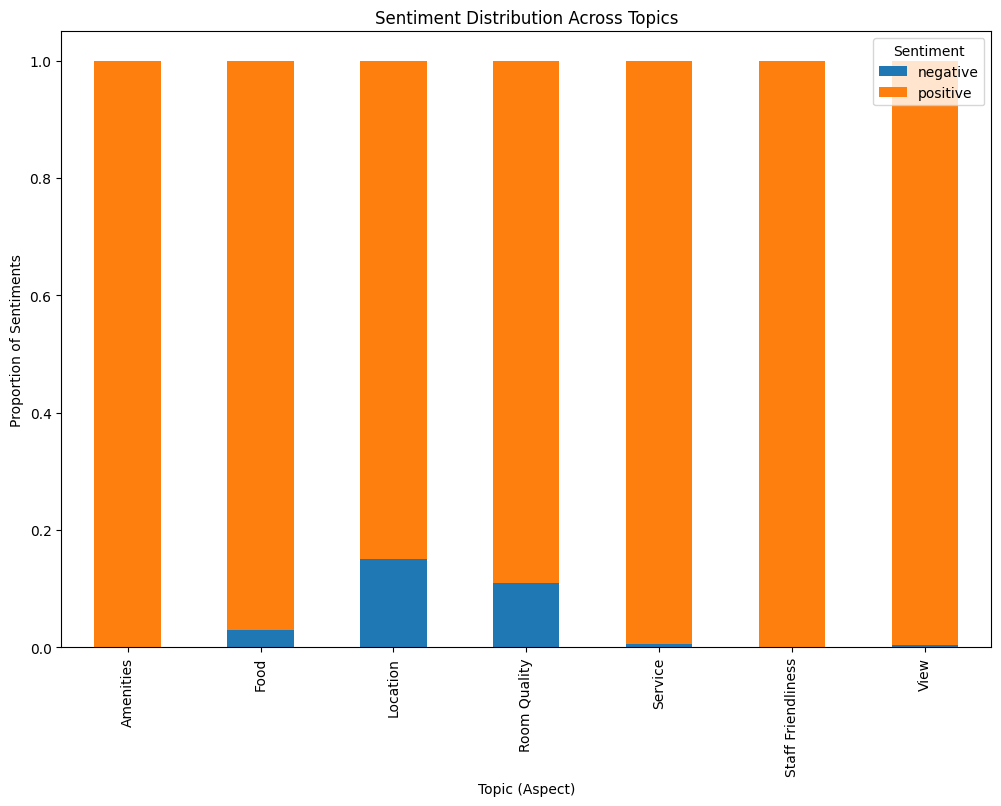

In [103]:
sentiment_proportions.plot(kind='bar', stacked=True, figsize=(12,8))
plt.xlabel('Topic (Aspect)')
plt.ylabel('Proportion of Sentiments')
plt.title('Sentiment Distribution Across Topics')
plt.legend(title='Sentiment')
plt.show()

In [111]:
# Create the contingency table
contingency_table = pd.crosstab(df['sentiment'], df['assigned_topic'])

# Print the contingency table
contingency_table

assigned_topic   0     1    2    3   4    5    6    7     8   9   10    11  \
sentiment                                                                    
negative          1     9   15    3   0   54  136    3     1   9   3     3   
positive        810  1840  975  326  65  650  763  318  1509  75  70  1214   

assigned_topic   12    13  
sentiment                  
negative        341     3  
positive        388  2222

In [112]:
# Step 2: Perform Chi-square Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

In [113]:
print("\nChi-Square Test Results:")
print(f"Chi2 Value: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Frequencies:\n{expected}")


Chi-Square Test Results:
Chi2 Value: 3356.6406155416917
P-Value: 0.0
Degrees of Freedom: 13
Expected Frequencies:
[[  39.91114687   90.99347789   48.7201423    16.19083517    3.19879722
    34.64543452   44.24182619   15.79713705   74.31052007    4.13383026
     3.59249534   59.89132644   35.87574115  109.49728951]
 [ 771.08885313 1758.00652211  941.2798577   312.80916483   61.80120278
   669.35456548  854.75817381  305.20286295 1435.68947993   79.86616974
    69.40750466 1157.10867356  693.12425885 2115.50271049]]


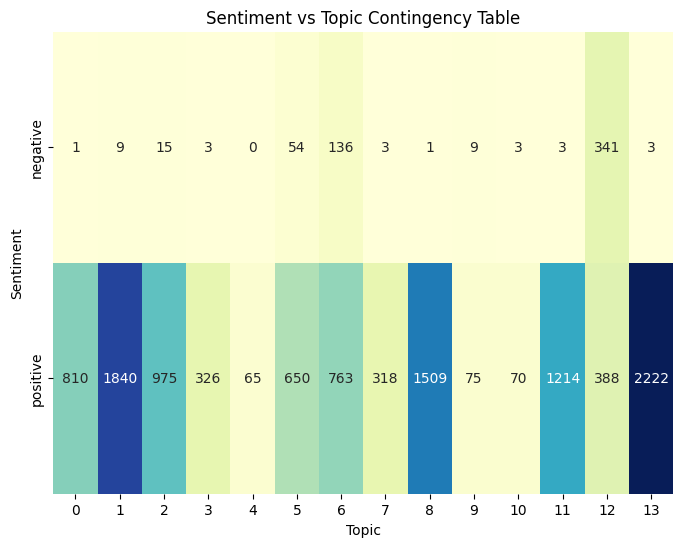

In [114]:
# Visualizing the Contingency Table using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu", fmt="d", cbar=False)
plt.title('Sentiment vs Topic Contingency Table')
plt.ylabel('Sentiment')
plt.xlabel('Topic')
plt.show()

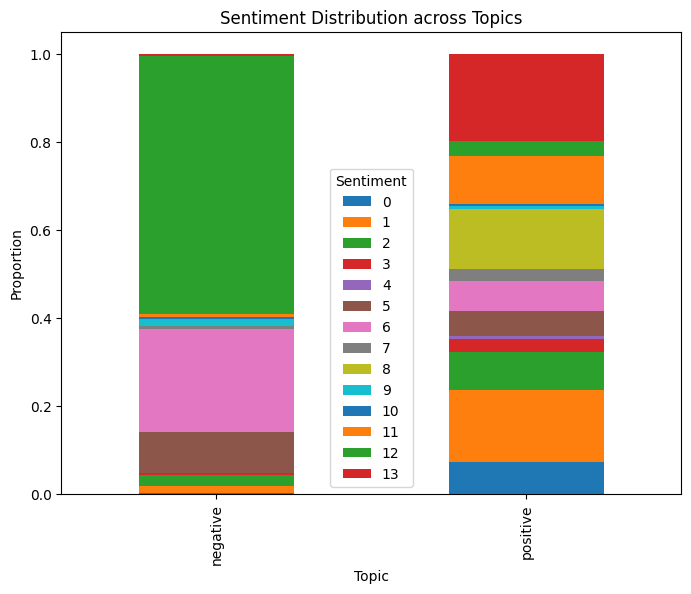

In [115]:
# Displaying Sentiment Distribution across Topics
sentiment_dist = contingency_table.div(contingency_table.sum(axis=1), axis=0)
sentiment_dist.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Sentiment Distribution across Topics')
plt.ylabel('Proportion')
plt.xlabel('Topic')
plt.legend(title="Sentiment")
plt.show()

**Interpretation of Topic Modeling**

1. **Analysis of Identified Topics**:

- The LDA model uncovered 14 distinct topics that represented the main themes discussed in the hotel reviews. While the specific keywords for each topic are numerous, they generally corresponded to aspects such as:

    - Location: Proximity to attractions, transportation, and convenience of the surrounding area.
    - Service: Quality of assistance provided by the staff, responsiveness and professionalism.
    - Cleanliness: Overall hygiene and maintenance of the hotel premises and rooms.
    - Room Quality: Comfort, design, and condition of the rooms, including furnishings and space.
    - Food: Taste, variety, and quality of the meals and dining options offered.
    - Value for Money: Pricing, perceived value, affordability.
    - Staff Friendliness: Friendliness, helpfulness, professionalism of the staff.
    - Amenities: Pool, gym, spa, Wi-Fi quality.
    - View: Aesthetic appeal of the surroundings visible from the hotel or rooms.
    - Overall Experience: The guest's general satisfaction with their stay, encompassing all aspects.

2. **Validation Results**:

    - **Rand Index and Jaccard Coefficient**:
        - The Rand Index yielded a score of 0.0192, that there is minimal to no agreement between the LDA-generated topics and the manually annotated labels. 
        - The Jaccard Coefficient was calculated to be 0.1393, indicates a low level of overlap between the LDA-generated topics and the manually annotated labels.
    - **Interpretation**:
        - These validation metrics demonstrate that the topics produced by LDA do not effectively capture the manually identified themes.
        - The number of topics chosen (13) might be too granular or not granular enough compared to the manually annotated themes.
        - The manual labeling process might have inherent biases or inconsistencies, leading to labels that do not perfectly align with the topics generated by an unsupervised model like LDA.

3. **Sentiment Distribution Across Topics**:

- By analyzing the sentiment distribution within each topic, we gained insights into how customers feel about specific aspects:
    - All of the topics were predominantly positive topics
    - Location, Room Quality and Food were the only topics were there was a slight notable negative sentiment available.

***